In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from kneed import KneeLocator

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

from kuma_utils.preprocessing.imputer import LGBMImputer

from sklearn.metrics import silhouette_score, davies_bouldin_score

plt.style.use('ggplot')

In [3]:
pd.set_option('display.max_columns', 24)
df = pd.read_csv('Data.csv')
df.head()

Ware_house_ID WH_Manager_ID Location_type WH_capacity_size   zone  \
0     WH_100000     EID_50000         Urban            Small   West   
1     WH_100001     EID_50001         Rural            Large  North   
2     WH_100002     EID_50002         Rural              Mid  South   
3     WH_100003     EID_50003         Rural              Mid  North   
4     WH_100004     EID_50004         Rural            Large  North   

  WH_regional_zone  num_refill_req_l3m  transport_issue_l1y  \
0           Zone 6                   3                    1   
1           Zone 5                   0                    0   
2           Zone 2                   1                    0   
3           Zone 3                   7                    4   
4           Zone 5                   3                    1   

   Competitor_in_mkt  retail_shop_num  wh_owner_type  distributor_num  \
0                  2             4651         Rented               24   
1                  4             6217  Company Owned               47   
2                  4             4306  Company Owned               64   
3                  2             6000         Rented               50   
4                  2             4740  Company Owned               42   

   flood_impacted  flood_proof  electric_supply  dist_from_hub  workers_num  \
0               0            1                1             91         29.0   
1               0            0                1            210         31.0   
2               0            0                0            161         37.0   
3               0            0                0            103         21.0   
4               1            0                1            112         25.0   

   wh_est_year  storage_issue_reported_l3m  temp_reg_mach  \
0          NaN                          13              0   
1          NaN                           4              0   
2          NaN                          17              0   
3          NaN                          17              1   
4       2009.0                          18              0   

  approved_wh_govt_certificate  wh_breakdown_l3m  govt_check_l3m  \
0                            A                 5              15   
1                            A                 3              17   
2                            A                 6              22   
3                           A+                 3              27   
4                            C                 6              24   

   product_wg_ton  
0           17115  
1            5074  
2           23137  
3           22115  
4           24071

In [117]:
df.isnull().sum()

Ware_house_ID                       0
WH_Manager_ID                       0
Location_type                       0
WH_capacity_size                    0
zone                                0
WH_regional_zone                    0
num_refill_req_l3m                  0
transport_issue_l1y                 0
Competitor_in_mkt                   0
retail_shop_num                     0
wh_owner_type                       0
distributor_num                     0
flood_impacted                      0
flood_proof                         0
electric_supply                     0
dist_from_hub                       0
workers_num                       990
wh_est_year                     11881
storage_issue_reported_l3m          0
temp_reg_mach                       0
approved_wh_govt_certificate      908
wh_breakdown_l3m                    0
govt_check_l3m                      0
product_wg_ton                      0
dtype: int64

In [120]:
df.groupby('WH_capacity_size')['product_wg_ton'].mean().diff()

WH_capacity_size
Large           NaN
Mid      101.810249
Small   -302.706543
Name: product_wg_ton, dtype: float64

In [34]:
pv = pd.pivot_table(df, index=['Location_type', 'zone', 'WH_regional_zone'], values='product_wg_ton', aggfunc='mean')
pv

product_wg_ton
Location_type zone  WH_regional_zone                
Rural         East  Zone 1              19509.108108
                    Zone 3              22125.090000
                    Zone 4              23214.030303
                    Zone 5              23981.428571
                    Zone 6              21375.232143
              North Zone 1              21950.975827
                    Zone 2              22028.320562
                    Zone 3              21882.560780
                    Zone 4              21716.166045
                    Zone 5              22012.028393
                    Zone 6              21842.173049
              South Zone 1              21391.212934
                    Zone 2              22236.262064
                    Zone 3              21103.411548
                    Zone 4              21528.919753
                    Zone 5              21532.983301
                    Zone 6              22090.404610
              West  Zone 1              21274.880266
                    Zone 2              22619.571192
                    Zone 3              22310.394799
                    Zone 4              21926.595424
                    Zone 5              21307.607743
                    Zone 6              21823.242902
Urban         East  Zone 1              25083.500000
                    Zone 3              26181.250000
                    Zone 4              24191.900000
                    Zone 5              22343.500000
                    Zone 6              38611.500000
              North Zone 1              22048.436364
                    Zone 2              24199.394366
                    Zone 3              25327.438202
                    Zone 4              26094.640351
                    Zone 5              26473.929487
                    Zone 6              25774.007634
              South Zone 1              24366.021739
                    Zone 2              25934.577320
                    Zone 3              22985.098592
                    Zone 4              24892.291667
                    Zone 5              24641.797753
                    Zone 6              23074.726415
              West  Zone 1              26749.384615
                    Zone 2              24333.049180
                    Zone 3              22637.636364
                    Zone 4              25932.241379
                    Zone 5              25605.100000
                    Zone 6              23664.793296

In [39]:
pv.sort_values(by='product_wg_ton', ascending=False)

product_wg_ton
Location_type zone  WH_regional_zone                
Urban         East  Zone 6              38611.500000
              West  Zone 1              26749.384615
              North Zone 5              26473.929487
              East  Zone 3              26181.250000
              North Zone 4              26094.640351
              South Zone 2              25934.577320
              West  Zone 4              25932.241379
              North Zone 6              25774.007634
              West  Zone 5              25605.100000
              North Zone 3              25327.438202
              East  Zone 1              25083.500000
              South Zone 4              24892.291667
                    Zone 5              24641.797753
                    Zone 1              24366.021739
              West  Zone 2              24333.049180
              North Zone 2              24199.394366
              East  Zone 4              24191.900000
Rural         East  Zone 5              23981.428571
Urban         West  Zone 6              23664.793296
Rural         East  Zone 4              23214.030303
Urban         South Zone 6              23074.726415
                    Zone 3              22985.098592
              West  Zone 3              22637.636364
Rural         West  Zone 2              22619.571192
Urban         East  Zone 5              22343.500000
Rural         West  Zone 3              22310.394799
              South Zone 2              22236.262064
              East  Zone 3              22125.090000
              South Zone 6              22090.404610
Urban         North Zone 1              22048.436364
Rural         North Zone 2              22028.320562
                    Zone 5              22012.028393
                    Zone 1              21950.975827
              West  Zone 4              21926.595424
              North Zone 3              21882.560780
                    Zone 6              21842.173049
              West  Zone 6              21823.242902
              North Zone 4              21716.166045
              South Zone 5              21532.983301
                    Zone 4              21528.919753
                    Zone 1              21391.212934
              East  Zone 6              21375.232143
              West  Zone 5              21307.607743
                    Zone 1              21274.880266
              South Zone 3              21103.411548
              East  Zone 1              19509.108108

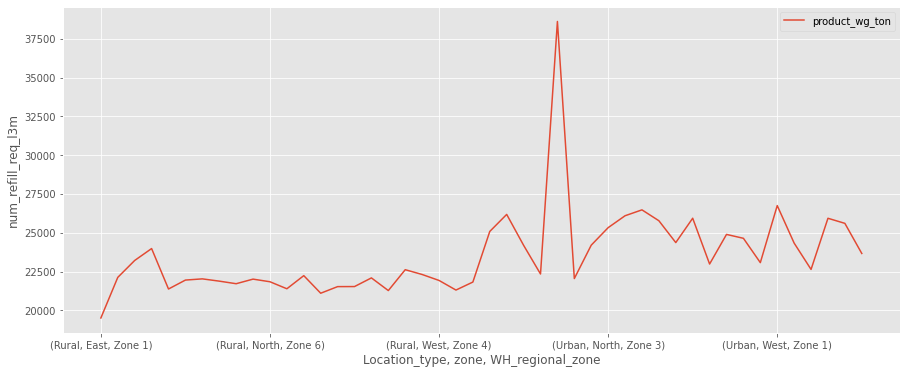

In [37]:
pv.plot(figsize=(15, 6))
plt.xlabel('Location_type, zone, WH_regional_zone')
plt.ylabel('num_refill_req_l3m')
plt.savefig('lt_z_whrz_nrrl3m.png')
plt.show()

In [9]:
pivot_df = pd.pivot_table(df, index=['WH_capacity_size', 'Location_type', 'zone', 'WH_regional_zone'], values='product_wg_ton', aggfunc=['mean', 'median', 'count'])
pivot_df

mean  \
                                                      product_wg_ton   
WH_capacity_size Location_type zone  WH_regional_zone                  
Large            Rural         East  Zone 5             23981.428571   
                               North Zone 5             22012.028393   
                                     Zone 6             21781.424187   
                               South Zone 5             21532.983301   
                                     Zone 6             22160.885776   
                               West  Zone 5             21307.607743   
                                     Zone 6             22047.808771   
                 Urban         East  Zone 5             22343.500000   
                               North Zone 5             26473.929487   
                                     Zone 6             25980.577778   
                               South Zone 5             24641.797753   
                                     Zone 6             23580.840909   
                               West  Zone 5             25605.100000   
                                     Zone 6             23507.054545   
Mid              Rural         East  Zone 3             22125.090000   
                                     Zone 4             23214.030303   
                               North Zone 2             22028.320562   
                                     Zone 3             21882.560780   
                                     Zone 4             21716.166045   
                               South Zone 2             22236.262064   
                                     Zone 3             21103.411548   
                                     Zone 4             21528.919753   
                               West  Zone 2             22619.571192   
                                     Zone 3             22310.394799   
                                     Zone 4             21926.595424   
                 Urban         East  Zone 3             26181.250000   
                                     Zone 4             24191.900000   
                               North Zone 2             24199.394366   
                                     Zone 3             25327.438202   
                                     Zone 4             26094.640351   
                               South Zone 2             25934.577320   
                                     Zone 3             22985.098592   
                                     Zone 4             24892.291667   
                               West  Zone 2             24333.049180   
                                     Zone 3             22637.636364   
                                     Zone 4             25932.241379   
Small            Rural         East  Zone 1             19509.108108   
                                     Zone 6             21375.232143   
                               North Zone 1             21950.975827   
                                     Zone 6             22070.191244   
                               South Zone 1             21391.212934   
                                     Zone 6             22049.216625   
                               West  Zone 1             21274.880266   
                                     Zone 6             21445.983092   
                 Urban         East  Zone 1             25083.500000   
                                     Zone 6             38611.500000   
                               North Zone 1             22048.436364   
                                     Zone 6             24939.782051   
                               South Zone 1             24366.021739   
                                     Zone 6             22715.548387   
                               West  Zone 1             26749.384615   
                                     Zone 6             23916.260870   

                                                              median  \
                               

In [5]:
df.describe()

num_refill_req_l3m  transport_issue_l1y  Competitor_in_mkt  \
count        25000.000000         25000.000000       25000.000000   
mean             4.089040             0.773680           3.104200   
std              2.606612             1.199449           1.141663   
min              0.000000             0.000000           0.000000   
25%              2.000000             0.000000           2.000000   
50%              4.000000             0.000000           3.000000   
75%              6.000000             1.000000           4.000000   
max              8.000000             5.000000          12.000000   

       retail_shop_num  distributor_num  flood_impacted   flood_proof  \
count     25000.000000     25000.000000    25000.000000  25000.000000   
mean       4985.711560        42.418120        0.098160      0.054640   
std        1052.825252        16.064329        0.297537      0.227281   
min        1821.000000        15.000000        0.000000      0.000000   
25%        4313.000000        29.000000        0.000000      0.000000   
50%        4859.000000        42.000000        0.000000      0.000000   
75%        5500.000000        56.000000        0.000000      0.000000   
max       11008.000000        70.000000        1.000000      1.000000   

       electric_supply  dist_from_hub   workers_num   wh_est_year  \
count     25000.000000   25000.000000  24010.000000  13119.000000   
mean          0.656880     163.537320     28.944398   2009.383185   
std           0.474761      62.718609      7.872534      7.528230   
min           0.000000      55.000000     10.000000   1996.000000   
25%           0.000000     109.000000     24.000000   2003.000000   
50%           1.000000     164.000000     28.000000   2009.000000   
75%           1.000000     218.000000     33.000000   2016.000000   
max           1.000000     271.000000     98.000000   2023.000000   

       storage_issue_reported_l3m  temp_reg_mach  wh_breakdown_l3m  \
count                25000.000000   25000.000000      25000.000000   
mean                    17.130440       0.303280          3.482040   
std                      9.161108       0.459684          1.690335   
min                      0.000000       0.000000          0.000000   
25%                     10.000000       0.000000          2.000000   
50%                     18.000000       0.000000          3.000000   
75%                     24.000000       1.000000          5.000000   
max                     39.000000       1.000000          6.000000   

       govt_check_l3m  product_wg_ton  
count    25000.000000    25000.000000  
mean        18.812280    22102.632920  
std          8.632382    11607.755077  
min          1.000000     2065.000000  
25%         11.000000    13059.000000  
50%         21.000000    22101.000000  
75%         26.000000    30103.000000  
max         32.000000    55151.000000

In [4]:
df.describe(include='object')

Ware_house_ID WH_Manager_ID Location_type WH_capacity_size   zone  \
count          25000         25000         25000            25000  25000   
unique         25000         25000             2                3      4   
top        WH_100000     EID_50000         Rural            Large  North   
freq               1             1         22957            10169  10278   

       WH_regional_zone  wh_owner_type approved_wh_govt_certificate  
count             25000          25000                        24092  
unique                6              2                            5  
top              Zone 6  Company Owned                            C  
freq               8339          13578                         5501

In [3]:
percent_missing = (df.isnull().sum())/(df.shape[0]) * 100
percent_missing

Ware_house_ID                    0.000
WH_Manager_ID                    0.000
Location_type                    0.000
WH_capacity_size                 0.000
zone                             0.000
WH_regional_zone                 0.000
num_refill_req_l3m               0.000
transport_issue_l1y              0.000
Competitor_in_mkt                0.000
retail_shop_num                  0.000
wh_owner_type                    0.000
distributor_num                  0.000
flood_impacted                   0.000
flood_proof                      0.000
electric_supply                  0.000
dist_from_hub                    0.000
workers_num                      3.960
wh_est_year                     47.524
storage_issue_reported_l3m       0.000
temp_reg_mach                    0.000
approved_wh_govt_certificate     3.632
wh_breakdown_l3m                 0.000
govt_check_l3m                   0.000
product_wg_ton                   0.000
dtype: float64

0.33163104430999646
-0.5020221997549963


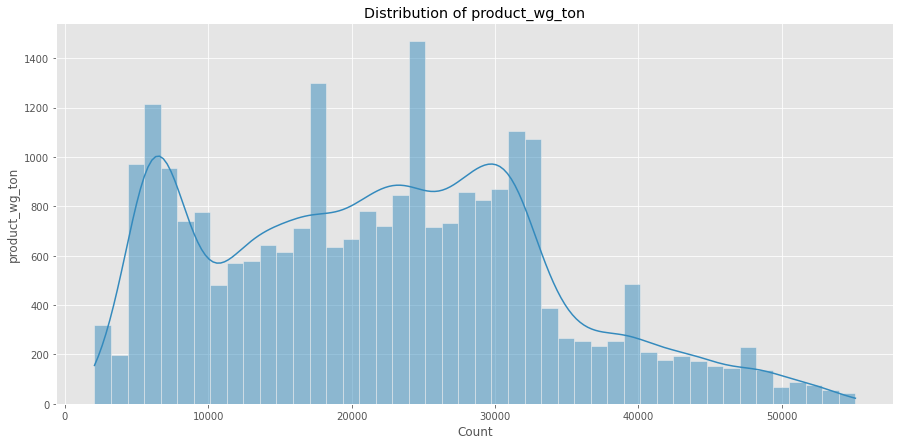

In [7]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df, x='product_wg_ton', kde=True)
print(df['product_wg_ton'].skew())
print(df['product_wg_ton'].kurt())
plt.title('Distribution of product_wg_ton')
plt.xlabel('Count')
plt.ylabel('product_wg_ton')
#plt.savefig("Product_Weight_Distribution.png")
plt.show()

Location_type
Rural    0.353371
Urban    0.197040
Name: product_wg_ton, dtype: float64
product_wg_ton   -0.50144
dtype: float64
product_wg_ton   -0.327452
dtype: float64


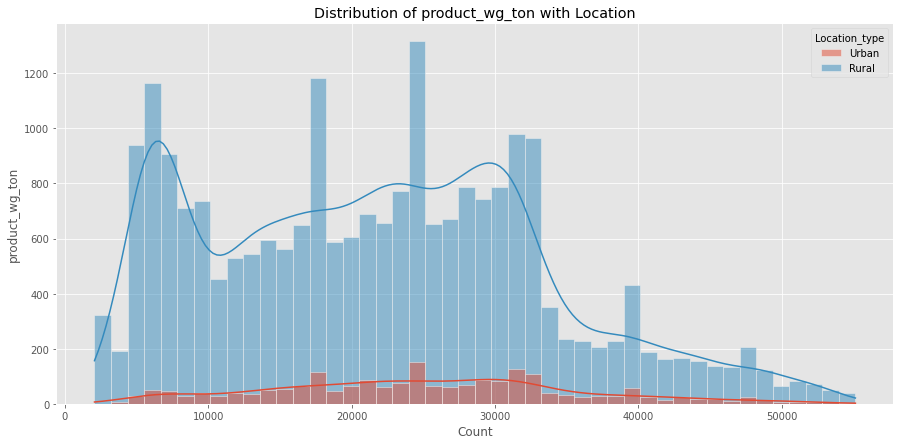

In [8]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df, x='product_wg_ton', hue='Location_type', kde=True)
print(df.groupby('Location_type')['product_wg_ton'].skew())
print(df.loc[(df['Location_type']=='Rural'), ['product_wg_ton']].kurt())
print(df.loc[(df['Location_type']=='Urban'), ['product_wg_ton']].kurt())
plt.title('Distribution of product_wg_ton with Location')
plt.xlabel('Count')
plt.ylabel('product_wg_ton')
#plt.savefig("Product_Weight_Distribution_wrt_Location.png")
plt.show()

In [13]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['product_wg_ton'].agg(['mean', 'median', 'count'])

mean   median  count
Location_type zone  WH_regional_zone                              
Rural         East  Zone 1            19509.108108  20059.0     37
                    Zone 3            22125.090000  22610.0    100
                    Zone 4            23214.030303  24132.0    132
                    Zone 5            23981.428571  26068.5     70
                    Zone 6            21375.232143  21106.5     56
              North Zone 1            21950.975827  21605.0    786
                    Zone 2            22028.320562  23065.0    783
                    Zone 3            21882.560780  22114.0    872
                    Zone 4            21716.166045  22103.5   1072
                    Zone 5            22012.028393  22083.0   1761
                    Zone 6            21842.173049  22059.5   4126
              South Zone 1            21391.212934  21136.0    634
                    Zone 2            22236.262064  22134.0   1347
                    Zone 3            21103.411548  21067.5    814
                    Zone 4            21528.919753  21131.0    810
                    Zone 5            21532.983301  21073.5   1018
                    Zone 6            22090.404610  22084.5   1258
              West  Zone 1            21274.880266  21068.0    451
                    Zone 2            22619.571192  22139.0    604
                    Zone 3            22310.394799  23061.5    846
                    Zone 4            21926.595424  22075.5   1792
                    Zone 5            21307.607743  21109.0   1369
                    Zone 6            21823.242902  22086.0   2219
Urban         East  Zone 1            25083.500000  24086.5      6
                    Zone 3            26181.250000  27078.5     12
                    Zone 4            24191.900000  23578.5     10
                    Zone 5            22343.500000  23108.5      4
                    Zone 6            38611.500000  38611.5      2
              North Zone 1            22048.436364  21134.0     55
                    Zone 2            24199.394366  22063.0     71
                    Zone 3            25327.438202  25079.0     89
                    Zone 4            26094.640351  25608.5    114
                    Zone 5            26473.929487  25597.0    156
                    Zone 6            25774.007634  26061.0    393
              South Zone 1            24366.021739  22111.5     46
                    Zone 2            25934.577320  25071.0     97
                    Zone 3            22985.098592  23057.0     71
                    Zone 4            24892.291667  26138.5     72
                    Zone 5            24641.797753  25149.0     89
                    Zone 6            23074.726415  23088.0    106
              West  Zone 1            26749.384615  25150.0     39
                    Zone 2            24333.049180  26136.0     61
                    Zone 3            22637.636364  23095.0     77
                    Zone 4            25932.241379  25066.5    174
                    Zone 5            25605.100000  26106.0    120
                    Zone 6            23664.793296  24130.0    179

In [6]:
df.groupby('Location_type')['Ware_house_ID'].count()

Location_type
Rural    22957
Urban     2043
Name: Ware_house_ID, dtype: int64

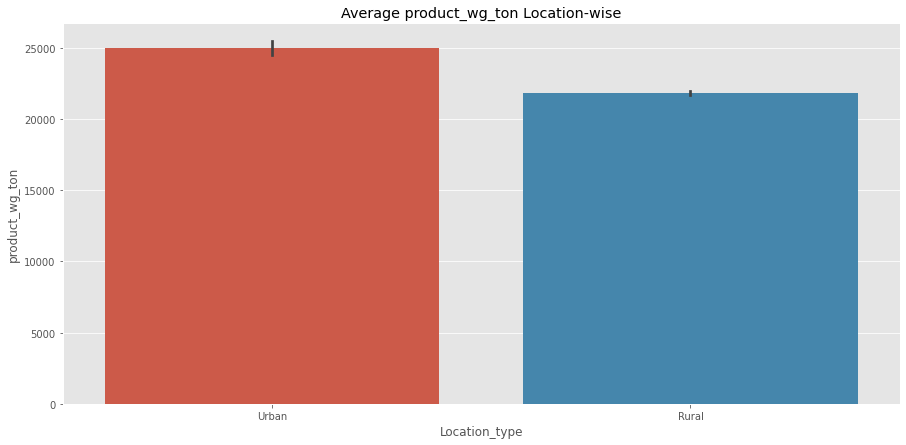

In [21]:
plt.figure(figsize=(15, 7))
sns.barplot(data=df, y='product_wg_ton', x='Location_type')
plt.show()

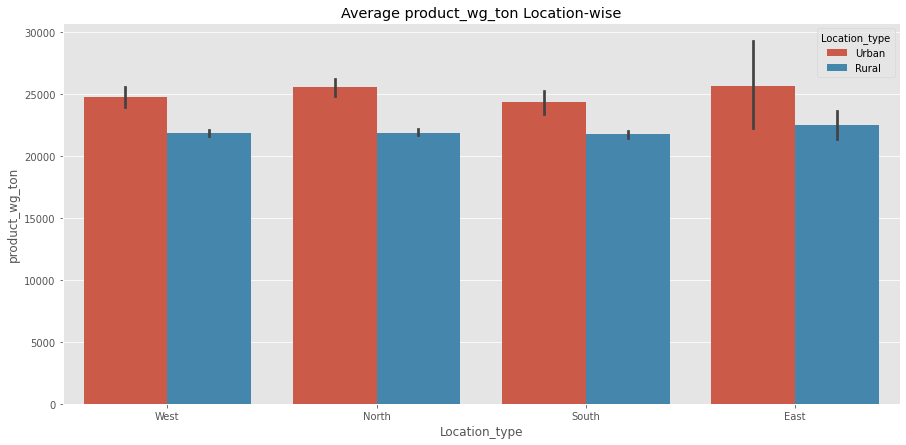

In [22]:
plt.figure(figsize=(15, 7))
sns.barplot(data=df, y='product_wg_ton', x='zone', hue='Location_type')
plt.show()

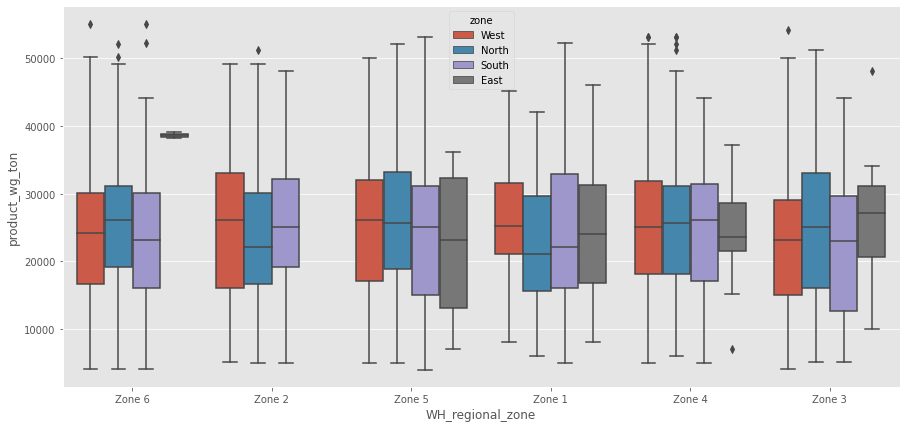

In [34]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=df.query("Location_type == 'Urban'"), x='WH_regional_zone', y='product_wg_ton', hue='zone')
plt.show()

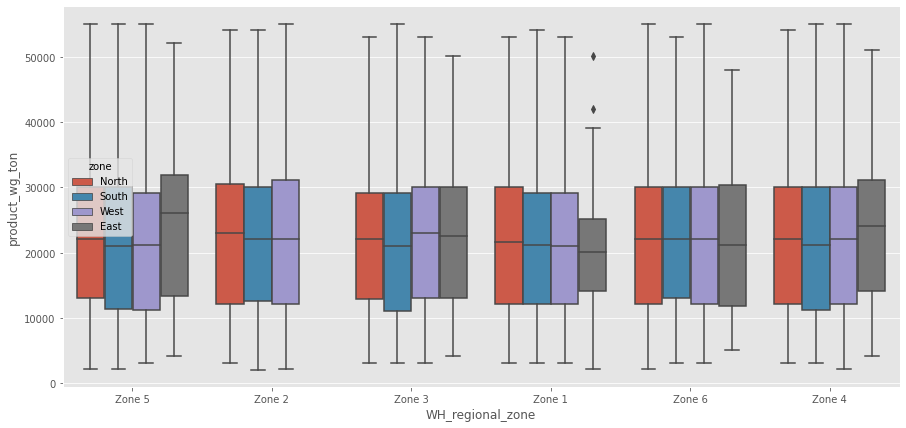

In [35]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=df.query("Location_type == 'Rural'"), x='WH_regional_zone', y='product_wg_ton', hue='zone')
plt.show()

In [9]:
df.loc[(df['Location_type'] == 'Rural') & (df['zone'] == 'East') & 
       (df['WH_regional_zone'] == 'Zone 1') & (df['product_wg_ton'] >= 35000), :]

Ware_house_ID WH_Manager_ID Location_type WH_capacity_size  zone  \
86        WH_100086     EID_50086         Rural            Small  East   
6557      WH_106557     EID_56557         Rural            Small  East   
15473     WH_115473     EID_65473         Rural            Small  East   

      WH_regional_zone  num_refill_req_l3m  transport_issue_l1y  \
86              Zone 1                   4                    0   
6557            Zone 1                   7                    0   
15473           Zone 1                   8                    0   

       Competitor_in_mkt  retail_shop_num  wh_owner_type  distributor_num  \
86                     4             4564  Company Owned               56   
6557                   2             6721  Company Owned               27   
15473                  2             3858  Company Owned               68   

       flood_impacted  flood_proof  electric_supply  dist_from_hub  \
86                  0            1                1            160   
6557                0            0                1             65   
15473               0            1                1            240   

       workers_num  wh_est_year  storage_issue_reported_l3m  temp_reg_mach  \
86            37.0       1996.0                          28              1   
6557          40.0       2000.0                          38              1   
15473         39.0       1998.0                          31              1   

      approved_wh_govt_certificate  wh_breakdown_l3m  govt_check_l3m  \
86                              A+                 5              31   
6557                            A+                 2              31   
15473                           A+                 3              31   

       product_wg_ton  
86              39115  
6557            50137  
15473           42090

<AxesSubplot:xlabel='Location_type,zone,WH_regional_zone'>

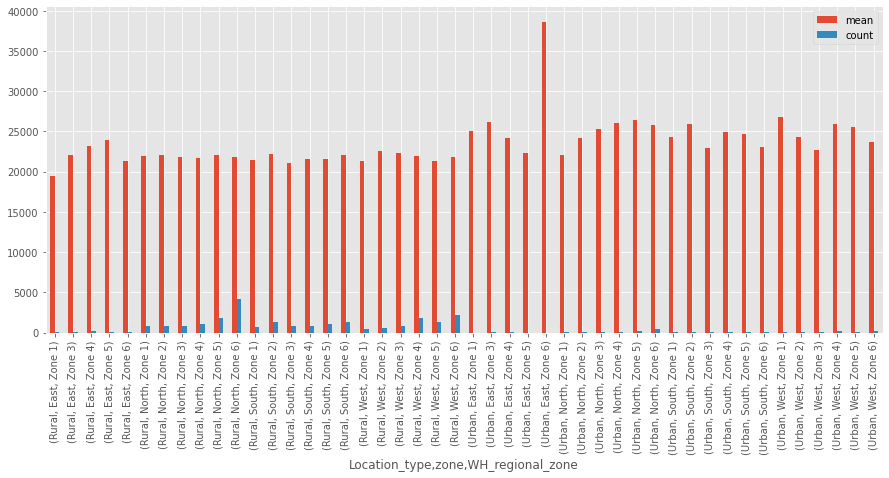

In [10]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['product_wg_ton'].agg(['mean', 'count']).plot(kind='bar',
                                                                                                        figsize=(15, 6))

<AxesSubplot:xlabel='Location_type,zone,WH_regional_zone'>

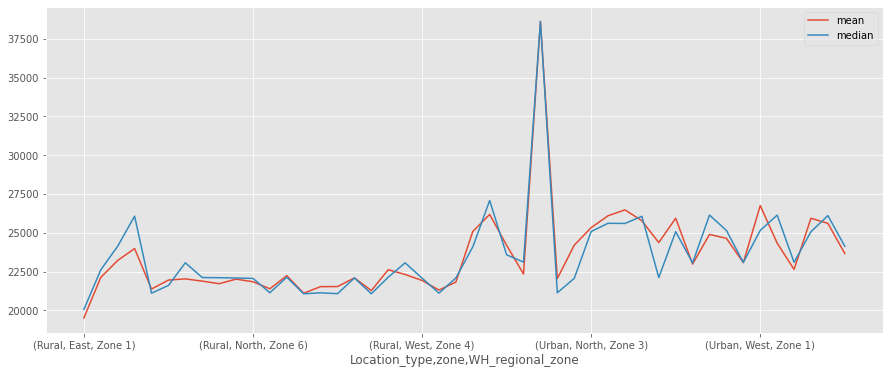

In [20]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['product_wg_ton'].agg(['mean', 'median']).plot(figsize=(15, 6))

In [11]:
df.loc[(df['Location_type'] == 'Urban') & (df['zone'] == 'East') & (df['WH_regional_zone'] == 'Zone 6'), :]

Ware_house_ID WH_Manager_ID Location_type WH_capacity_size  zone  \
5363     WH_105363     EID_55363         Urban            Small  East   
6925     WH_106925     EID_56925         Urban            Small  East   

     WH_regional_zone  num_refill_req_l3m  transport_issue_l1y  \
5363           Zone 6                   6                    0   
6925           Zone 6                   6                    0   

      Competitor_in_mkt  retail_shop_num wh_owner_type  distributor_num  \
5363                  4             6813        Rented               52   
6925                  4             5927        Rented               65   

      flood_impacted  flood_proof  electric_supply  dist_from_hub  \
5363               0            1                1            191   
6925               0            0                1            251   

      workers_num  wh_est_year  storage_issue_reported_l3m  temp_reg_mach  \
5363         26.0       2005.0                          31              0   
6925         38.0       2000.0                          29              0   

     approved_wh_govt_certificate  wh_breakdown_l3m  govt_check_l3m  \
5363                            B                 2              15   
6925                            C                 3              15   

      product_wg_ton  
5363           38151  
6925           39072

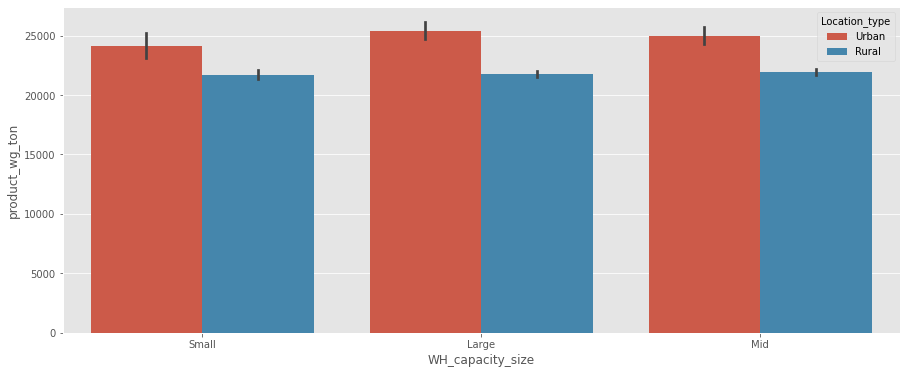

In [19]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='WH_capacity_size', y='product_wg_ton', hue='Location_type')
plt.show()

In [12]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone', 'WH_capacity_size'])['product_wg_ton'].agg(['mean', 'median','count']).sort_values(by='count', ascending=False)

mean   median  \
Location_type zone  WH_regional_zone WH_capacity_size                          
Rural         North Zone 6           Large             21781.424187  21147.0   
              West  Zone 4           Mid               21926.595424  22075.5   
              North Zone 5           Large             22012.028393  22083.0   
              West  Zone 6           Large             22047.808771  22116.0   
                    Zone 5           Large             21307.607743  21109.0   
              South Zone 2           Mid               22236.262064  22134.0   
              North Zone 4           Mid               21716.166045  22103.5   
              South Zone 5           Large             21532.983301  21073.5   
              North Zone 3           Mid               21882.560780  22114.0   
                    Zone 6           Small             22070.191244  22097.0   
              West  Zone 3           Mid               22310.394799  23061.5   
                    Zone 6           Small             21445.983092  21139.0   
              South Zone 3           Mid               21103.411548  21067.5   
                    Zone 4           Mid               21528.919753  21131.0   
                    Zone 6           Small             22049.216625  22081.5   
              North Zone 1           Small             21950.975827  21605.0   
                    Zone 2           Mid               22028.320562  23065.0   
              South Zone 1           Small             21391.212934  21136.0   
              West  Zone 2           Mid               22619.571192  22139.0   
              South Zone 6           Large             22160.885776  22098.5   
              West  Zone 1           Small             21274.880266  21068.0   
Urban         North Zone 6           Large             25980.577778  26094.0   
              West  Zone 4           Mid               25932.241379  25066.5   
              North Zone 5           Large             26473.929487  25597.0   
Rural         East  Zone 4           Mid               23214.030303  24132.0   
Urban         West  Zone 5           Large             25605.100000  26106.0   
              North Zone 4           Mid               26094.640351  25608.5   
              West  Zone 6           Large             23507.054545  24106.0   
Rural         East  Zone 3           Mid               22125.090000  22610.0   
Urban         South Zone 2           Mid               25934.577320  25071.0   
              North Zone 3           Mid               25327.438202  25079.0   
              South Zone 5           Large             24641.797753  25149.0   
              North Zone 6           Small             24939.782051  25101.0   
              West  Zone 3           Mid               22637.636364  23095.0   
              South Zone 4           Mid               24892.291667  26138.5   
                    Zone 3           Mid               22985.098592  23057.0   
              North Zone 2           Mid               24199.394366  22063.0   
Rural         East  Zone 5           Large             23981.428571  26068.5   
Urban         West  Zone 6           Small             23916.260870  24146.0   
              South Zone 6           Small             22715.548387  22094.5   
              West  Zone 2           Mid               24333.049180  26136.0   
Rural         East  Zone 6           Small             21375.232143  21106.5   
Urban         North Zone 1           Small             22048.436364  21134.0   
              South Zone 1           Small             24366.021739  22111.5   
                    Zone 6           Large             23580.840909  23637.5   
              West  Zone 1           Small             26749.384615  25150.0   
Rural         East  Zone 1           Small             19509.108108  20059.0   
Urban         East  Zone 3           Mid               26181.250000  27078.5   
                    Zone 4           Mid               24191.90

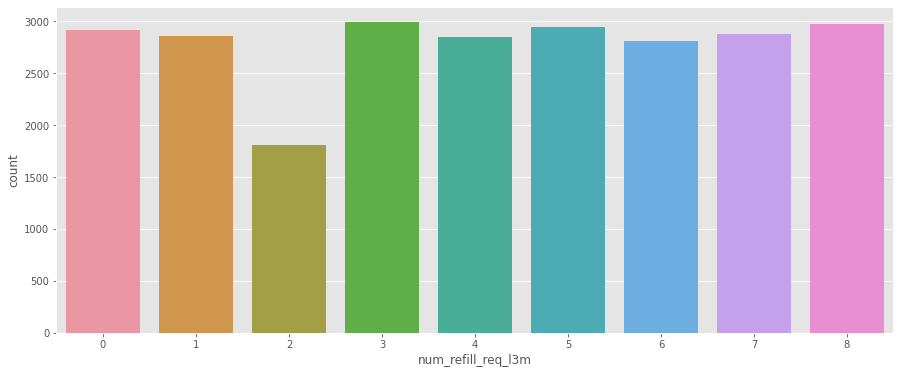

In [29]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='num_refill_req_l3m')
plt.show()

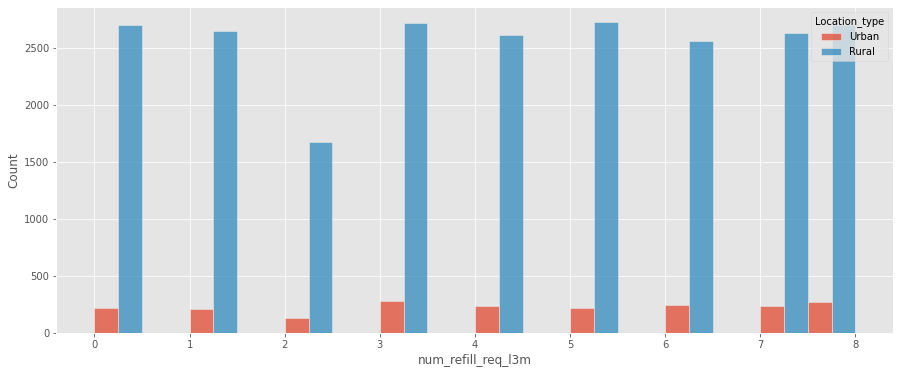

In [22]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='num_refill_req_l3m', hue='Location_type', multiple='dodge', binwidth=0.5)
plt.savefig('lt_zone_whz_nrrl3m_hist.png')
plt.show()

In [55]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['num_refill_req_l3m'].value_counts().nlargest(50)

Location_type  zone   WH_regional_zone  num_refill_req_l3m
Rural          North  Zone 6            3                     496
                                        8                     489
                                        1                     480
                                        0                     479
                                        5                     477
                                        4                     470
                                        7                     470
                                        6                     455
                                        2                     310
               West   Zone 6            5                     281
                                        7                     261
                                        8                     260
                                        3                     258
                                        6                     253
                 

In [56]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['num_refill_req_l3m'].value_counts().nsmallest(50)

Location_type  zone   WH_regional_zone  num_refill_req_l3m
Rural          East   Zone 1            5                     1
Urban          East   Zone 1            7                     1
                      Zone 3            2                     1
                                        5                     1
                      Zone 4            4                     1
                                        5                     1
                                        6                     1
                                        7                     1
                                        8                     1
                      Zone 5            2                     1
                                        6                     1
Rural          East   Zone 1            2                     2
                      Zone 6            2                     2
Urban          East   Zone 1            4                     2
                      Zone 3            1    

In [60]:
df.query("Location_type == 'Urban'").groupby(['zone', 'WH_regional_zone'])['num_refill_req_l3m'].value_counts().nlargest(50)

zone   WH_regional_zone  num_refill_req_l3m
North  Zone 6            3                     61
                         7                     51
                         8                     51
                         1                     50
                         6                     48
                         0                     39
                         5                     36
                         4                     35
West   Zone 4            8                     31
       Zone 6            4                     28
       Zone 4            6                     26
       Zone 6            1                     26
North  Zone 5            1                     24
                         3                     24
West   Zone 6            3                     24
North  Zone 5            8                     22
       Zone 6            2                     22
West   Zone 4            4                     22
       Zone 5            5                     22
      

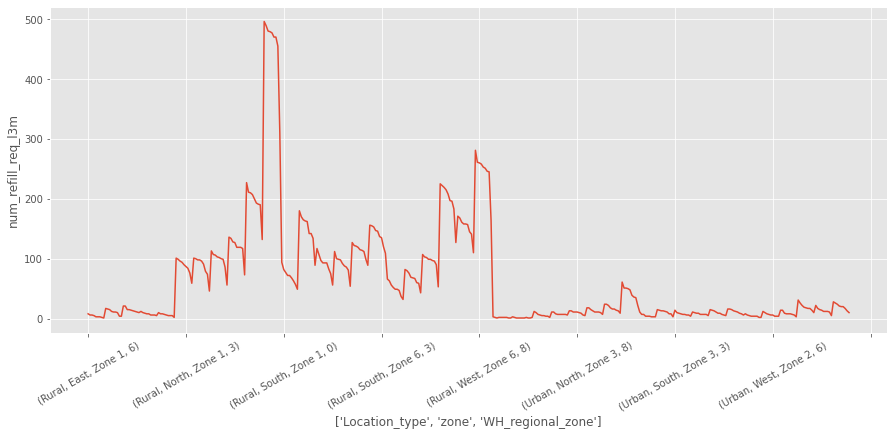

In [44]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['num_refill_req_l3m'].value_counts().plot(figsize=(15, 6))
plt.xticks(rotation=30)
plt.xlabel(['Location_type', 'zone', 'WH_regional_zone'])
plt.ylabel('num_refill_req_l3m')
plt.savefig('lt_zone_whz_nrrl3m.png')
plt.show()

In [8]:
df.groupby(['Location_type', 'WH_capacity_size', 'num_refill_req_l3m'])['product_wg_ton'].agg(['mean', 'median', 'count']).sort_values(ascending=False, by='mean')

mean   median  \
Location_type WH_capacity_size num_refill_req_l3m                          
Urban         Large            0                   28186.829268  28140.0   
              Small            5                   27645.272727  27086.0   
                               2                   25905.538462  29083.5   
              Large            3                   25723.660870  26087.0   
                               6                   25579.412371  26097.0   
                               7                   25551.551020  26098.0   
                               5                   25509.979167  27105.0   
              Mid              4                   25507.841121  25100.0   
                               0                   25451.417582  26092.0   
                               8                   25328.327273  25095.5   
                               3                   25293.269565  24128.0   
              Large            2                   25287.958333  27632.5   
              Mid              1                   25115.422535  24071.0   
              Small            8                   24995.244444  27150.0   
              Mid              6                   24698.355140  25079.0   
                               7                   24671.710000  24083.5   
              Large            1                   24602.745098  24080.5   
                               8                   24517.201754  23605.5   
              Small            1                   24352.432432  24143.0   
              Mid              2                   24306.500000  25599.0   
              Large            4                   24072.523256  24083.0   
              Mid              5                   24033.413793  23107.0   
              Small            4                   23916.340909  22116.5   
                               7                   23868.878049  25086.0   
                               6                   23556.613636  23625.0   
                               3                   22715.934783  22091.5   
Rural         Large            3                   22692.790000  23076.0   
              Small            4                   22415.544910  23056.0   
              Mid              3                   22412.845807  22136.0   
              Large            7                   22276.576923  22105.0   
              Mid              4                   22241.253333  23071.0   
                               7                   22122.507951  22110.0   
              Large            5                   22109.384821  21146.5   
              Mid              1                   22107.898734  22087.0   
              Small            8                   22096.060120  22138.0   
                               5                   22044.440520  22090.0   
              Mid              0                   21973.523423  22115.5   
                               6                   21882.833498  22137.0   
              Large            6                   21783.601914  22074.0   
                               1                   21780.692521  22068.0   
              Small            0                   21740.180113  22107.0   
              Mid              2                   21691.939444  22123.0   
              Small            6                   21598.814516  21077.0   
              Mid              5                   21573.270853  21102.0   
Urban         Small            0                   21568.512195  20111.0   
Rural         Small            1                   21556.897388  22082.0   
              Large            4                   21517.239130  21107.0   
                               8                   21486.385110  21086.0   
              Mid              8                   21406.914722  21123.5   
              Small            3                   21390.893069  21080.0   
                               7                   21360.637275  21055.0   
              Large            

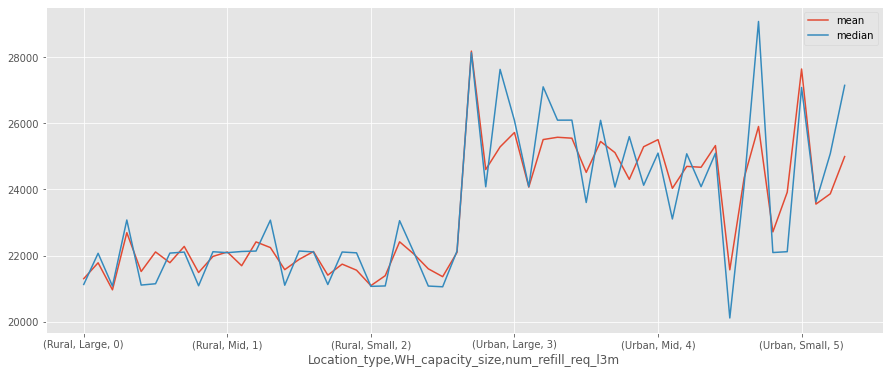

In [21]:
df.groupby(['Location_type', 'WH_capacity_size', 'num_refill_req_l3m'])['product_wg_ton'].agg(['mean',
                                                                                               'median']).plot(figsize=(15, 6))
plt.show()

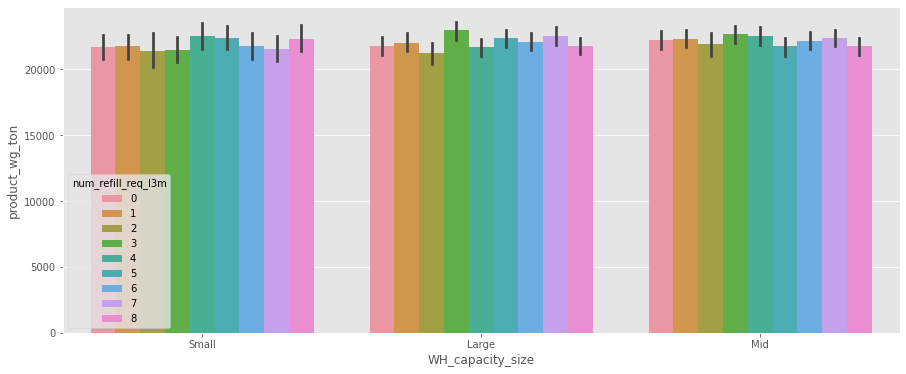

In [15]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='WH_capacity_size', y='product_wg_ton', hue='num_refill_req_l3m')
plt.show()

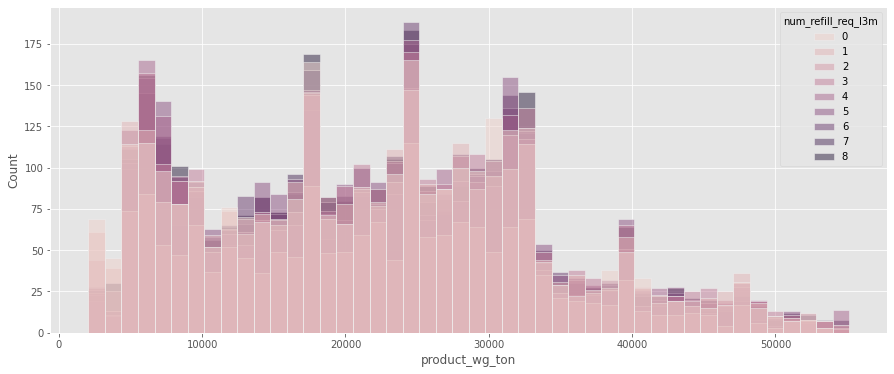

In [118]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, hue='num_refill_req_l3m', x='product_wg_ton')
plt.show()

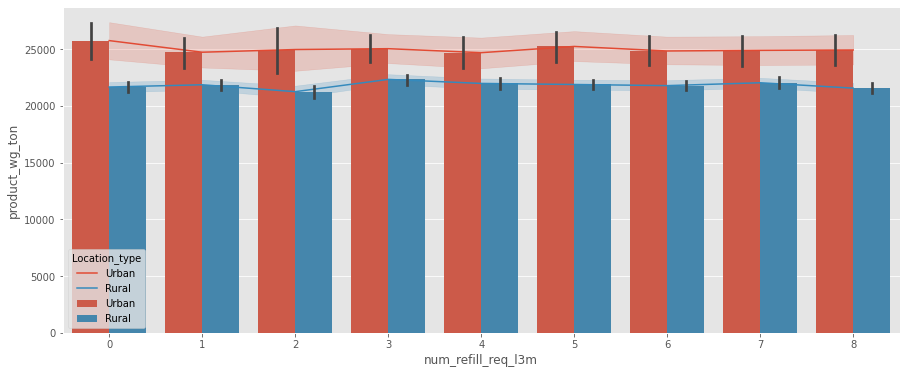

In [61]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='num_refill_req_l3m', y='product_wg_ton', hue='Location_type')
sns.barplot(data=df, x='num_refill_req_l3m', y='product_wg_ton', hue='Location_type')
#plt.savefig('num_refill_product_lt.png')
plt.show()

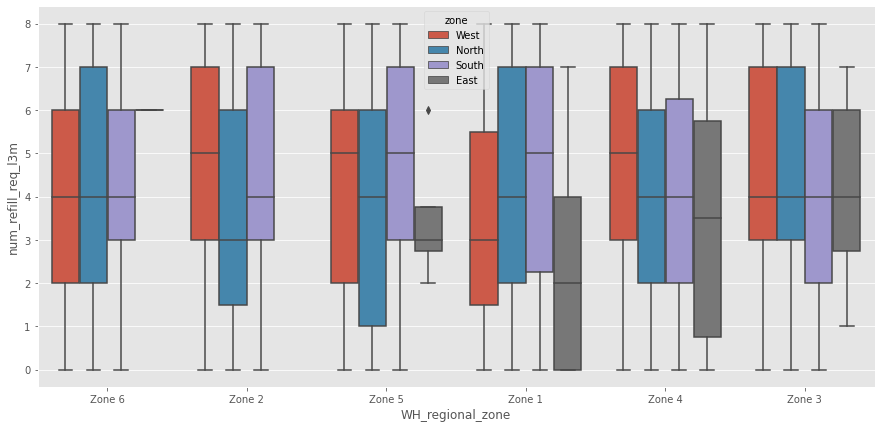

In [31]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=df.query("Location_type == 'Urban'"), x='WH_regional_zone', y='num_refill_req_l3m', hue='zone')
plt.show()

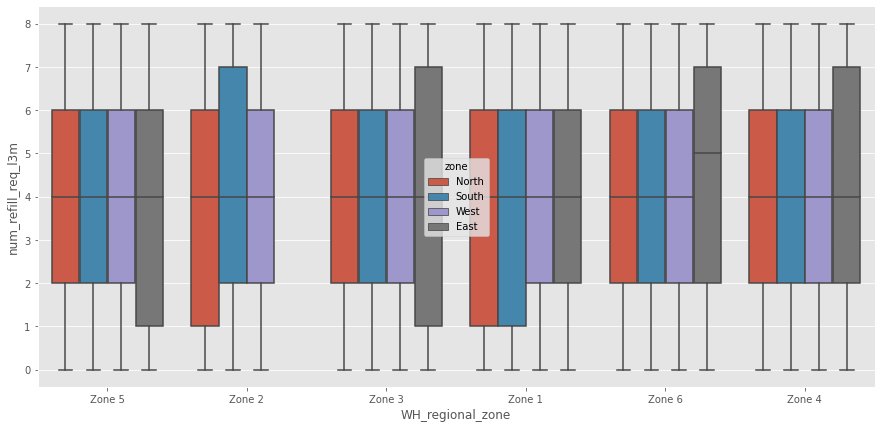

In [32]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=df.query("Location_type == 'Rural'"), x='WH_regional_zone', y='num_refill_req_l3m', hue='zone')
plt.show()

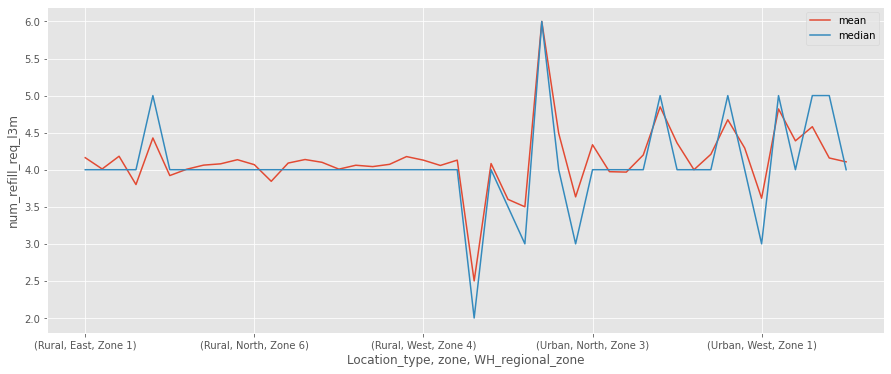

In [15]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['num_refill_req_l3m'].agg(['mean', 'median']).plot(figsize=(15, 6))
plt.show()

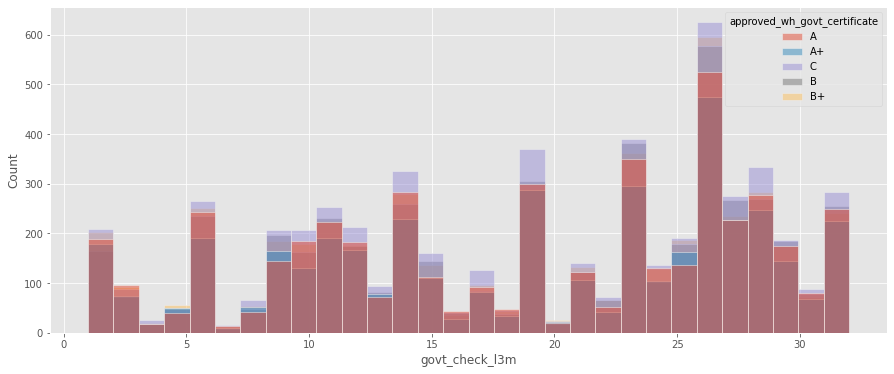

In [16]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='govt_check_l3m', hue='approved_wh_govt_certificate')
plt.show()

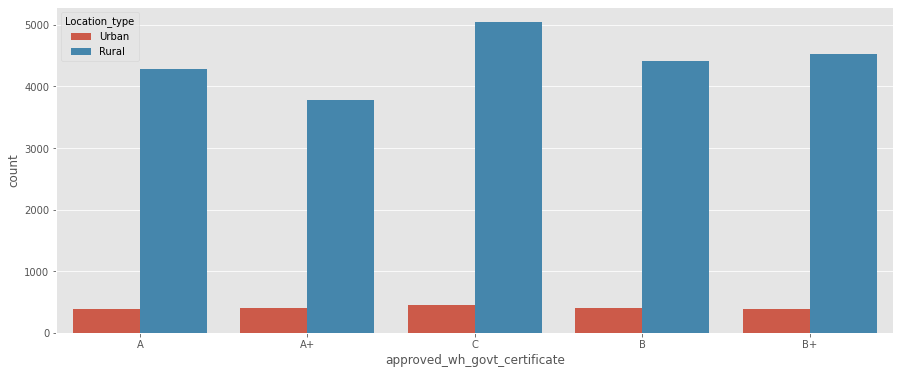

In [16]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='approved_wh_govt_certificate', hue='Location_type')
plt.savefig('location_awgc.png')
plt.show()

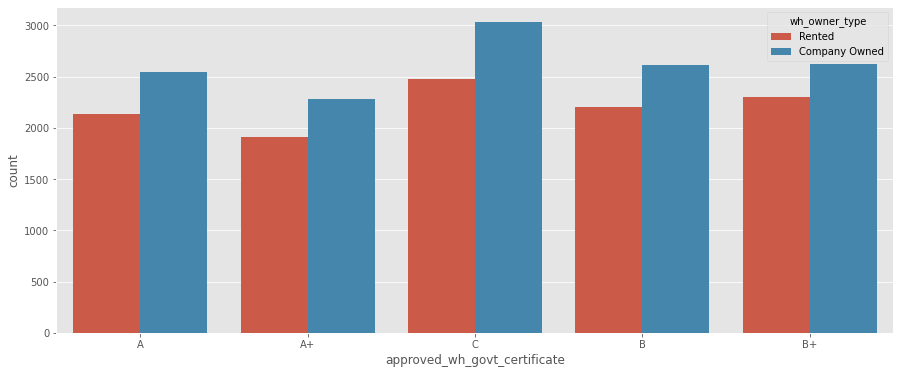

In [74]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='approved_wh_govt_certificate', hue='wh_owner_type')
plt.show()

In [ ]:
df

<AxesSubplot:xlabel='wh_owner_type'>

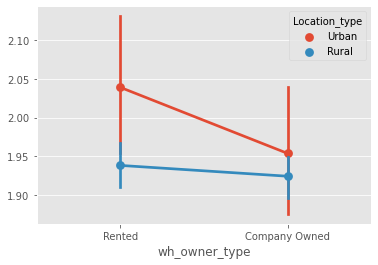

In [73]:
import seaborn as sns

sns.pointplot(data=df, y=pd.factorize(df['approved_wh_govt_certificate'])[0], x='wh_owner_type', hue='Location_type')

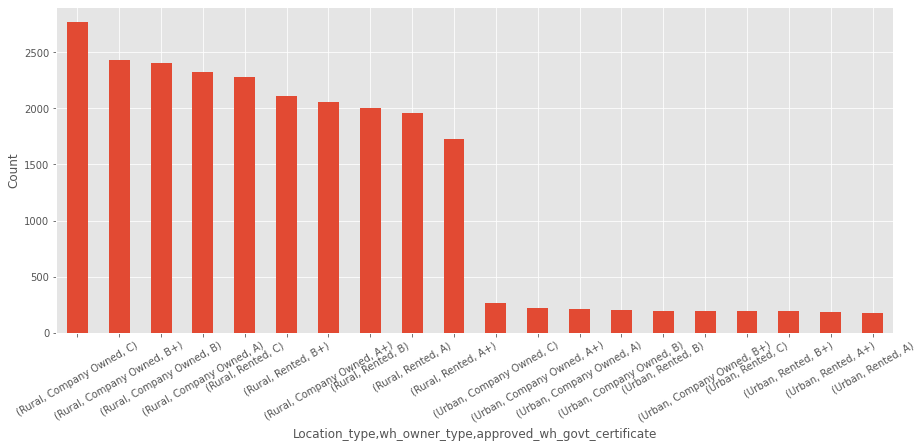

In [19]:
df.groupby('Location_type')[['wh_owner_type', 'approved_wh_govt_certificate']].value_counts().plot(kind='bar', figsize=(15, 6))
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.savefig('location_ot_awgc.png')
plt.show()

<AxesSubplot:xlabel='Location_type,zone,WH_regional_zone,WH_capacity_size'>

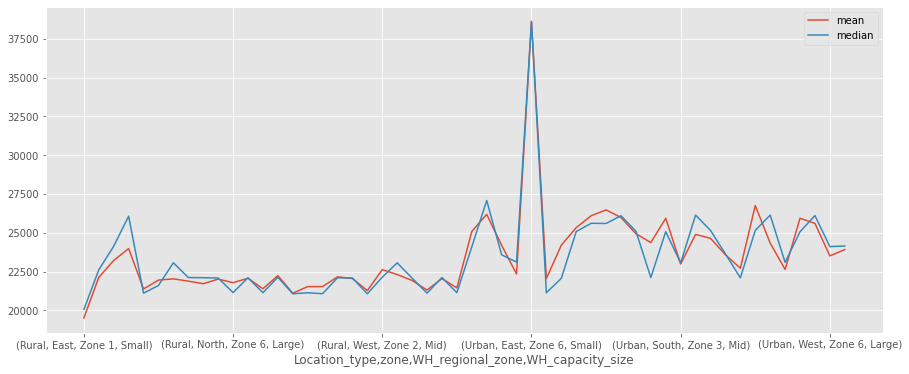

In [22]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone', 'WH_capacity_size'])['product_wg_ton'].agg(['mean', 
                                                                                                     'median']).plot(figsize=(15, 6))

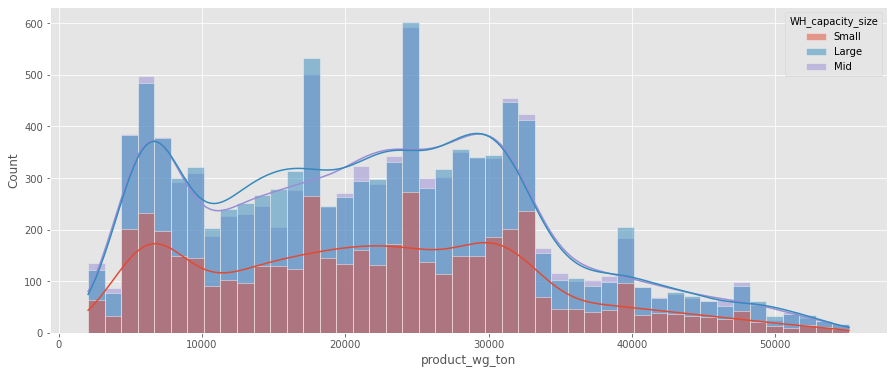

In [18]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='product_wg_ton', hue='WH_capacity_size', kde=True)
plt.show()

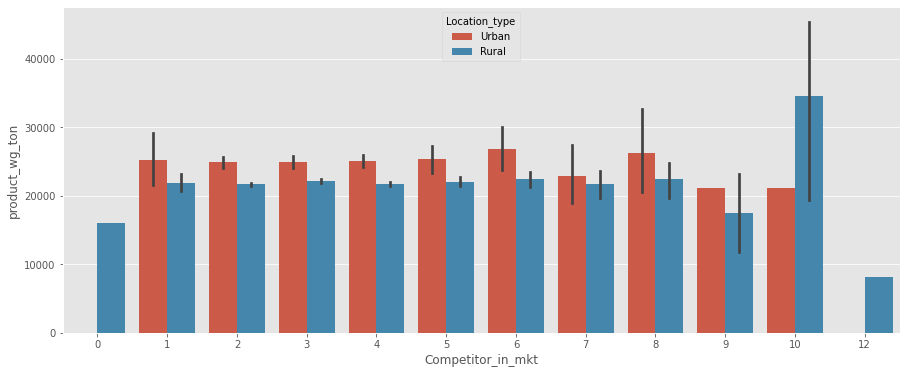

In [11]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='Competitor_in_mkt', y='product_wg_ton', hue='Location_type')
plt.savefig('comp_prod_lt.png')
plt.show()

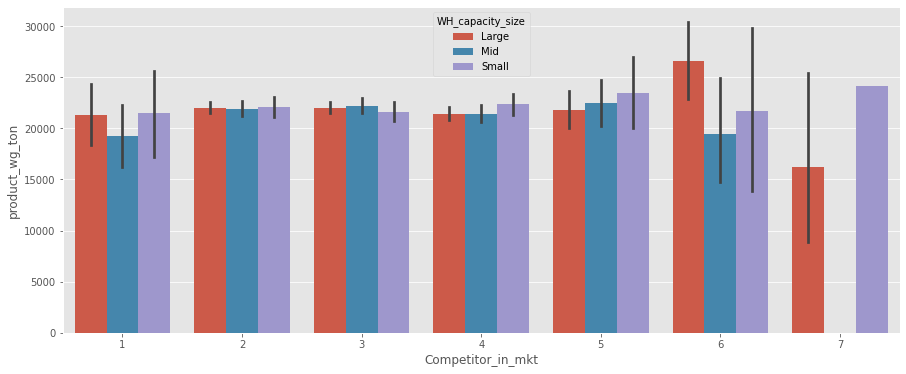

In [111]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Rural' & zone == 'North'"), x='Competitor_in_mkt', y='product_wg_ton', hue='WH_capacity_size')
plt.show()

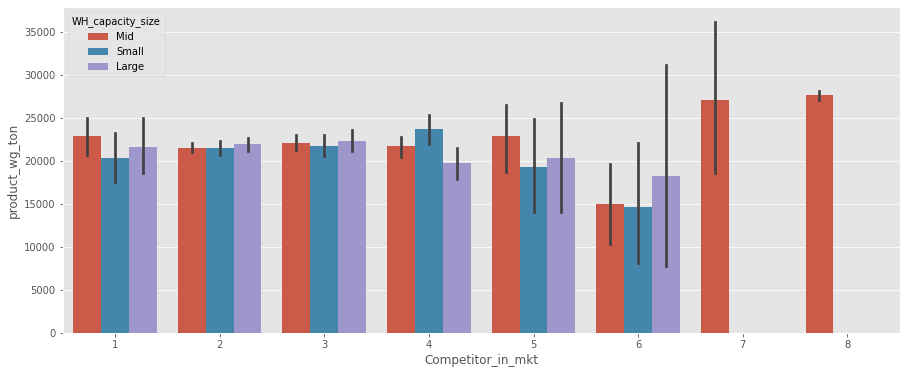

In [112]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Rural' & zone == 'South'"), x='Competitor_in_mkt', y='product_wg_ton', hue='WH_capacity_size')
plt.show()

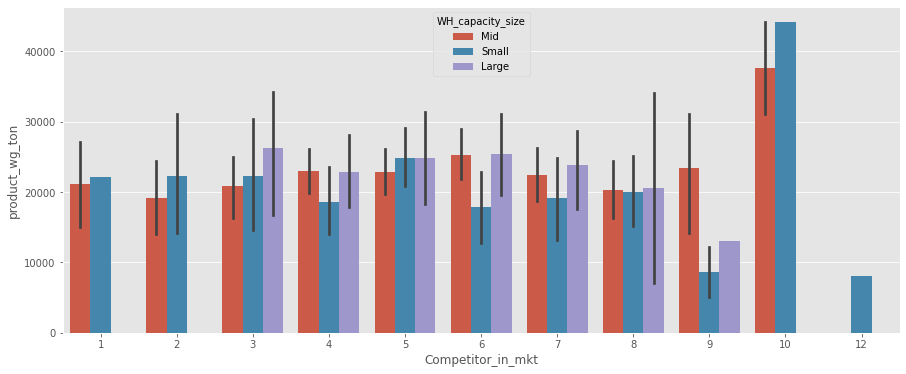

In [113]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Rural' & zone == 'East'"), x='Competitor_in_mkt', y='product_wg_ton', hue='WH_capacity_size')
plt.show()

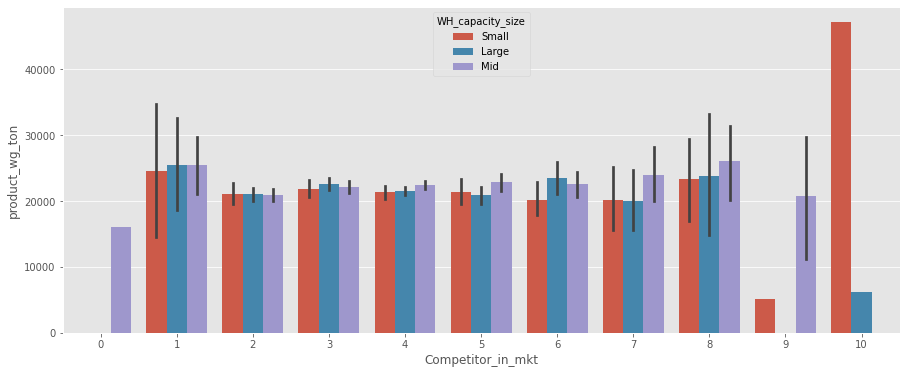

In [114]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Rural' & zone == 'West'"), x='Competitor_in_mkt', y='product_wg_ton', hue='WH_capacity_size')
plt.show()

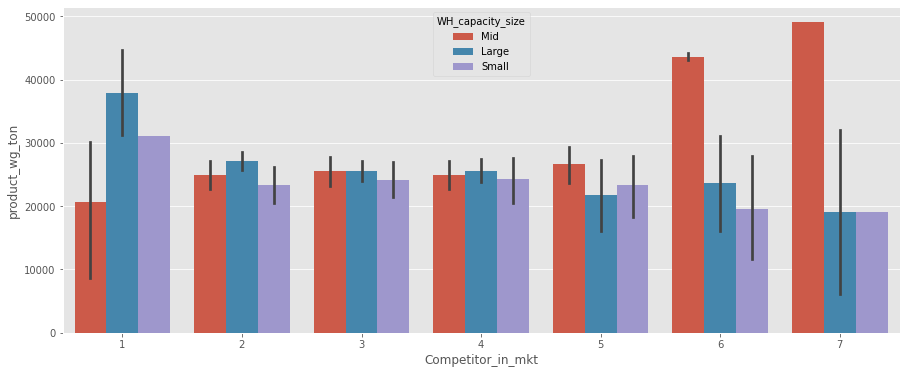

In [39]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Urban' & zone == 'North'"), x='Competitor_in_mkt', y='product_wg_ton', hue='WH_capacity_size')
plt.show()

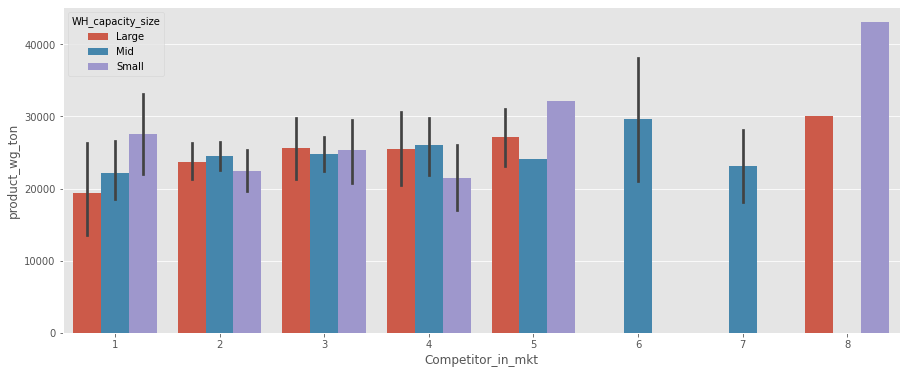

In [40]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Urban' & zone == 'South'"), x='Competitor_in_mkt', y='product_wg_ton', hue='WH_capacity_size')
plt.show()

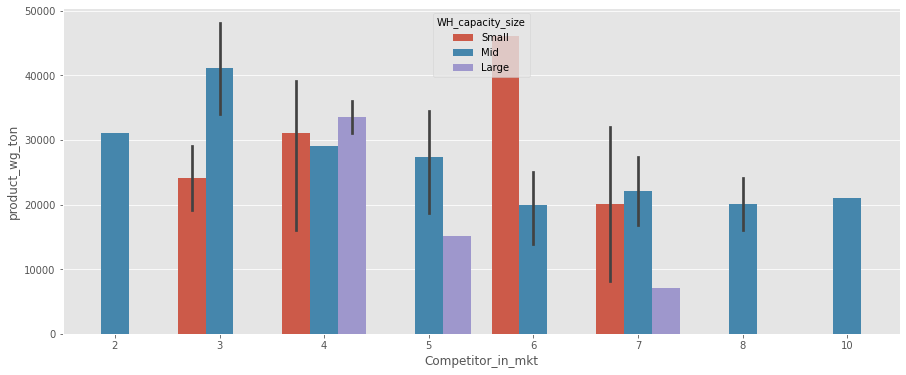

In [41]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Urban' & zone == 'East'"), x='Competitor_in_mkt', y='product_wg_ton', hue='WH_capacity_size')
plt.show()

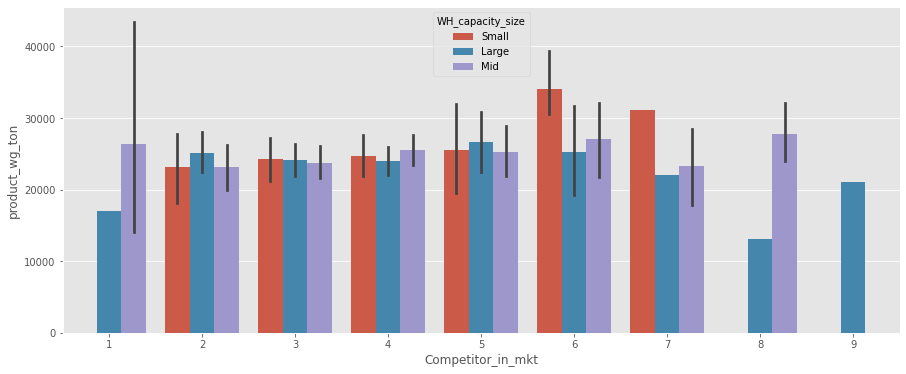

In [42]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Urban' & zone == 'West'"), x='Competitor_in_mkt', y='product_wg_ton', hue='WH_capacity_size')
plt.show()

In [8]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['Competitor_in_mkt'].agg(['mean', 'median', 'count']).sort_values(by='mean', ascending=False)

mean  median  count
Location_type zone  WH_regional_zone                         
Urban         East  Zone 4            6.400000     6.0     10
Rural         East  Zone 4            5.560606     5.5    132
                    Zone 6            5.250000     5.0     56
Urban         East  Zone 3            5.166667     5.5     12
Rural         East  Zone 5            5.057143     5.0     70
Urban         East  Zone 1            5.000000     5.0      6
                    Zone 5            5.000000     4.5      4
Rural         East  Zone 3            4.950000     5.0    100
                    Zone 1            4.864865     5.0     37
Urban         East  Zone 6            4.000000     4.0      2
              West  Zone 1            3.974359     4.0     39
                    Zone 3            3.922078     4.0     77
Rural         West  Zone 1            3.778271     4.0    451
Urban         West  Zone 4            3.775862     4.0    174
Rural         West  Zone 3            3.758865     4.0    846
                    Zone 6            3.698062     4.0   2219
Urban         West  Zone 6            3.636872     4.0    179
                    Zone 5            3.591667     4.0    120
Rural         West  Zone 4            3.541853     4.0   1792
                    Zone 5            3.491600     4.0   1369
                    Zone 2            3.460265     3.5    604
Urban         West  Zone 2            3.459016     4.0     61
              North Zone 1            3.090909     3.0     55
Rural         North Zone 1            3.049618     3.0    786
Urban         North Zone 3            3.033708     3.0     89
                    Zone 5            3.012821     3.0    156
Rural         North Zone 6            2.999031     3.0   4126
                    Zone 4            2.993470     3.0   1072
                    Zone 3            2.979358     3.0    872
                    Zone 2            2.966794     3.0    783
Urban         North Zone 2            2.943662     3.0     71
Rural         North Zone 5            2.934696     3.0   1761
Urban         North Zone 6            2.928753     3.0    393
                    Zone 4            2.868421     3.0    114
              South Zone 1            2.673913     2.0     46
                    Zone 2            2.659794     2.0     97
                    Zone 6            2.566038     2.0    106
Rural         South Zone 2            2.550111     2.0   1347
Urban         South Zone 5            2.539326     2.0     89
                    Zone 3            2.535211     2.0     71
                    Zone 4            2.527778     2.0     72
Rural         South Zone 6            2.510334     2.0   1258
                    Zone 3            2.500000     2.0    814
                    Zone 1            2.495268     2.0    634
                    Zone 4            2.481481     2.0    810
                    Zone 5            2.478389     2.0   1018

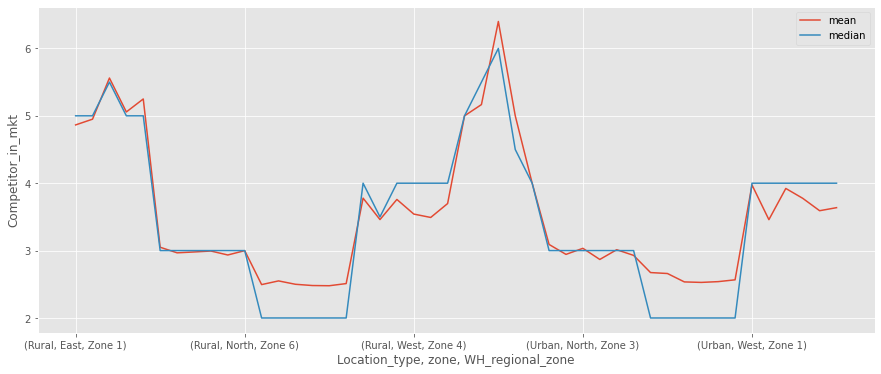

In [122]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['Competitor_in_mkt'].agg(['mean', 'median']).plot(figsize=(15, 6))
plt.show()

<AxesSubplot:xlabel='Location_type,zone,WH_regional_zone,Competitor_in_mkt'>

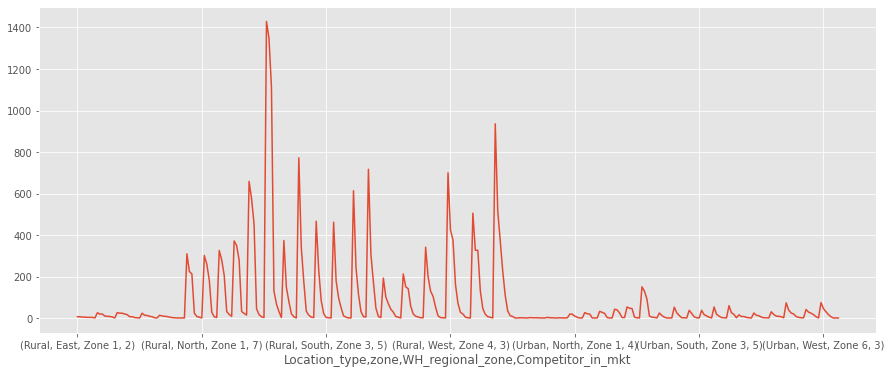

In [102]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['Competitor_in_mkt'].value_counts().plot(figsize=(15, 6))

In [89]:
df.loc[df['Competitor_in_mkt'] == 0, :]

Ware_house_ID WH_Manager_ID Location_type WH_capacity_size  zone  \
6813     WH_106813     EID_56813         Rural              Mid  West   

     WH_regional_zone  num_refill_req_l3m  transport_issue_l1y  \
6813           Zone 4                   7                    0   

      Competitor_in_mkt  retail_shop_num  wh_owner_type  distributor_num  \
6813                  0             3469  Company Owned               51   

      flood_impacted  flood_proof  electric_supply  dist_from_hub  \
6813               0            0                1            173   

      workers_num  wh_est_year  storage_issue_reported_l3m  temp_reg_mach  \
6813         31.0       1999.0                          14              0   

     approved_wh_govt_certificate  wh_breakdown_l3m  govt_check_l3m  \
6813                           B+                 3              26   

      product_wg_ton  
6813           16056

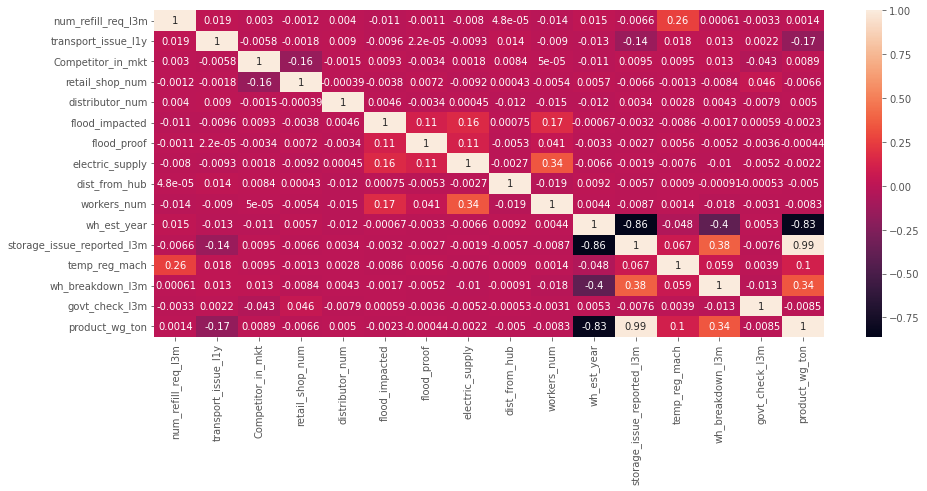

In [12]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.corr(), annot=True)
plt.savefig('heatmap.png')
plt.show()

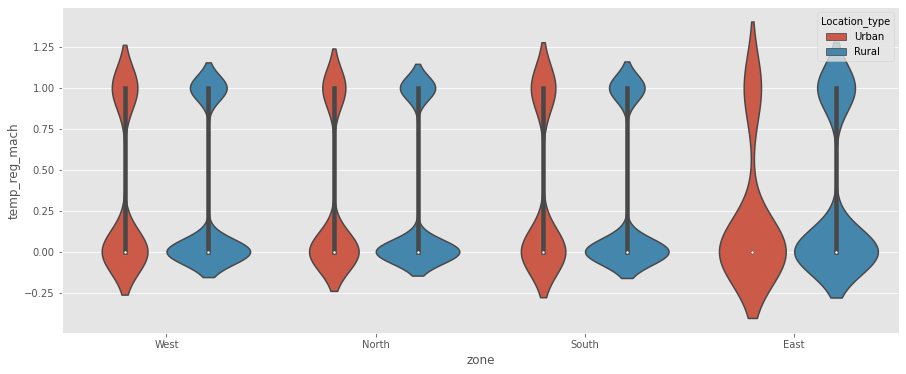

In [20]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=df, y='temp_reg_mach', x='zone', hue='Location_type')
plt.savefig('temp_reg_zone_lt.png')
plt.show()

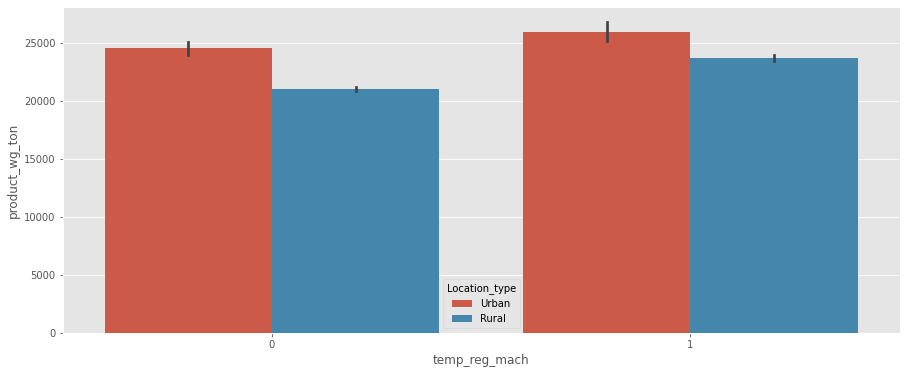

In [13]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='temp_reg_mach', y='product_wg_ton', hue='Location_type')
plt.show()

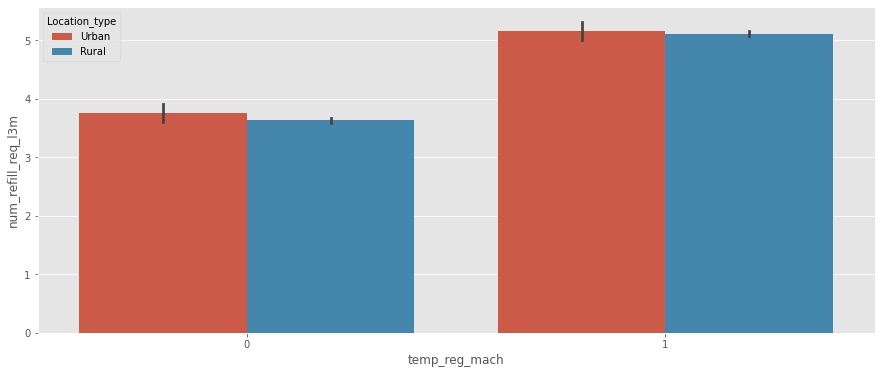

In [23]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='temp_reg_mach', y='num_refill_req_l3m', hue='Location_type')
plt.show()

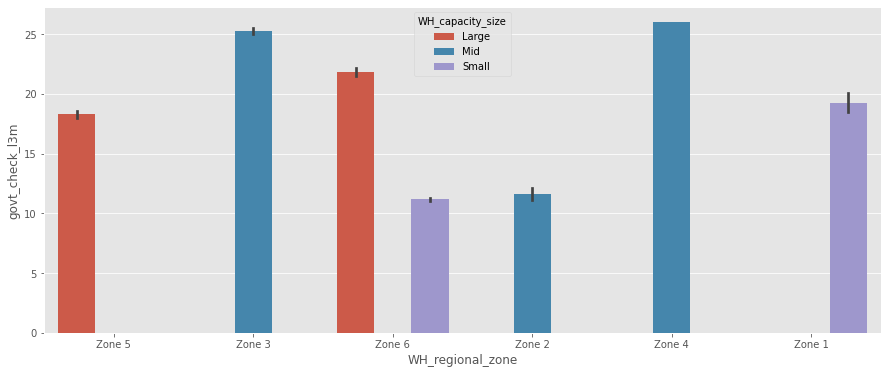

In [143]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Rural' & zone == 'North'"), x='WH_regional_zone', 
            y='govt_check_l3m', hue='WH_capacity_size')
plt.show()

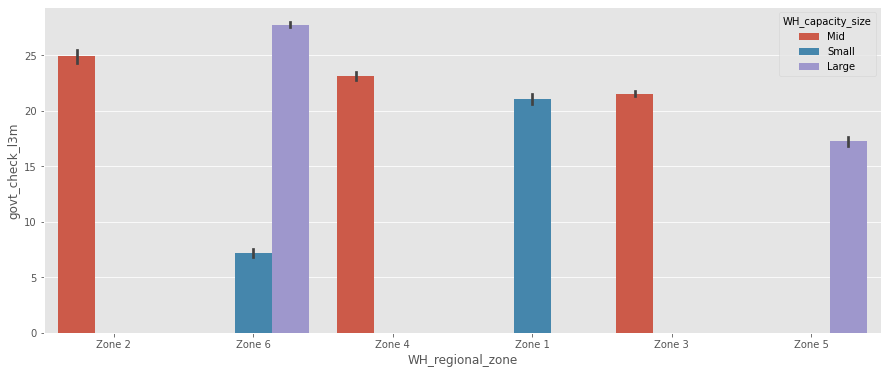

In [138]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Rural' & zone == 'South'"), x='WH_regional_zone', y='govt_check_l3m', hue='WH_capacity_size')
plt.show()

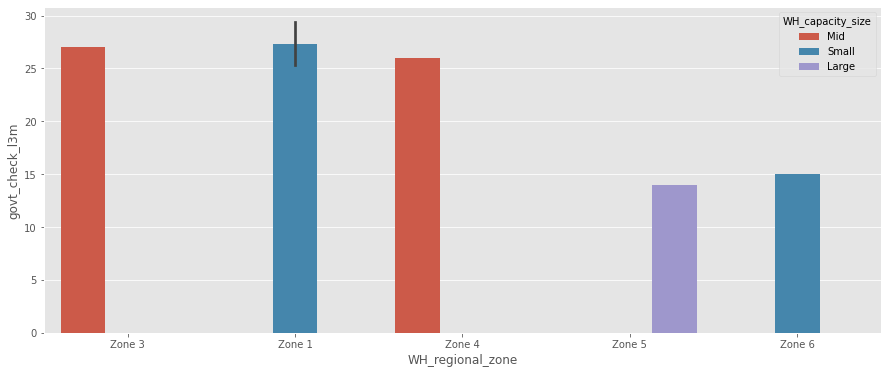

In [139]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Rural' & zone == 'East'"), x='WH_regional_zone', y='govt_check_l3m', hue='WH_capacity_size')
plt.show()

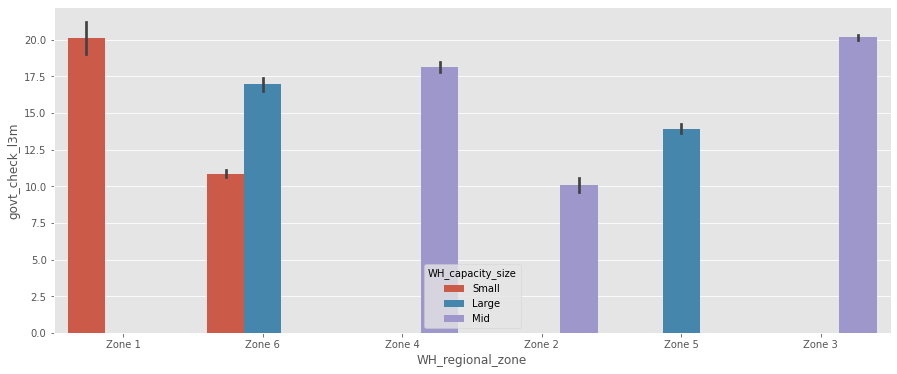

In [140]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Rural' & zone == 'West'"), x='WH_regional_zone', y='govt_check_l3m', hue='WH_capacity_size')
plt.show()

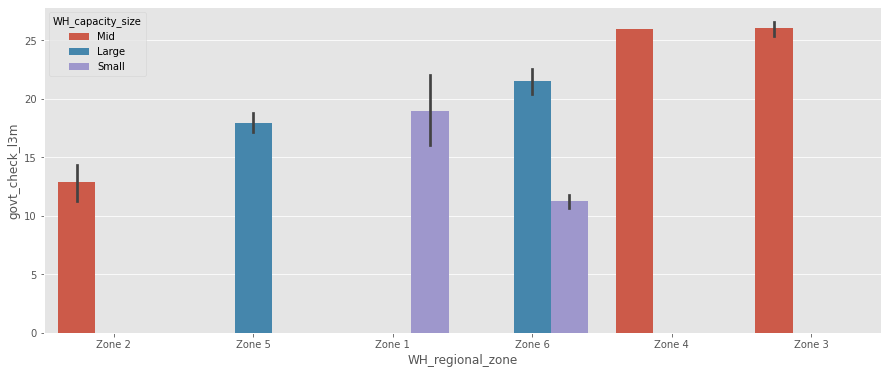

In [35]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Urban' & zone == 'North'"), x='WH_regional_zone', 
            y='govt_check_l3m', hue='WH_capacity_size')
plt.show()

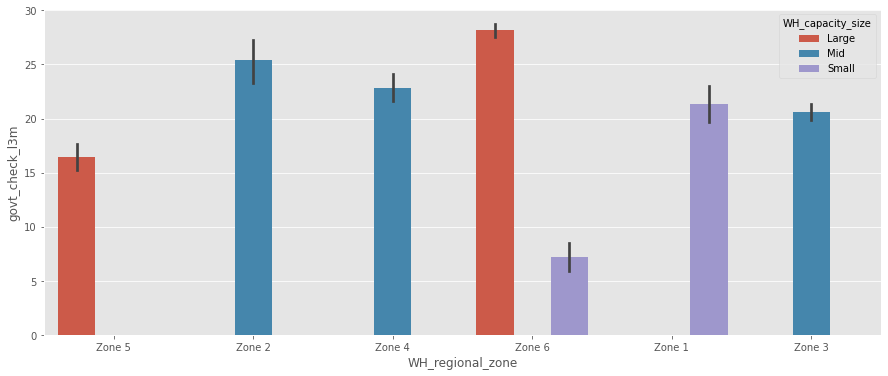

In [36]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Urban' & zone == 'South'"), x='WH_regional_zone', 
            y='govt_check_l3m', hue='WH_capacity_size')
plt.show()

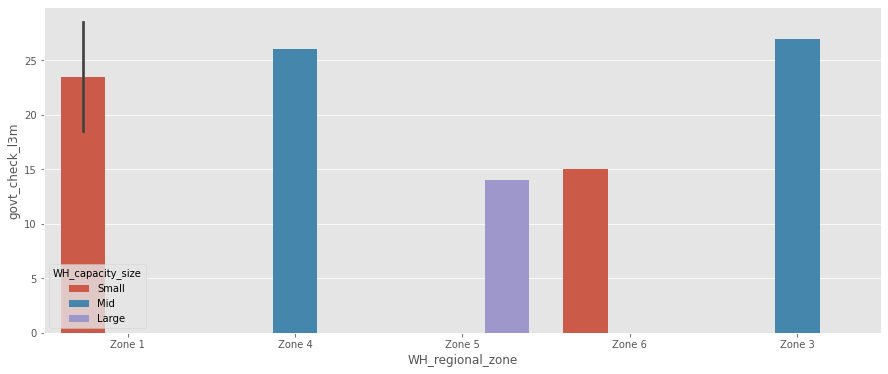

In [37]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Urban' & zone == 'East'"), x='WH_regional_zone', 
            y='govt_check_l3m', hue='WH_capacity_size')
plt.show()

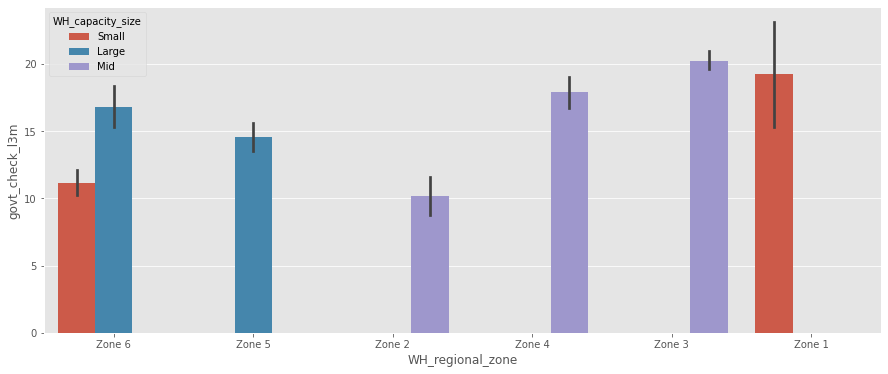

In [38]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Urban' & zone == 'West'"), x='WH_regional_zone', 
            y='govt_check_l3m', hue='WH_capacity_size')
plt.show()

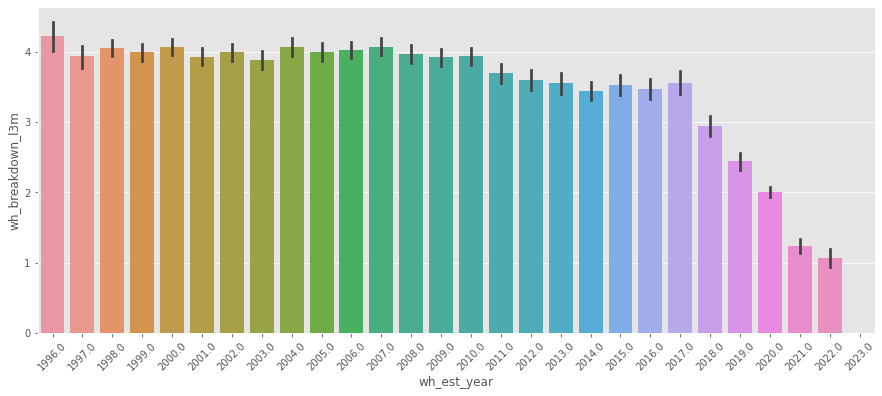

In [27]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='wh_est_year', y='wh_breakdown_l3m')
plt.xticks(rotation=45)
plt.savefig('breakdown_year.png')
plt.show()

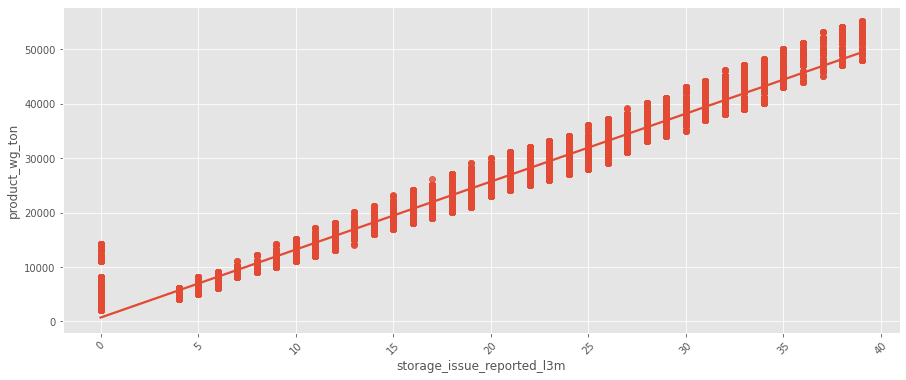

In [34]:
plt.figure(figsize=(15, 6))
sns.regplot(data=df, x='storage_issue_reported_l3m', y='product_wg_ton')
plt.xticks(rotation=45)
plt.show()

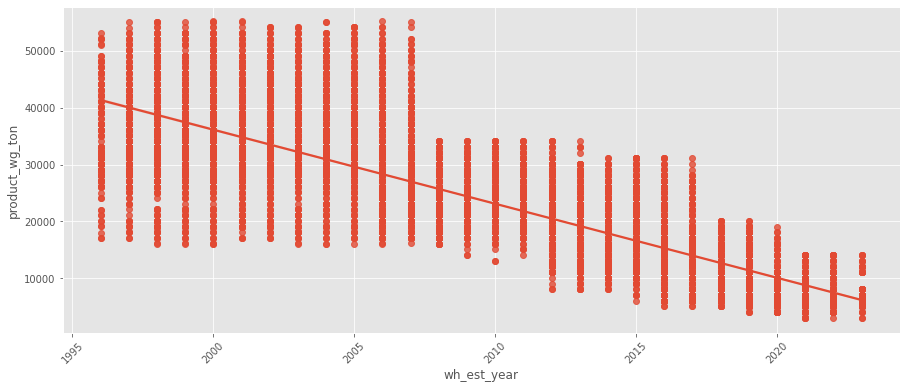

In [36]:
plt.figure(figsize=(15, 6))
sns.regplot(data=df, x='wh_est_year', y='product_wg_ton')
plt.xticks(rotation=45)
plt.show()

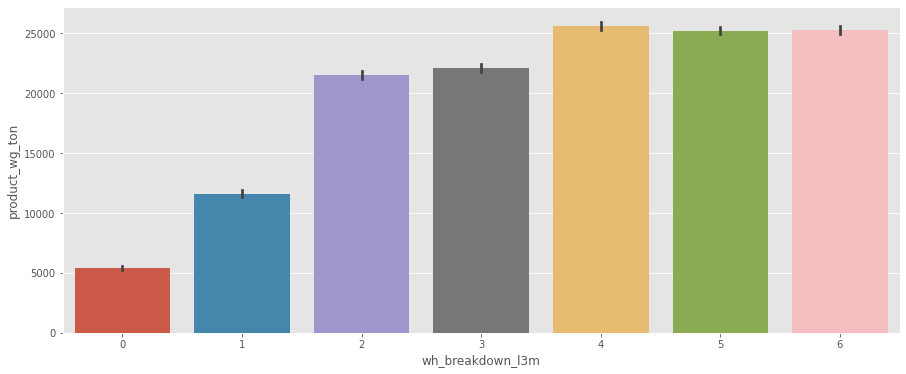

In [10]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='wh_breakdown_l3m', y='product_wg_ton')
plt.savefig('wh_breakdown_prodct_wg.png')
plt.show()

In [18]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])[['wh_breakdown_l3m', 'product_wg_ton']].agg(['mean', 'median'])

wh_breakdown_l3m        product_wg_ton  \
                                                 mean median           mean   
Location_type zone  WH_regional_zone                                          
Rural         East  Zone 1                   3.567568    3.0   19509.108108   
                    Zone 3                   3.570000    4.0   22125.090000   
                    Zone 4                   3.484848    3.0   23214.030303   
                    Zone 5                   3.642857    3.5   23981.428571   
                    Zone 6                   3.392857    3.0   21375.232143   
              North Zone 1                   3.459288    3.0   21950.975827   
                    Zone 2                   3.430396    3.0   22028.320562   
                    Zone 3                   3.532110    3.0   21882.560780   
                    Zone 4                   3.351679    3.0   21716.166045   
                    Zone 5                   3.465645    3.0   22012.028393   
                    Zone 6                   3.432380    3.0   21842.173049   
              South Zone 1                   3.399054    3.0   21391.212934   
                    Zone 2                   3.479584    3.0   22236.262064   
                    Zone 3                   3.395577    3.0   21103.411548   
                    Zone 4                   3.450617    3.0   21528.919753   
                    Zone 5                   3.472495    3.0   21532.983301   
                    Zone 6                   3.434022    3.0   22090.404610   
              West  Zone 1                   3.436807    3.0   21274.880266   
                    Zone 2                   3.392384    3.0   22619.571192   
                    Zone 3                   3.536643    3.0   22310.394799   
                    Zone 4                   3.545759    3.0   21926.595424   
                    Zone 5                   3.447042    3.0   21307.607743   
                    Zone 6                   3.484903    3.0   21823.242902   
Urban         East  Zone 1                   2.666667    2.0   25083.500000   
                    Zone 3                   4.166667    4.5   26181.250000   
                    Zone 4                   3.700000    3.5   24191.900000   
                    Zone 5                   3.250000    3.0   22343.500000   
                    Zone 6                   2.500000    2.5   38611.500000   
              North Zone 1                   3.745455    3.0   22048.436364   
                    Zone 2                   3.718310    3.0   24199.394366   
                    Zone 3                   3.640449    4.0   25327.438202   
                    Zone 4                   3.877193    4.0   26094.640351   
                    Zone 5                   3.711538    3.5   26473.929487   
                    Zone 6                   3.697201    4.0   25774.007634   
              South Zone 1                   3.869565    3.5   24366.021739   
                    Zone 2                   3.835052    4.0   25934.577320   
                    Zone 3                   3.760563    4.0   22985.098592   
                    Zone 4                   3.722222    3.5   24892.291667   
                    Zone 5                   3.797753    4.0   24641.797753   
                    Zone 6                   3.547170    3.0   23074.726415   
              West  Zone 1                   3.846154    4.0   26749.384615   
                    Zone 2                   3.770492    3.0   24333.049180   
                    Zone 3                   3.935065    4.0   22637.636364   
                    Zone 4                   3.821839    4.0   25932.241379   
                    Zone 5                   3.883333    4.0   25605.100000   
                    Zone 6                   3.681564    4.0   23664.793296   

                                               
                                       median  
Location_type zone  WH_regional_zone           
Rural         East  Z

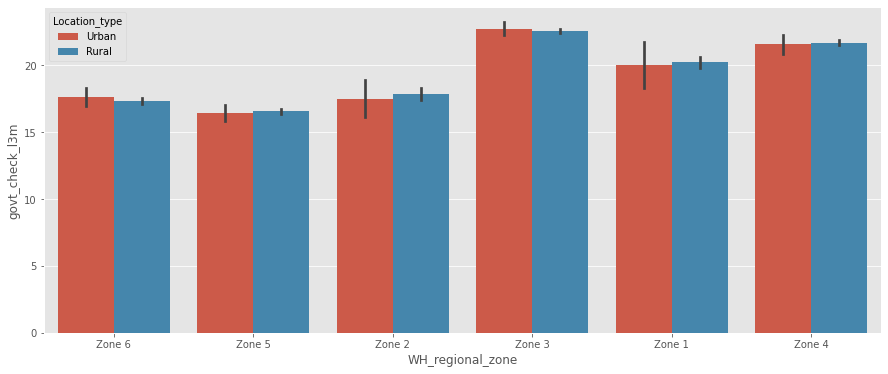

In [11]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='WH_regional_zone', y='govt_check_l3m', hue='Location_type')
plt.savefig('regional_zone_govt_check.png')
plt.show()

<AxesSubplot:xlabel='WH_regional_zone', ylabel='govt_check_l3m'>

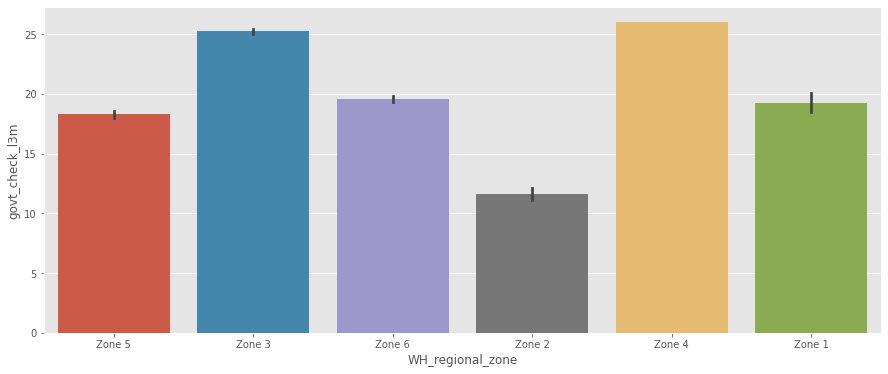

In [27]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Rural' & zone == 'North'"), x='WH_regional_zone', y='govt_check_l3m')

<AxesSubplot:xlabel='WH_regional_zone', ylabel='govt_check_l3m'>

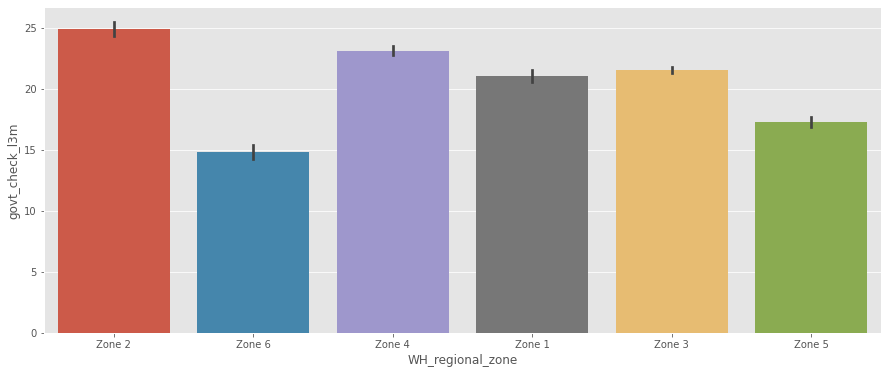

In [28]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Rural' & zone == 'South'"), x='WH_regional_zone', y='govt_check_l3m')

<AxesSubplot:xlabel='WH_regional_zone', ylabel='govt_check_l3m'>

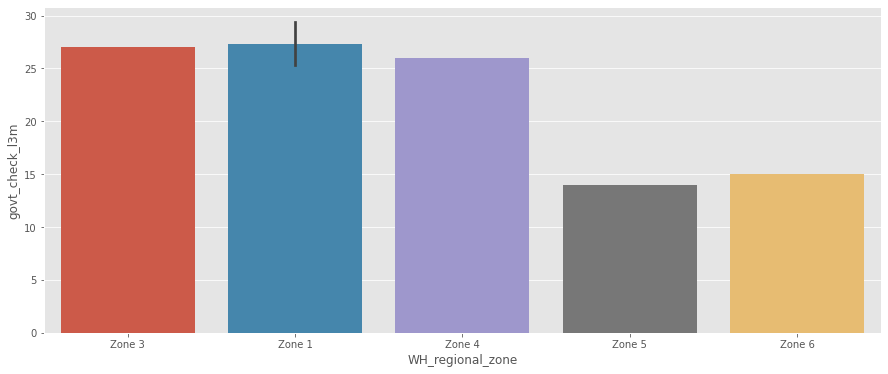

In [29]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Rural' & zone == 'East'"), x='WH_regional_zone', y='govt_check_l3m')

<AxesSubplot:xlabel='WH_regional_zone', ylabel='govt_check_l3m'>

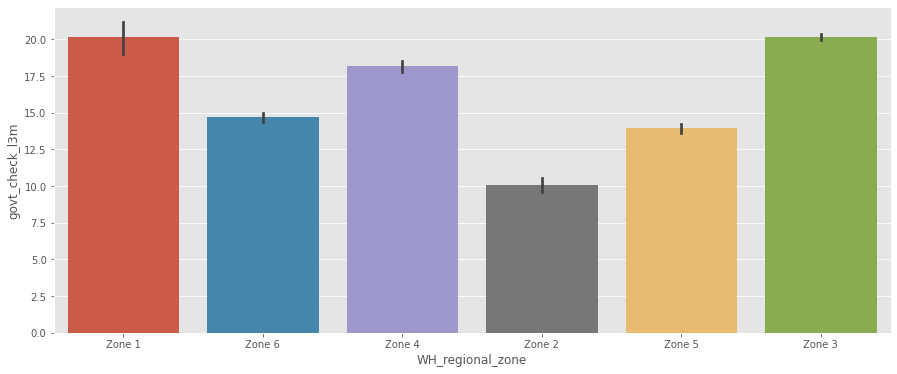

In [30]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Rural' & zone == 'West'"), x='WH_regional_zone', y='govt_check_l3m')

<AxesSubplot:xlabel='WH_regional_zone', ylabel='govt_check_l3m'>

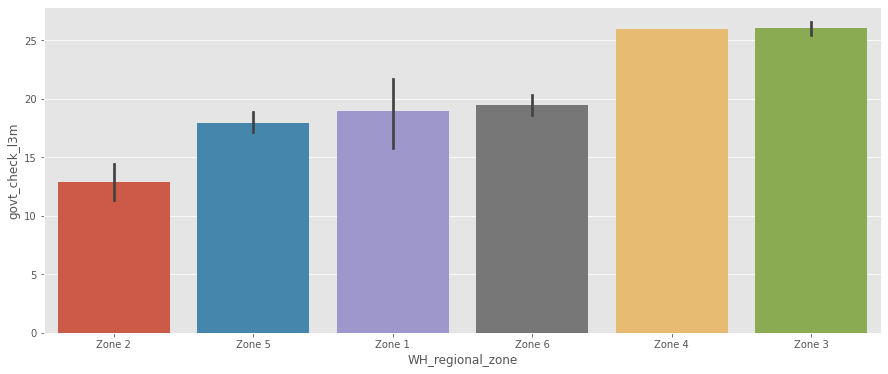

In [31]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Urban' & zone == 'North'"), x='WH_regional_zone', y='govt_check_l3m')

<AxesSubplot:xlabel='WH_regional_zone', ylabel='govt_check_l3m'>

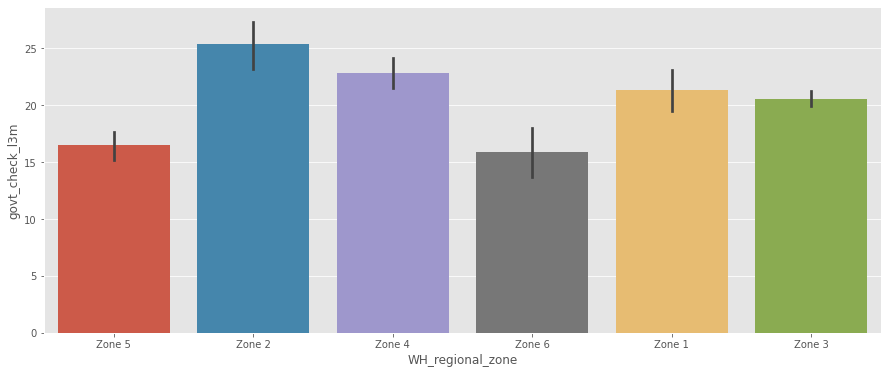

In [32]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Urban' & zone == 'South'"), x='WH_regional_zone', y='govt_check_l3m')

<AxesSubplot:xlabel='WH_regional_zone', ylabel='govt_check_l3m'>

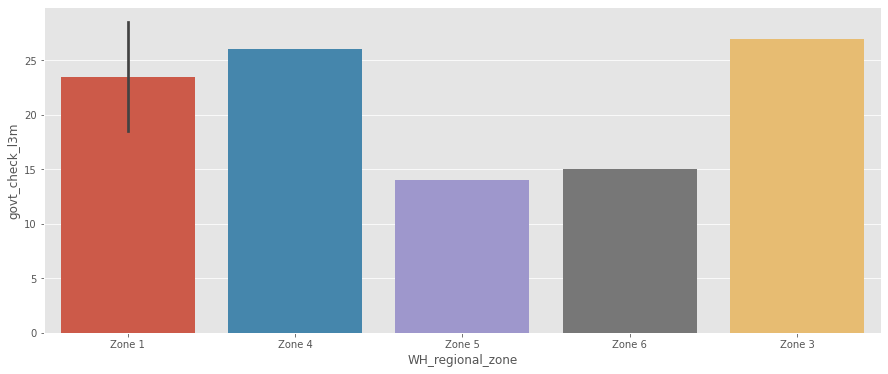

In [33]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Urban' & zone == 'East'"), x='WH_regional_zone', y='govt_check_l3m')

<AxesSubplot:xlabel='WH_regional_zone', ylabel='govt_check_l3m'>

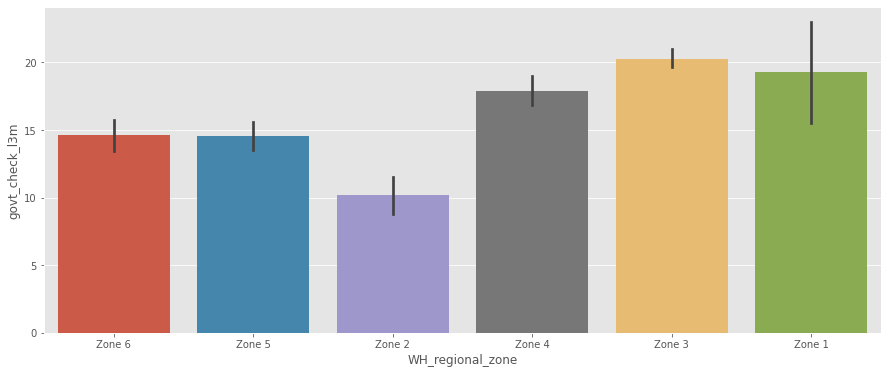

In [34]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df.query("Location_type == 'Urban' & zone == 'West'"), x='WH_regional_zone', y='govt_check_l3m')

In [43]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['flood_impacted'].mean()

Location_type  zone   WH_regional_zone
Rural          East   Zone 1              0.054054
                      Zone 3              0.060000
                      Zone 4              0.068182
                      Zone 5              0.100000
                      Zone 6              0.071429
               North  Zone 1              0.114504
                      Zone 2              0.108557
                      Zone 3              0.096330
                      Zone 4              0.111007
                      Zone 5              0.101079
                      Zone 6              0.098400
               South  Zone 1              0.105678
                      Zone 2              0.089087
                      Zone 3              0.100737
                      Zone 4              0.106173
                      Zone 5              0.089391
                      Zone 6              0.099364
               West   Zone 1              0.095344
                      Zone 2              0

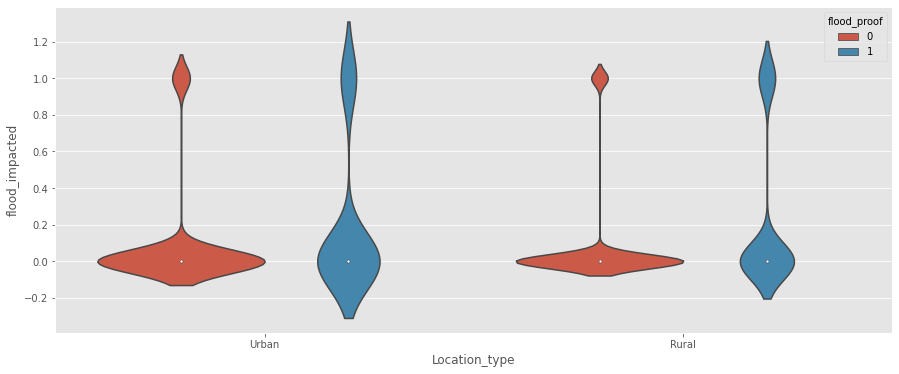

In [21]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=df, x='Location_type', y='flood_impacted', hue='flood_proof')
plt.savefig('fi_ft_lt.png')
plt.show()

Location_type         Rural      Urban
WH_capacity_size                      
Large             29.047289  28.759651
Mid               28.759347  29.184690
Small             29.144429  28.384164


<AxesSubplot:xlabel='WH_capacity_size'>

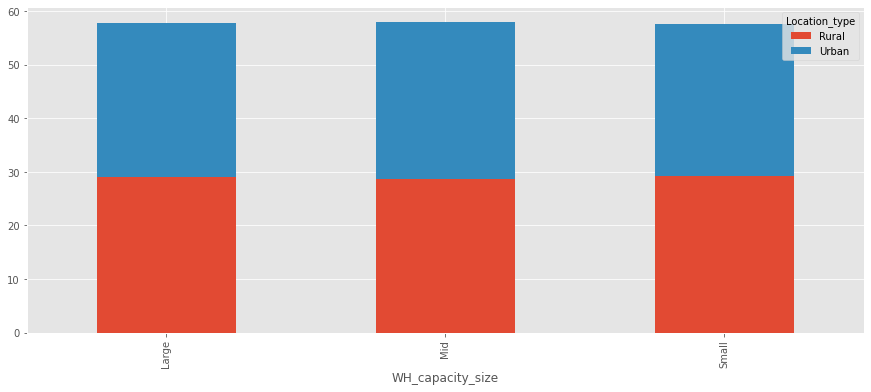

In [45]:
pivoted_df = pd.pivot_table(data=df, index='WH_capacity_size', columns='Location_type', values='workers_num')
print(pivoted_df)
pivoted_df.plot(kind='bar', stacked=True, figsize=(15, 6))

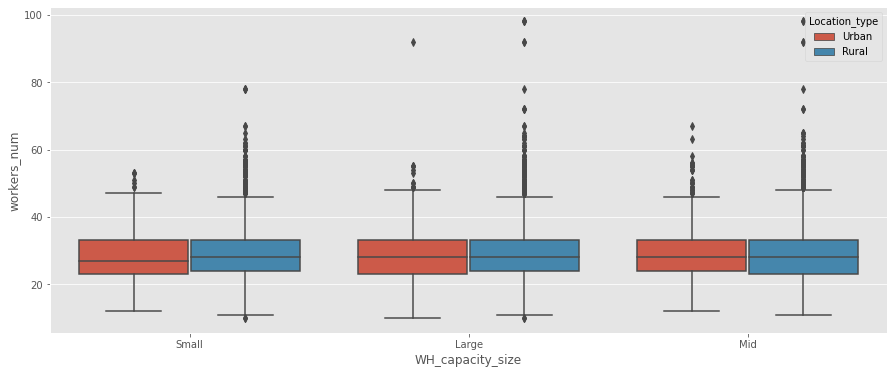

In [22]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='WH_capacity_size', y='workers_num', hue='Location_type')
plt.savefig('cs_wn_lt.png')
plt.show()

In [47]:
df['wh_owner_type'].value_counts()

Company Owned    13578
Rented           11422
Name: wh_owner_type, dtype: int64

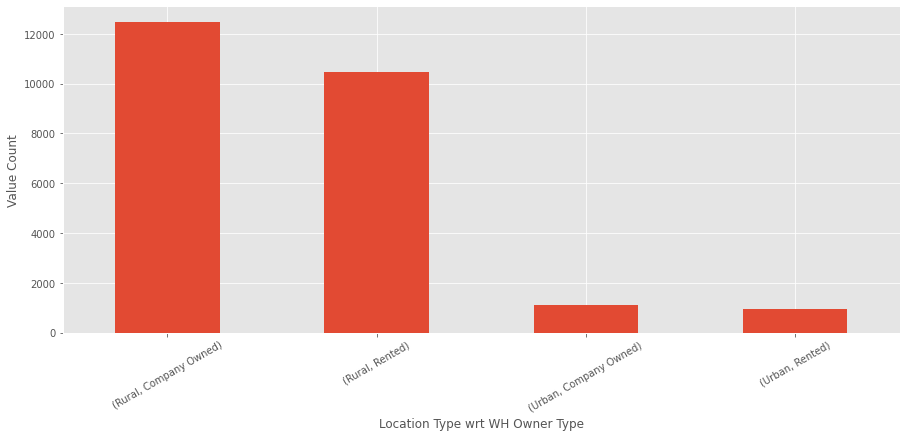

In [48]:
df.groupby('Location_type')['wh_owner_type'].value_counts().plot(kind='bar', figsize=(15, 6))
plt.xticks(rotation=30)
plt.ylabel('Value Count')
plt.xlabel('Location Type wrt WH Owner Type')
plt.show()

Text(0.5, 0, 'Location Type and Zone wrt WH Owner Type')

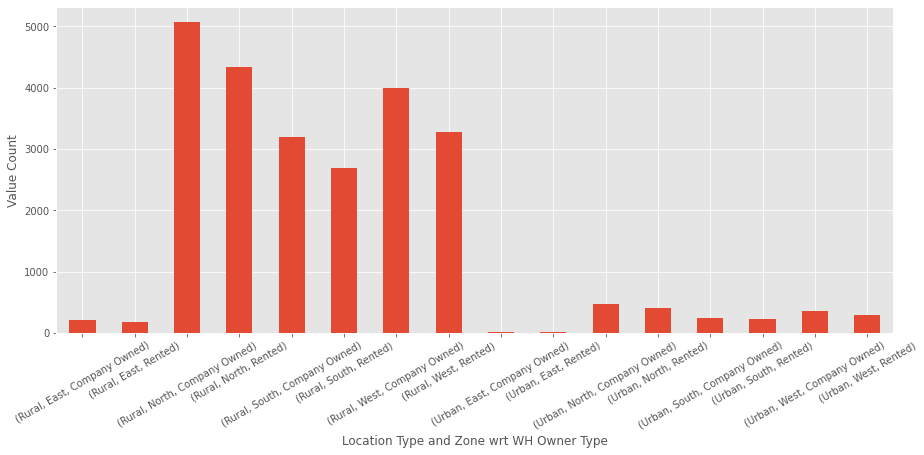

In [49]:
df.groupby(['Location_type', 'zone'])['wh_owner_type'].value_counts().plot(kind='bar',figsize=(15, 6))
plt.xticks(rotation=30)
plt.ylabel('Value Count')
plt.xlabel('Location Type and Zone wrt WH Owner Type')

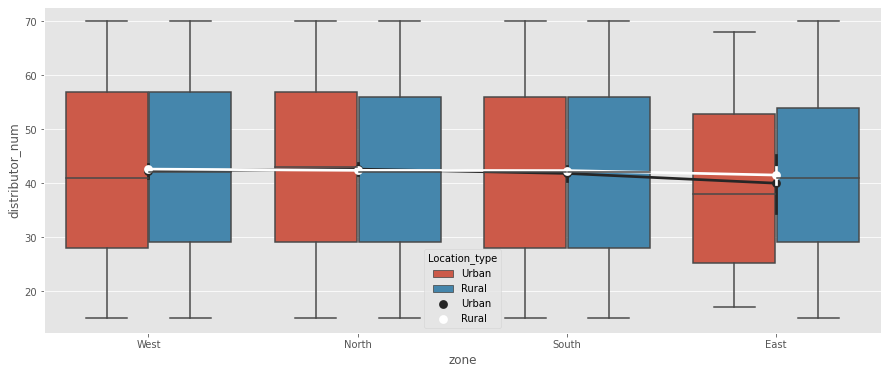

In [5]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='zone', y='distributor_num', hue='Location_type')
sns.pointplot(data=df, x='zone', y='distributor_num', hue='Location_type', color='white')
plt.savefig('zone_dist_lt.png')
plt.show()

In [6]:
df

Ware_house_ID WH_Manager_ID Location_type WH_capacity_size   zone  \
0         WH_100000     EID_50000         Urban            Small   West   
1         WH_100001     EID_50001         Rural            Large  North   
2         WH_100002     EID_50002         Rural              Mid  South   
3         WH_100003     EID_50003         Rural              Mid  North   
4         WH_100004     EID_50004         Rural            Large  North   
...             ...           ...           ...              ...    ...   
24995     WH_124995     EID_74995         Rural            Small  North   
24996     WH_124996     EID_74996         Rural              Mid   West   
24997     WH_124997     EID_74997         Urban            Large  South   
24998     WH_124998     EID_74998         Rural            Small  North   
24999     WH_124999     EID_74999         Rural              Mid   West   

      WH_regional_zone  num_refill_req_l3m  transport_issue_l1y  \
0               Zone 6                   3                    1   
1               Zone 5                   0                    0   
2               Zone 2                   1                    0   
3               Zone 3                   7                    4   
4               Zone 5                   3                    1   
...                ...                 ...                  ...   
24995           Zone 1                   3                    0   
24996           Zone 2                   6                    0   
24997           Zone 5                   7                    0   
24998           Zone 1                   1                    0   
24999           Zone 4                   8                    2   

       Competitor_in_mkt  retail_shop_num  wh_owner_type  distributor_num  \
0                      2             4651         Rented               24   
1                      4             6217  Company Owned               47   
2                      4             4306  Company Owned               64   
3                      2             6000         Rented               50   
4                      2             4740  Company Owned               42   
...                  ...              ...            ...              ...   
24995                  4             5390         Rented               19   
24996                  4             4490  Company Owned               57   
24997                  2             5403         Rented               31   
24998                  2            10562         Rented               25   
24999                  4             5664  Company Owned               21   

       flood_impacted  flood_proof  electric_supply  dist_from_hub  \
0                   0            1                1             91   
1                   0            0                1            210   
2                   0            0                0            161   
3                   0            0                0            103   
4                   1            0                1            112   
...               ...          ...              ...            ...   
24995               0            0                1            142   
24996               0            0                1            130   
24997               1            0                1            147   
24998               0            0                1             60   
24999               0            1                1            239   

       workers_num  wh_est_year  storage_issue_reported_l3m  temp_reg_mach  \
0             29.0          NaN                          13              0   
1             31.0          NaN                           4              0   
2             37.0          NaN                          17              0   
3             21.0          NaN                          17              1   
4             25.0       2009.0                          18              0   
...            ...          ...                         ...       

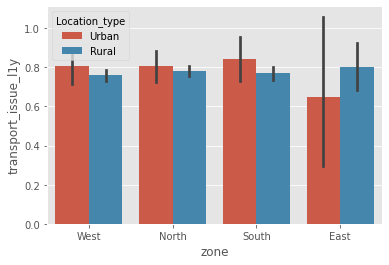

In [14]:
sns.barplot(data=df, x='zone', y='transport_issue_l1y', hue='Location_type')
plt.savefig('tissue_zone.png')

<AxesSubplot:xlabel='zone', ylabel='transport_issue_l1y'>

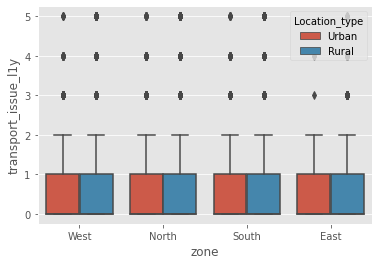

In [13]:
sns.boxplot(data=df, x='zone', y='transport_issue_l1y', hue='Location_type')

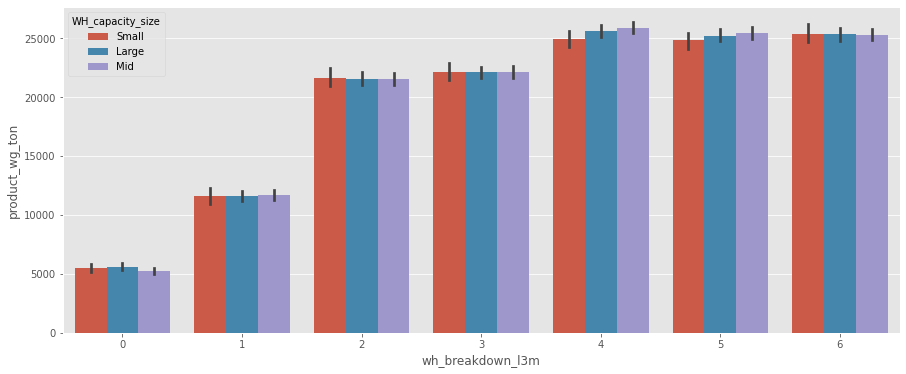

In [51]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='wh_breakdown_l3m', y='product_wg_ton', hue='WH_capacity_size')
plt.show()

<AxesSubplot:>

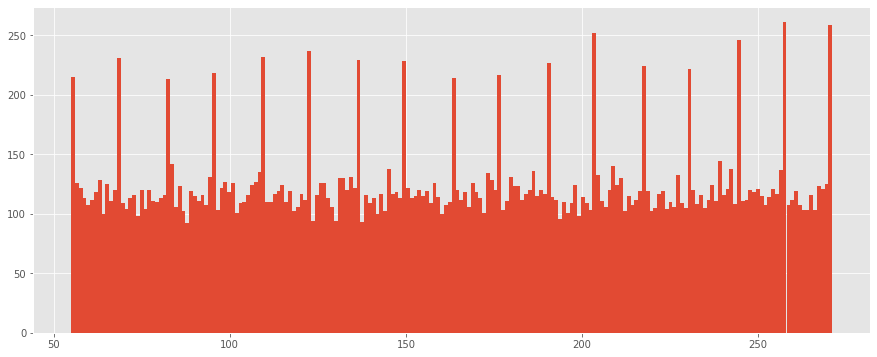

In [52]:
df['dist_from_hub'].hist(
    bins=200,
    figsize=(15, 6)
)

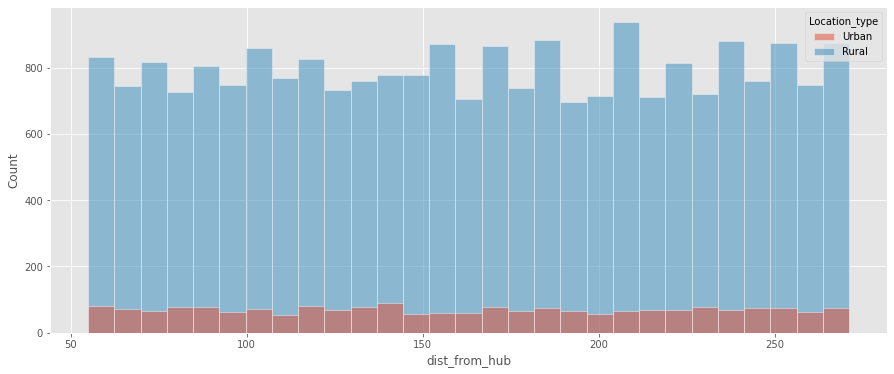

In [29]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='dist_from_hub', hue='Location_type')
plt.savefig('dist_lt.png')
plt.show()

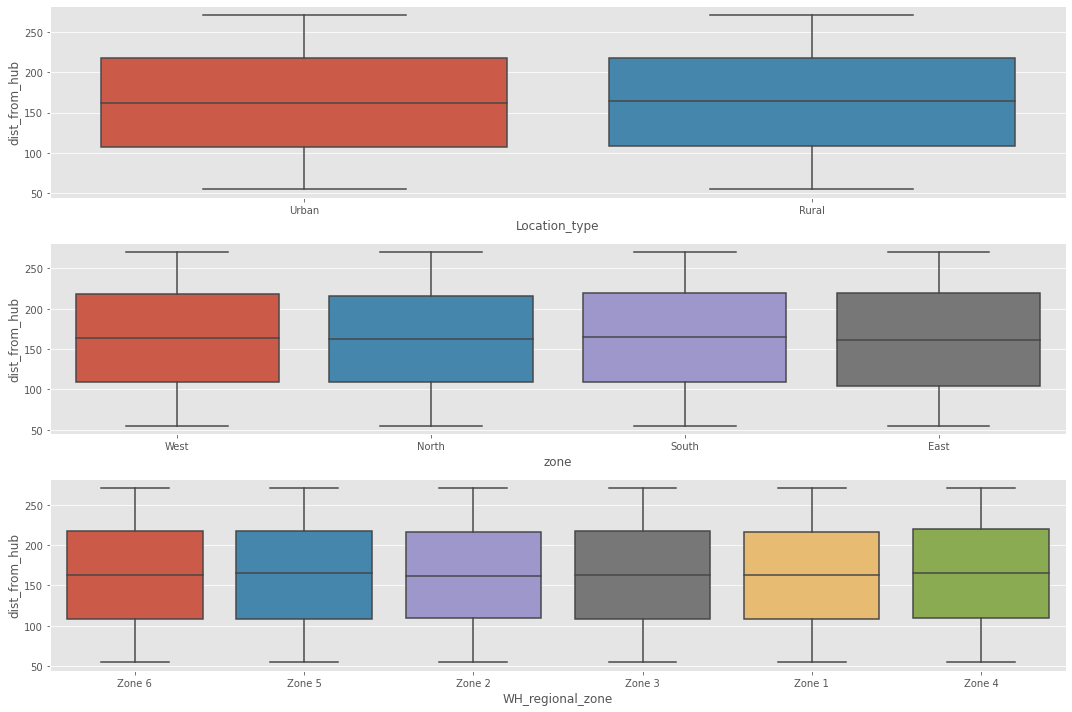

In [56]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
sns.boxplot(data=df, y='dist_from_hub', x='Location_type', ax=ax[0])
sns.boxplot(data=df, y='dist_from_hub', x='zone', ax=ax[1])
sns.boxplot(data=df, y='dist_from_hub', x='WH_regional_zone', ax=ax[2])
plt.tight_layout()
plt.show()

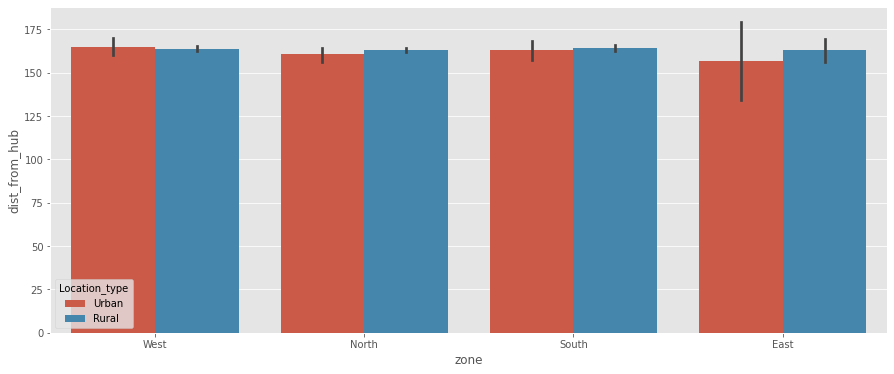

In [32]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, y='dist_from_hub', x='zone', hue='Location_type')
plt.savefig('dist_zone_lt.png')
plt.show()

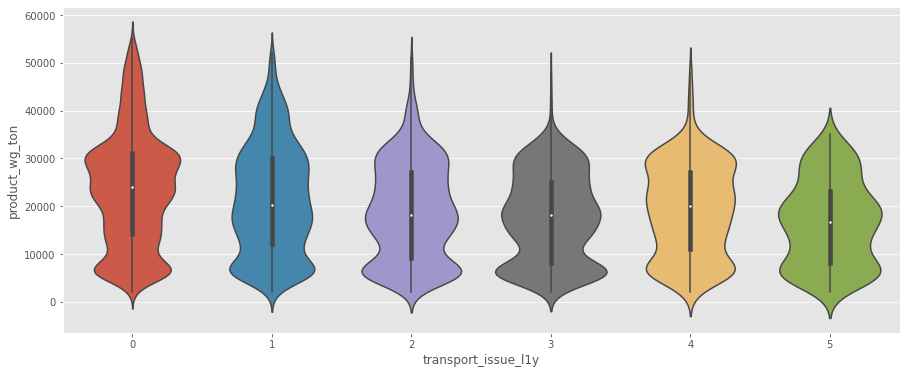

In [87]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=df, x='transport_issue_l1y', y='product_wg_ton')
plt.show()

In [82]:
pt = pd.pivot_table(data=df, 
                    index='transport_issue_l1y', 
                    columns=['WH_regional_zone', 'zone', 'Location_type'], 
                    values='dist_from_hub',
                    aggfunc='mean',
                    margins=True)
pt.T

transport_issue_l1y                            0           1           2  \
WH_regional_zone zone  Location_type                                       
Zone 1           East  Rural          155.428571  211.500000         NaN   
                       Urban          158.400000  212.000000         NaN   
                 North Rural          163.130802  162.482270  150.346154   
                       Urban          170.500000  156.250000  168.000000   
                 South Rural          159.926121  170.392000  160.058824   
                       Urban          143.954545  193.615385  172.200000   
                 West  Rural          162.700375  164.719101  166.340426   
                       Urban          156.250000  186.777778  253.000000   
Zone 2           North Rural          163.000000  168.618705  185.851852   
                       Urban          165.547619  165.437500  117.500000   
                 South Rural          164.430605  159.962810  162.140351   
                       Urban          171.161290  160.000000  143.000000   
                 West  Rural          162.007812  154.441176  145.086957   
                       Urban          156.542857  197.562500  189.833333   
Zone 3           East  Rural          176.426230  157.411765  184.636364   
                       Urban          113.000000         NaN   57.000000   
                 North Rural          161.038817  159.925926  163.791045   
                       Urban          159.488889  163.280000  179.900000   
                 South Rural          162.905155  160.788079  162.615385   
                       Urban          162.641026  169.294118  177.000000   
                 West  Rural          161.310078  170.478261  159.250000   
                       Urban          164.021277  179.090909  134.875000   
Zone 4           East  Rural          153.615385  165.958333  160.000000   
                       Urban          180.500000  141.750000  234.000000   
                 North Rural          163.754414  158.953704  163.865979   
                       Urban          160.183099  157.200000  165.363636   
                 South Rural          165.565844  173.274510  173.694444   
                       Urban          157.755556  151.846154  206.142857   
                 West  Rural          164.115385  163.559727  171.344371   
                       Urban          164.385321  164.814815  172.947368   
Zone 5           East  Rural          148.476190  163.062500  156.000000   
                       Urban          198.333333         NaN  198.000000   
                 North Rural          161.870406  161.925595  163.056818   
                       Urban          162.121212  161.548387  147.416667   
                 South Rural          164.099533  162.956757  168.586207   
                       Urban          156.196721  165.214286  160.400000   
                 West  Rural          166.603345  158.084615  175.310345   
                       Urban          158.637681  165.714286  179.142857   
Zone 6           East  Rural          175.062500  158.461538  120.500000   
                       Urban          221.000000         NaN         NaN   
                 North Rural          162.834727  162.633929  167.308743   
                       Urban          159.556034  159.434211  145.470588   
                 South Rural          163.677588  171.460177  166.732759   
                       Urban          172.142857  160.888889  132.833333   
                 West  Rural          161.410830  167.097990  165.461957   
                       Urban          157.065217  164.756757  167.652174   
All                                   162.899507  163.914729  165.483167   

transport_issue_l1y                            3           4           5  \
WH_regional_zone zone  Location_type                                       
Zone 1           East  Rural          179.500000  265.000000   71.000000   
                       Urban                 Na

In [83]:
df_gb_tissue_c = df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['transport_issue_l1y'].count()
df_gb_tissue_m = df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['transport_issue_l1y'].mean()

In [84]:
df_gb_tissue_c = df_gb_tissue_c.sort_values(ascending=False)
df_gb_tissue_m = df_gb_tissue_m.sort_values(ascending=False)
df_gb_tissue_m = df_gb_tissue_m.reset_index()

In [85]:
df_gb_tissue_c_normalied = (df_gb_tissue_c.max() - df_gb_tissue_c) / df_gb_tissue_c.max()
df_gb_tissue_c_normalied = df_gb_tissue_c_normalied.sort_values(ascending=False)
df_gb_tissue_c_normalied = df_gb_tissue_c_normalied.reset_index()

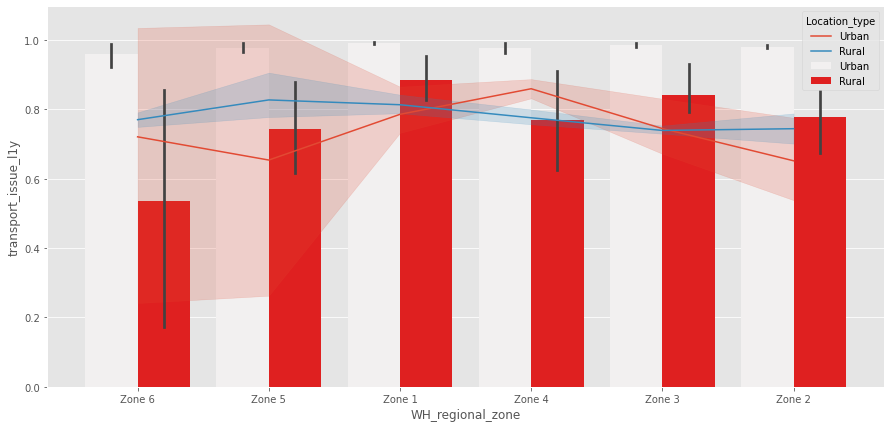

In [86]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(data=df_gb_tissue_c_normalied, x='WH_regional_zone', y='transport_issue_l1y', hue='Location_type', ax=ax, color='r')
sns.lineplot(data=df_gb_tissue_m, x='WH_regional_zone', y='transport_issue_l1y', hue='Location_type', ax=ax)
plt.show()

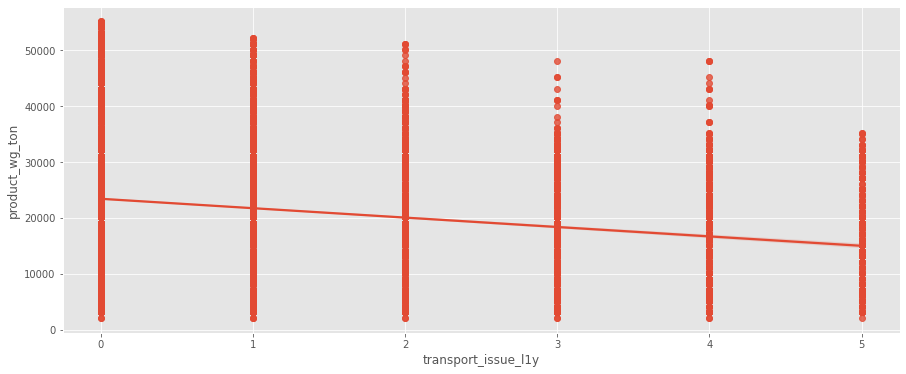

In [88]:
plt.figure(figsize=(15, 6))
sns.regplot(data=df, x='transport_issue_l1y', y='product_wg_ton')
plt.show()

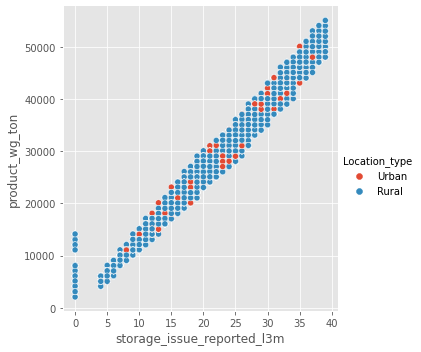

In [93]:
sns.relplot(data=df, x='storage_issue_reported_l3m', y='product_wg_ton', hue='Location_type')

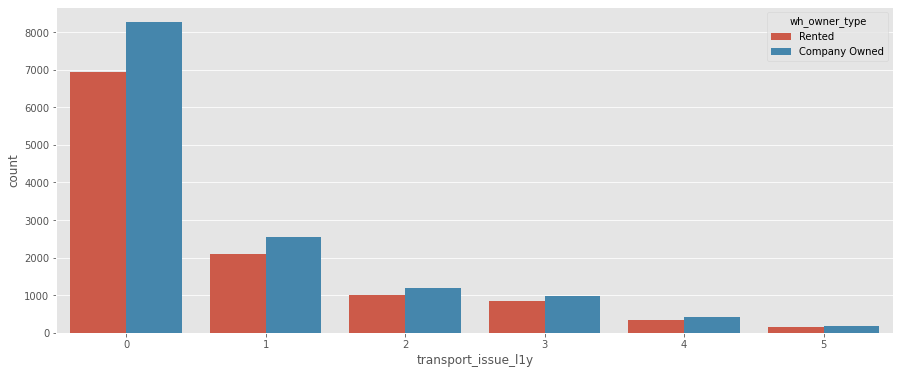

In [89]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='transport_issue_l1y', hue='wh_owner_type')
plt.show()

In [90]:
df.groupby(['transport_issue_l1y', 'Location_type'])['retail_shop_num'].agg(['mean', 'median', 'count', 'sum'])

mean  median  count       sum
transport_issue_l1y Location_type                                      
0                   Rural          4990.431343  4860.0  14019  69960857
                    Urban          4957.942308  4832.0   1196   5929699
1                   Rural          4975.144070  4865.0   4241  21099586
                    Urban          4970.699752  4816.0    403   2003192
2                   Rural          4971.309845  4857.0   2001   9947591
                    Urban          5092.548223  4976.0    197   1003232
3                   Rural          5023.651442  4864.5   1664   8359356
                    Urban          5026.538961  4786.0    154    774087
4                   Rural          4955.795775  4822.0    710   3518615
                    Urban          5016.313433  4936.0     67    336093
5                   Rural          4894.919255  4789.5    322   1576164
                    Urban          5166.038462  5098.0     26    134317

<AxesSubplot:xlabel='Location_type', ylabel='flood_impacted'>

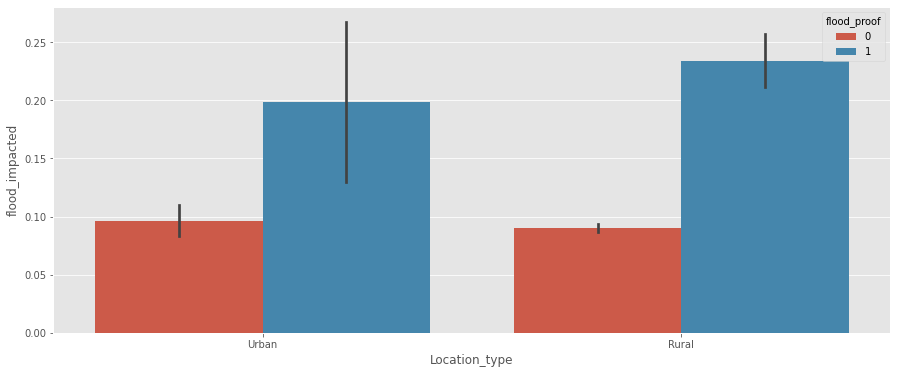

In [91]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='Location_type', y='flood_impacted', hue='flood_proof')
plt.savefig('Useful')

<AxesSubplot:xlabel='zone', ylabel='electric_supply'>

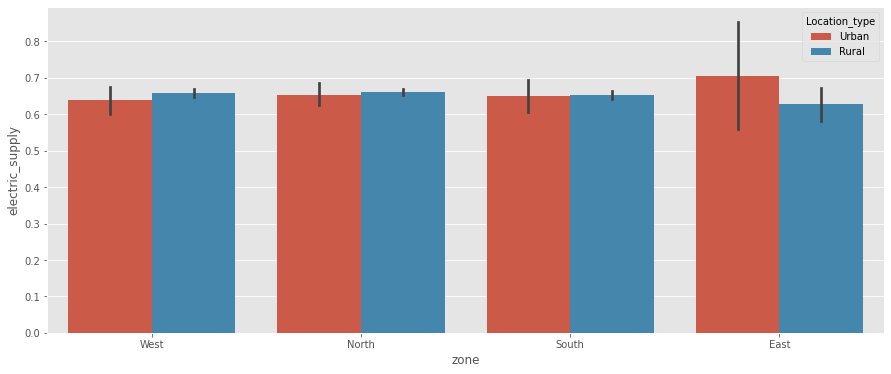

In [92]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='zone', y='electric_supply', hue='Location_type')

<AxesSubplot:xlabel='wh_breakdown_l3m', ylabel='storage_issue_reported_l3m'>

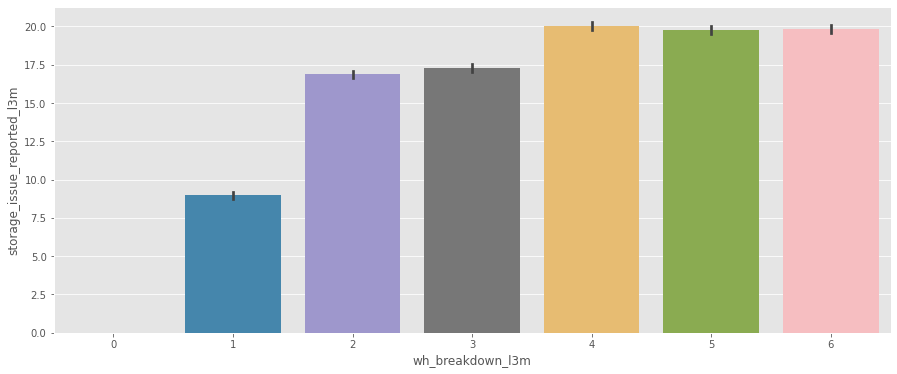

In [94]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='wh_breakdown_l3m', y='storage_issue_reported_l3m')

In [95]:
df['current_year'] = 2023
df['age'] = df['current_year'] - df['wh_est_year']

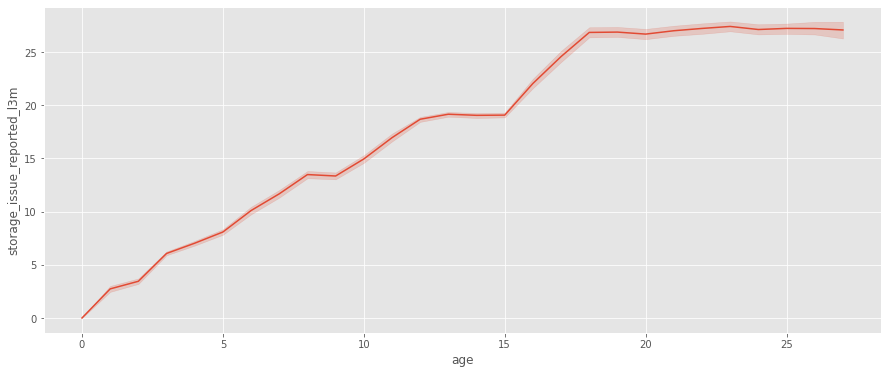

In [96]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='age', y='storage_issue_reported_l3m')
plt.show()

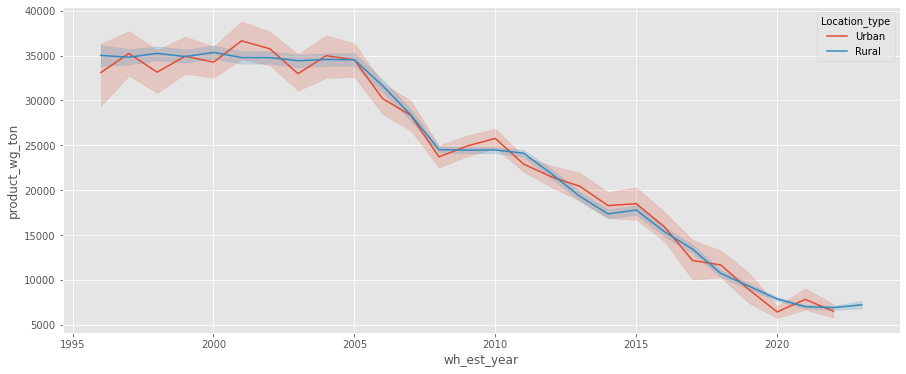

In [97]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='wh_est_year', y='product_wg_ton', hue='Location_type')
plt.show()

<AxesSubplot:xlabel='Location_type,zone,WH_regional_zone'>

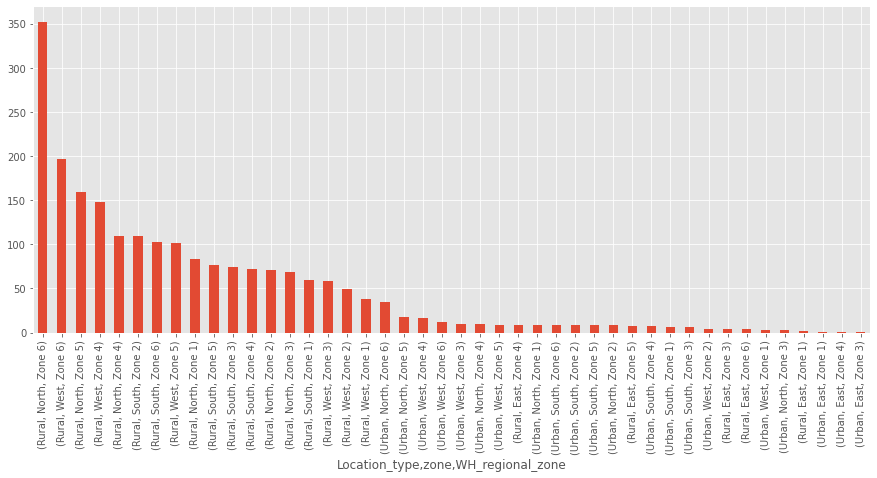

In [98]:
df.loc[(df['flood_proof'] == 0) &
       (df['flood_impacted'] == 1), ['Location_type', 'zone', 'WH_regional_zone']].value_counts().plot(kind='bar', figsize=(15, 6))

<AxesSubplot:xlabel='Location_type,zone,WH_regional_zone'>

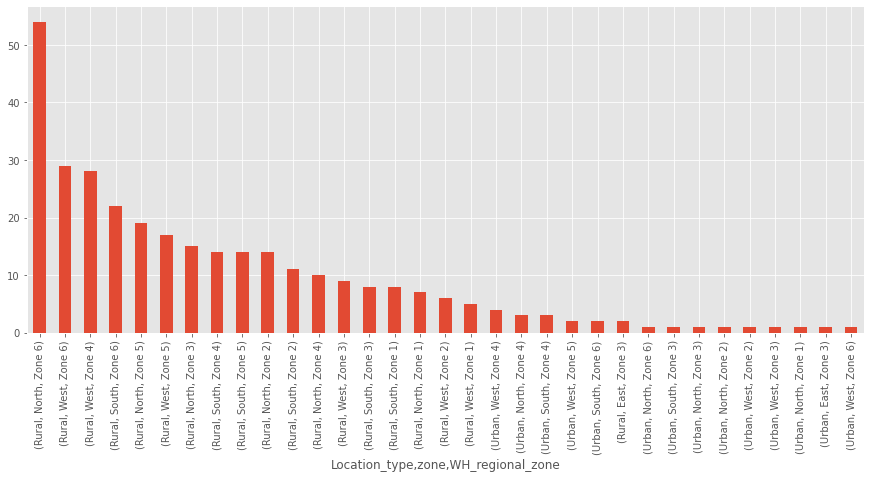

In [99]:
df.loc[(df['flood_proof'] == 1) &
       (df['flood_impacted'] == 1), ['Location_type', 'zone', 'WH_regional_zone']].value_counts().plot(kind='bar', figsize=(15, 6))

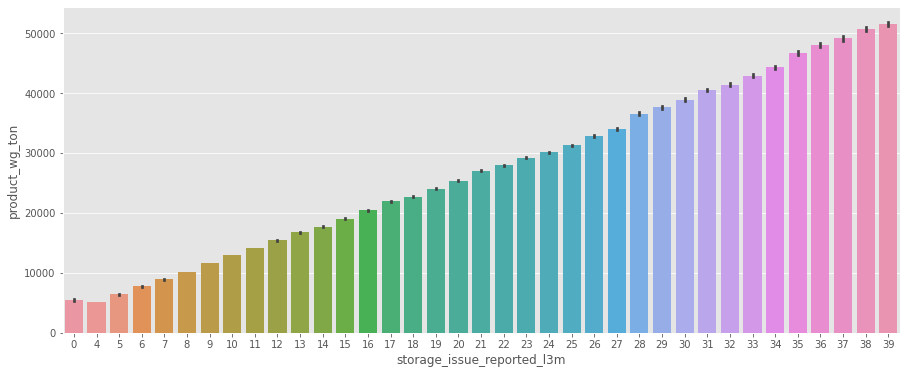

In [100]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='storage_issue_reported_l3m', y='product_wg_ton')
plt.show()

<AxesSubplot:xlabel='Location_type,zone,WH_regional_zone'>

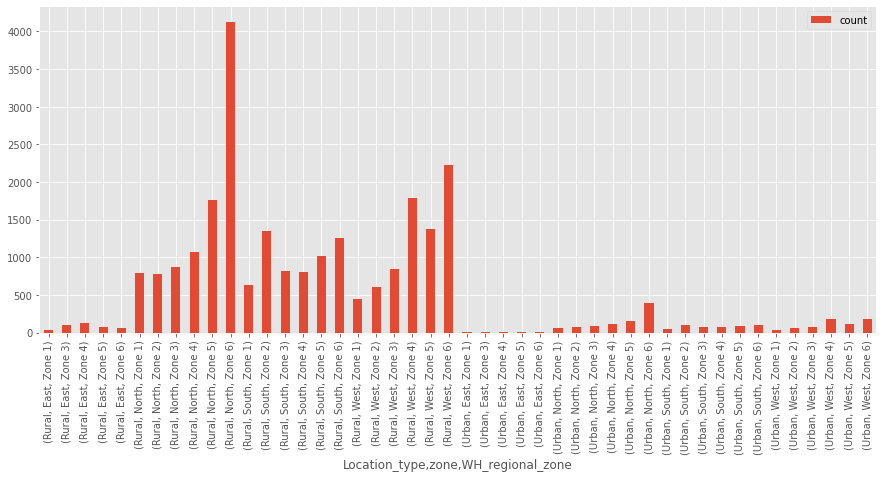

In [101]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['transport_issue_l1y'].agg(['count']).plot(kind='bar', figsize=(15, 6))

<AxesSubplot:xlabel='Location_type,zone,WH_regional_zone'>

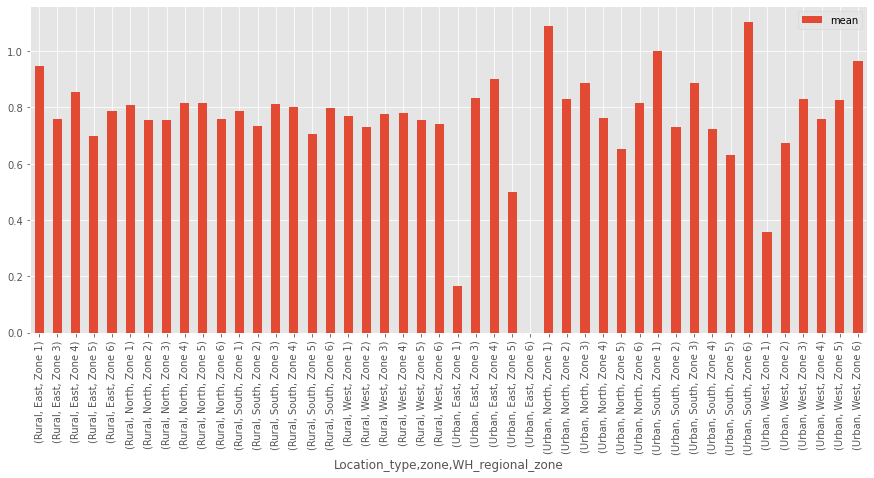

In [102]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['transport_issue_l1y'].agg(['mean']).plot(kind='bar', figsize=(15, 6))

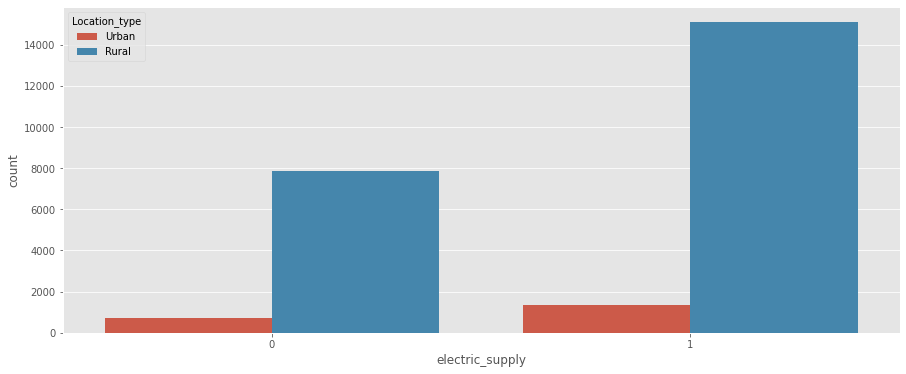

In [103]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='electric_supply', hue='Location_type')
plt.show()

<AxesSubplot:xlabel='Location_type,zone,WH_regional_zone,electric_supply'>

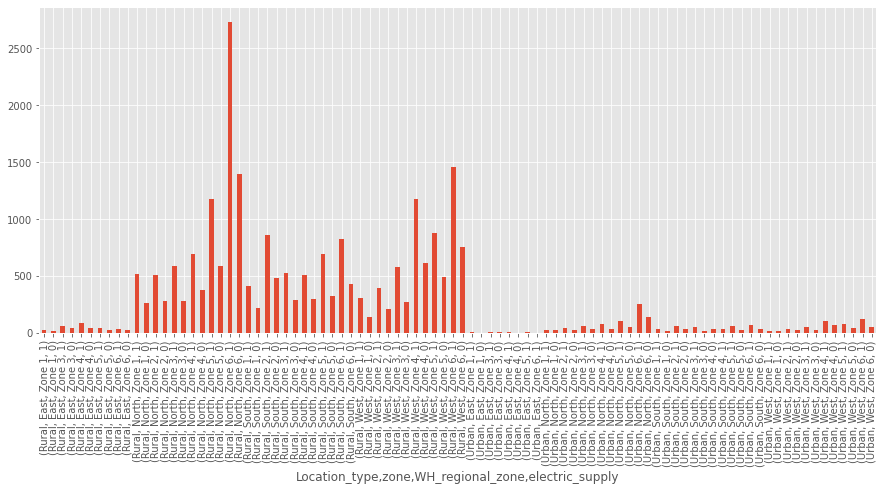

In [104]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['electric_supply'].value_counts().plot(kind='bar', figsize=(15, 6))

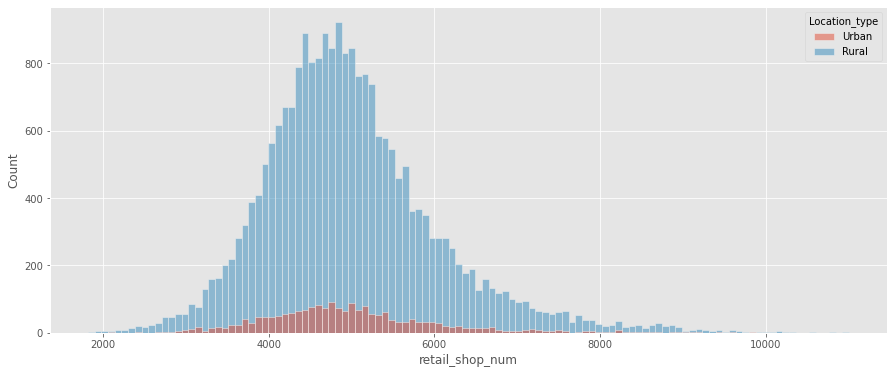

In [33]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='retail_shop_num', hue='Location_type')
plt.savefig('retail_lt.png')
plt.show()

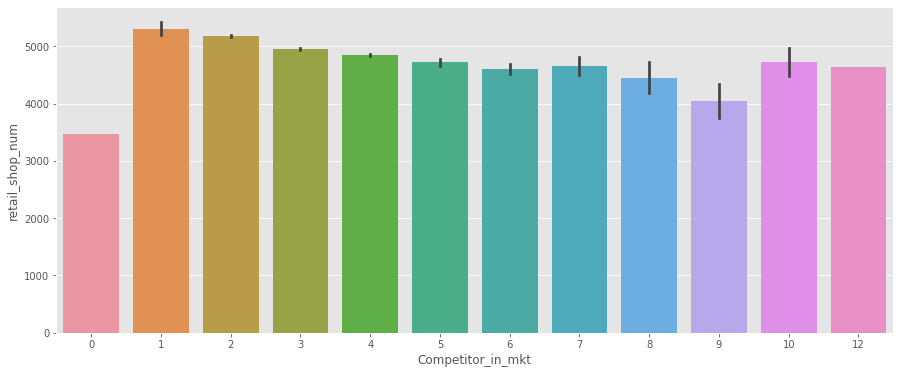

In [37]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='Competitor_in_mkt', y='retail_shop_num')
plt.show()

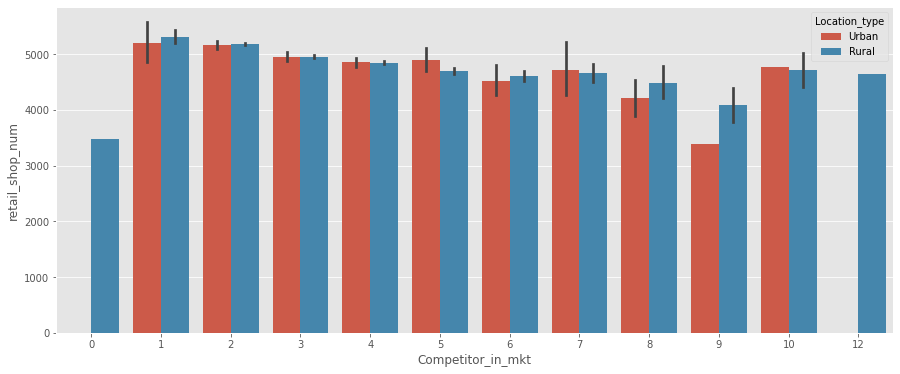

In [44]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='Competitor_in_mkt', y='retail_shop_num', hue='Location_type')
plt.show()

<AxesSubplot:xlabel='product_wg_ton', ylabel='Density'>

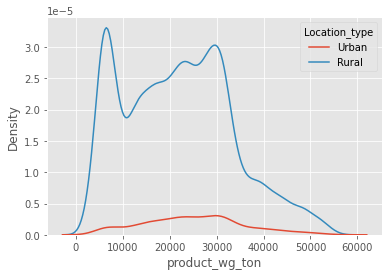

In [39]:
sns.kdeplot(data=df, x='product_wg_ton', hue='Location_type')

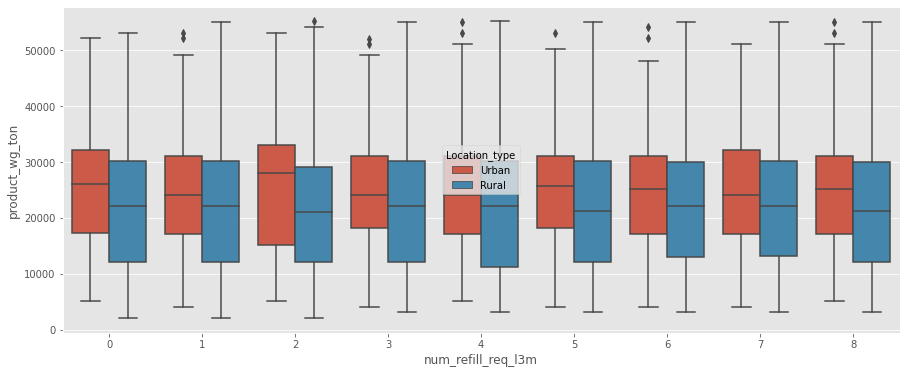

In [48]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='num_refill_req_l3m', y='product_wg_ton', hue='Location_type')
plt.savefig('')
plt.show()

In [50]:
df.groupby(['WH_regional_zone', 'WH_capacity_size'])['govt_check_l3m'].mean()

WH_regional_zone  WH_capacity_size
Zone 1            Small               20.204966
Zone 2            Mid                 17.785353
Zone 3            Mid                 22.545991
Zone 4            Mid                 21.678161
Zone 5            Large               16.539568
Zone 6            Large               21.029738
                  Small                9.927457
Name: govt_check_l3m, dtype: float64

<AxesSubplot:xlabel='WH_regional_zone', ylabel='govt_check_l3m'>

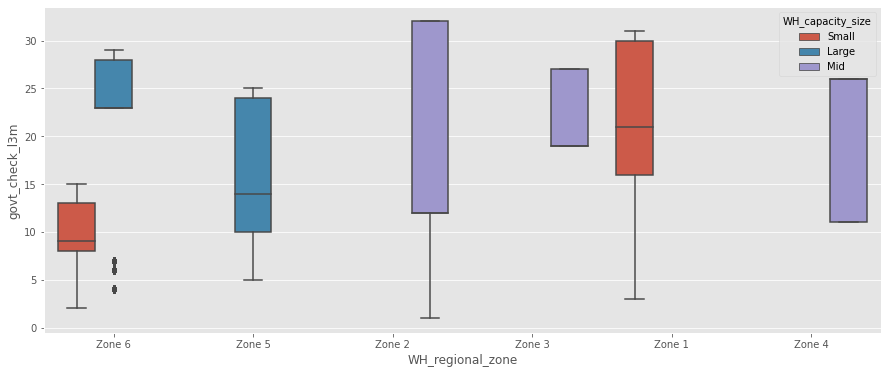

In [58]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='WH_regional_zone', y='govt_check_l3m', hue='WH_capacity_size')

<AxesSubplot:xlabel='WH_regional_zone', ylabel='govt_check_l3m'>

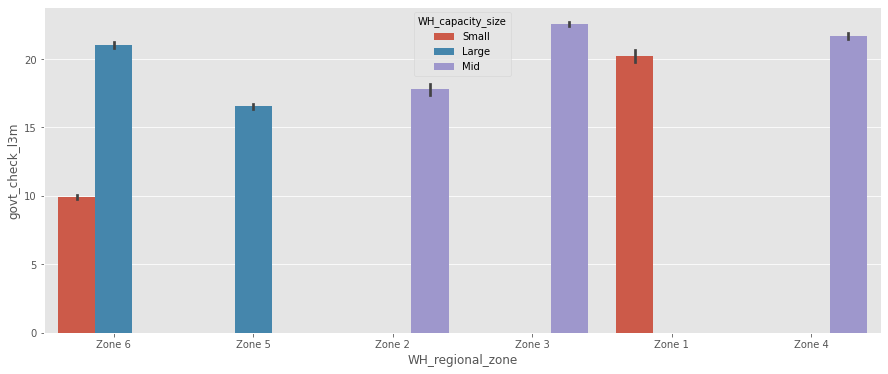

In [52]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='WH_regional_zone', y='govt_check_l3m', hue='WH_capacity_size')

<AxesSubplot:xlabel='Location_type,zone,WH_regional_zone,WH_capacity_size'>

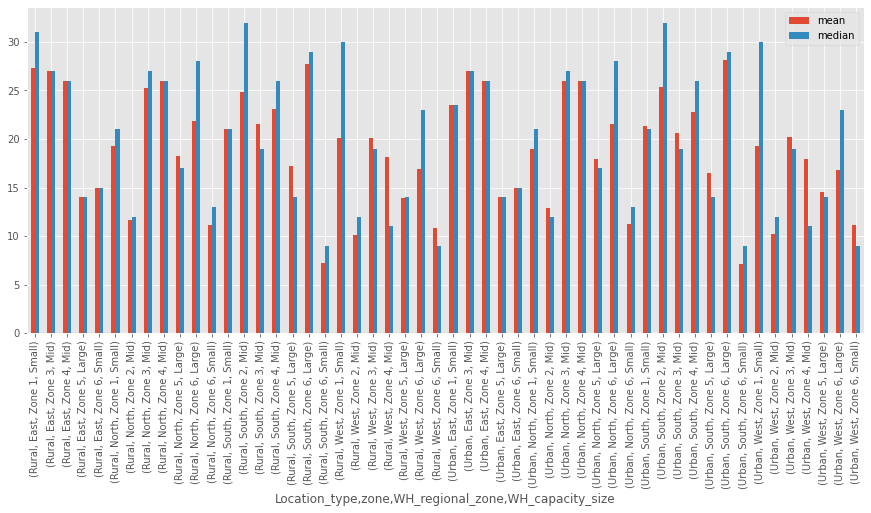

In [57]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone', 'WH_capacity_size'])['govt_check_l3m'].agg(['mean', 'median']).plot(kind='bar', figsize=(15, 6))

In [69]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone', 'WH_capacity_size'])['govt_check_l3m'].agg(['mean', 'median', 'count'])

mean  median  \
Location_type zone  WH_regional_zone WH_capacity_size                      
Rural         East  Zone 1           Small             27.351351    31.0   
                    Zone 3           Mid               27.000000    27.0   
                    Zone 4           Mid               26.000000    26.0   
                    Zone 5           Large             14.000000    14.0   
                    Zone 6           Small             15.000000    15.0   
              North Zone 1           Small             19.270992    21.0   
                    Zone 2           Mid               11.639847    12.0   
                    Zone 3           Mid               25.256881    27.0   
                    Zone 4           Mid               26.000000    26.0   
                    Zone 5           Large             18.282794    17.0   
                    Zone 6           Large             21.817066    28.0   
                                     Small             11.169355    13.0   
              South Zone 1           Small             21.044164    21.0   
                    Zone 2           Mid               24.874536    32.0   
                    Zone 3           Mid               21.525799    19.0   
                    Zone 4           Mid               23.111111    26.0   
                    Zone 5           Large             17.251473    14.0   
                    Zone 6           Large             27.732759    29.0   
                                     Small              7.207809     9.0   
              West  Zone 1           Small             20.133038    30.0   
                    Zone 2           Mid               10.067881    12.0   
                    Zone 3           Mid               20.153664    19.0   
                    Zone 4           Mid               18.148438    11.0   
                    Zone 5           Large             13.922571    14.0   
                    Zone 6           Large             16.946082    23.0   
                                     Small             10.861111     9.0   
Urban         East  Zone 1           Small             23.500000    23.5   
                    Zone 3           Mid               27.000000    27.0   
                    Zone 4           Mid               26.000000    26.0   
                    Zone 5           Large             14.000000    14.0   
                    Zone 6           Small             15.000000    15.0   
              North Zone 1           Small             18.981818    21.0   
                    Zone 2           Mid               12.859155    12.0   
                    Zone 3           Mid               26.011236    27.0   
                    Zone 4           Mid               26.000000    26.0   
                    Zone 5           Large             17.974359    17.0   
                    Zone 6           Large             21.530159    28.0   
                                     Small             11.243590    13.0   
              South Zone 1           Small             21.369565    21.0   
                    Zone 2           Mid               25.391753    32.0   
                    Zone 3           Mid               20.577465    19.0   
                    Zone 4           Mid               22.833333    26.0   
                    Zone 5           Large             16.460674    14.0   
                    Zone 6           Large             28.181818    29.0   
                                     Small              7.177419     9.0   
              West  Zone 1           Small             19.282051    30.0   
                    Zone 2           Mid               10.180328    12.0   
                    Zone 3           Mid               20.246753    19.0   
                    Zone 4           Mid               17.896552    11.0   
                    Zone 5           Large             14.533333    14.0   
                    Zone 6           Large             16.781818    23.0   
                                

<AxesSubplot:xlabel='WH_regional_zone', ylabel='govt_check_l3m'>

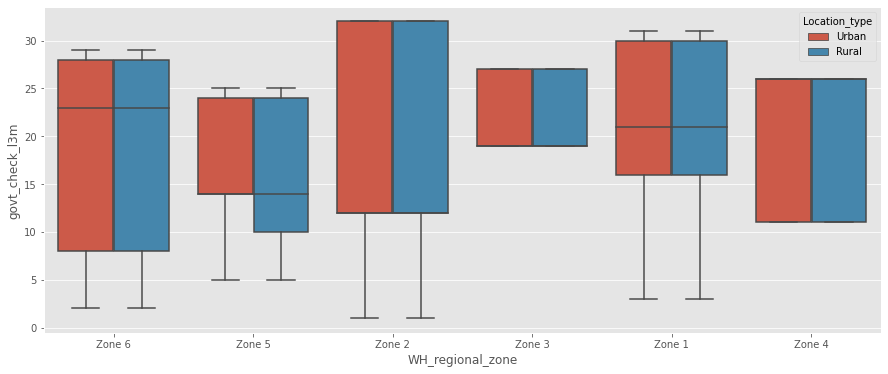

In [66]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='WH_regional_zone', y='govt_check_l3m', hue='Location_type')

In [75]:
df

Ware_house_ID WH_Manager_ID Location_type WH_capacity_size   zone  \
0         WH_100000     EID_50000         Urban            Small   West   
1         WH_100001     EID_50001         Rural            Large  North   
2         WH_100002     EID_50002         Rural              Mid  South   
3         WH_100003     EID_50003         Rural              Mid  North   
4         WH_100004     EID_50004         Rural            Large  North   
...             ...           ...           ...              ...    ...   
24995     WH_124995     EID_74995         Rural            Small  North   
24996     WH_124996     EID_74996         Rural              Mid   West   
24997     WH_124997     EID_74997         Urban            Large  South   
24998     WH_124998     EID_74998         Rural            Small  North   
24999     WH_124999     EID_74999         Rural              Mid   West   

      WH_regional_zone  num_refill_req_l3m  transport_issue_l1y  \
0               Zone 6                   3                    1   
1               Zone 5                   0                    0   
2               Zone 2                   1                    0   
3               Zone 3                   7                    4   
4               Zone 5                   3                    1   
...                ...                 ...                  ...   
24995           Zone 1                   3                    0   
24996           Zone 2                   6                    0   
24997           Zone 5                   7                    0   
24998           Zone 1                   1                    0   
24999           Zone 4                   8                    2   

       Competitor_in_mkt  retail_shop_num  wh_owner_type  distributor_num  \
0                      2             4651         Rented               24   
1                      4             6217  Company Owned               47   
2                      4             4306  Company Owned               64   
3                      2             6000         Rented               50   
4                      2             4740  Company Owned               42   
...                  ...              ...            ...              ...   
24995                  4             5390         Rented               19   
24996                  4             4490  Company Owned               57   
24997                  2             5403         Rented               31   
24998                  2            10562         Rented               25   
24999                  4             5664  Company Owned               21   

       flood_impacted  flood_proof  electric_supply  dist_from_hub  \
0                   0            1                1             91   
1                   0            0                1            210   
2                   0            0                0            161   
3                   0            0                0            103   
4                   1            0                1            112   
...               ...          ...              ...            ...   
24995               0            0                1            142   
24996               0            0                1            130   
24997               1            0                1            147   
24998               0            0                1             60   
24999               0            1                1            239   

       workers_num  wh_est_year  storage_issue_reported_l3m  temp_reg_mach  \
0             29.0          NaN                          13              0   
1             31.0          NaN                           4              0   
2             37.0          NaN                          17              0   
3             21.0          NaN                          17              1   
4             25.0       2009.0                          18              0   
...            ...          ...                         ...       

In [76]:
df.groupby(['Location_type', 'WH_capacity_size'])['transport_issue_l1y'].count()

Location_type  WH_capacity_size
Rural          Large               9331
               Mid                 9172
               Small               4454
Urban          Large                838
               Mid                  848
               Small                357
Name: transport_issue_l1y, dtype: int64

In [82]:
df.groupby('WH_capacity_size')['retail_shop_num'].mean()

WH_capacity_size
Large    4928.428656
Mid      4967.454192
Small    5144.815423
Name: retail_shop_num, dtype: float64

In [78]:
df.groupby('WH_capacity_size')['retail_shop_num'].mean().diff()

WH_capacity_size
Large           NaN
Mid       39.025536
Small    177.361231
Name: retail_shop_num, dtype: float64

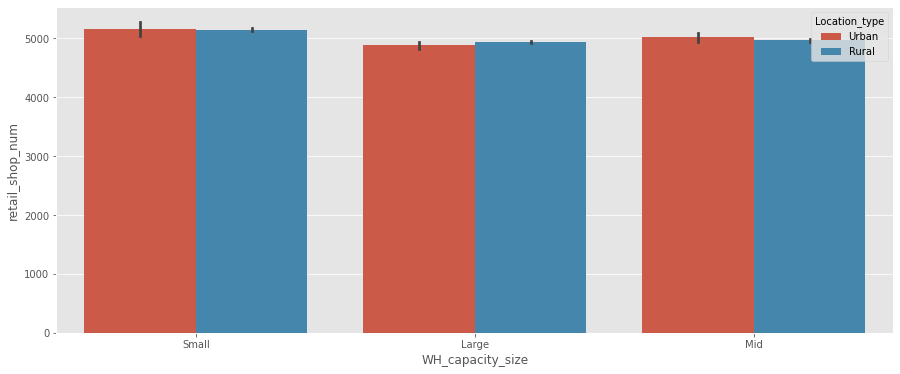

In [81]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='WH_capacity_size', y='retail_shop_num', hue='Location_type')
plt.show()

<AxesSubplot:xlabel='retail_shop_num', ylabel='workers_num'>

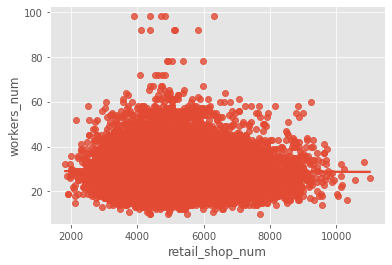

In [84]:
sns.regplot(data=df, x='retail_shop_num', y='workers_num')

In [107]:
pd.factorize(df['Location_type'])[0]

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [109]:
df[['retail_shop_num', 'dist_from_hub']].corr()

retail_shop_num  dist_from_hub
retail_shop_num         1.000000       0.000429
dist_from_hub           0.000429       1.000000

In [91]:
df.groupby('Location_type')[['retail_shop_num', 'dist_from_hub']].agg(['mean', 'sum'])

retail_shop_num            dist_from_hub         
                         mean        sum          mean      sum
Location_type                                                  
Rural             4985.937579  114462169    163.647994  3756867
Urban             4983.171806   10180620    162.293686   331566

<AxesSubplot:xlabel='WH_regional_zone', ylabel='retail_shop_num'>

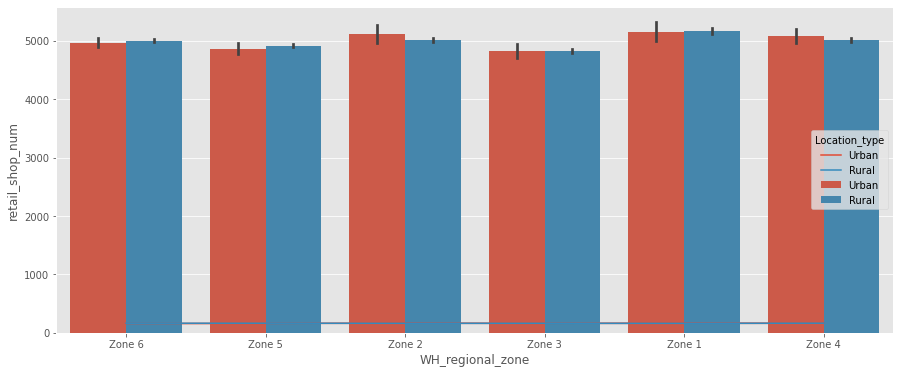

In [102]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=df, x='WH_regional_zone', y='dist_from_hub', hue='Location_type', color='white', ax=ax)
sns.barplot(data=df, x='WH_regional_zone', y='retail_shop_num', hue='Location_type', ax=ax)

In [114]:
df.groupby(['Location_type', 'WH_capacity_size'])['retail_shop_num'].agg(['mean', 'median'])

mean  median
Location_type WH_capacity_size                     
Rural         Large             4932.995820  4801.0
              Mid               4963.029328  4845.0
              Small             5144.023350  5014.0
Urban         Large             4877.573986  4740.0
              Mid               5015.313679  4946.0
              Small             5154.697479  4980.0

<AxesSubplot:xlabel='WH_regional_zone', ylabel='retail_shop_num'>

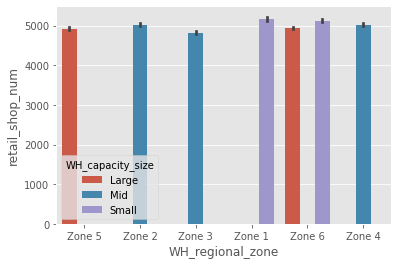

In [111]:
sns.barplot(data=df.query("Location_type == 'Rural'"), x='WH_regional_zone', y='retail_shop_num', hue='WH_capacity_size')

<AxesSubplot:xlabel='WH_regional_zone', ylabel='retail_shop_num'>

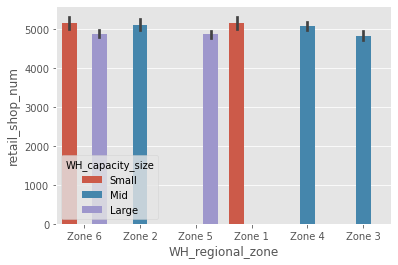

In [112]:
sns.barplot(data=df.query("Location_type == 'Urban'"), x='WH_regional_zone', y='retail_shop_num', hue='WH_capacity_size')

<AxesSubplot:xlabel='WH_regional_zone', ylabel='retail_shop_num'>

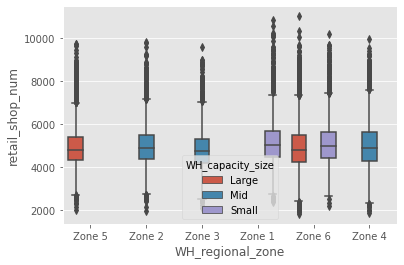

In [116]:
sns.boxplot(data=df.query("Location_type == 'Rural'"), x='WH_regional_zone', y='retail_shop_num', hue='WH_capacity_size')

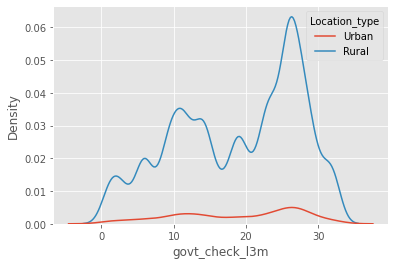

In [32]:
sns.kdeplot(data=df, x='govt_check_l3m', hue='Location_type')
plt.savefig('govt_lt.png')

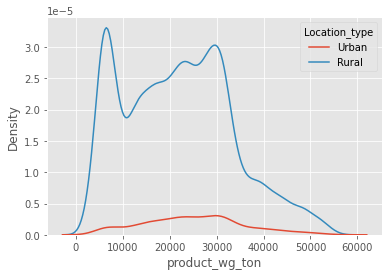

In [33]:
sns.kdeplot(data=df, x='product_wg_ton', hue='Location_type')
plt.savefig('prod_lt.png')

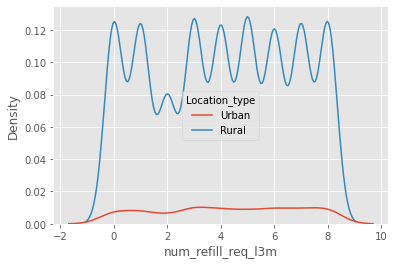

In [40]:
sns.kdeplot(data=df, x='num_refill_req_l3m', hue='Location_type')
plt.savefig('prod_lt.png')

In [ ]:
sns.lineplot(data=df, x='product_wg_ton', hue='Location_type')


In [20]:
df

Ware_house_ID WH_Manager_ID Location_type WH_capacity_size   zone  \
0         WH_100000     EID_50000         Urban            Small   West   
1         WH_100001     EID_50001         Rural            Large  North   
2         WH_100002     EID_50002         Rural              Mid  South   
3         WH_100003     EID_50003         Rural              Mid  North   
4         WH_100004     EID_50004         Rural            Large  North   
...             ...           ...           ...              ...    ...   
24995     WH_124995     EID_74995         Rural            Small  North   
24996     WH_124996     EID_74996         Rural              Mid   West   
24997     WH_124997     EID_74997         Urban            Large  South   
24998     WH_124998     EID_74998         Rural            Small  North   
24999     WH_124999     EID_74999         Rural              Mid   West   

      WH_regional_zone  num_refill_req_l3m  transport_issue_l1y  \
0               Zone 6                   3                    1   
1               Zone 5                   0                    0   
2               Zone 2                   1                    0   
3               Zone 3                   7                    4   
4               Zone 5                   3                    1   
...                ...                 ...                  ...   
24995           Zone 1                   3                    0   
24996           Zone 2                   6                    0   
24997           Zone 5                   7                    0   
24998           Zone 1                   1                    0   
24999           Zone 4                   8                    2   

       Competitor_in_mkt  retail_shop_num  wh_owner_type  distributor_num  \
0                      2             4651         Rented               24   
1                      4             6217  Company Owned               47   
2                      4             4306  Company Owned               64   
3                      2             6000         Rented               50   
4                      2             4740  Company Owned               42   
...                  ...              ...            ...              ...   
24995                  4             5390         Rented               19   
24996                  4             4490  Company Owned               57   
24997                  2             5403         Rented               31   
24998                  2            10562         Rented               25   
24999                  4             5664  Company Owned               21   

       flood_impacted  flood_proof  electric_supply  dist_from_hub  \
0                   0            1                1             91   
1                   0            0                1            210   
2                   0            0                0            161   
3                   0            0                0            103   
4                   1            0                1            112   
...               ...          ...              ...            ...   
24995               0            0                1            142   
24996               0            0                1            130   
24997               1            0                1            147   
24998               0            0                1             60   
24999               0            1                1            239   

       workers_num  wh_est_year  storage_issue_reported_l3m  temp_reg_mach  \
0             29.0          NaN                          13              0   
1             31.0          NaN                           4              0   
2             37.0          NaN                          17              0   
3             21.0          NaN                          17              1   
4             25.0       2009.0                          18              0   
...            ...          ...                         ...       

<AxesSubplot:xlabel='num_refill_req_l3m,Location_type'>

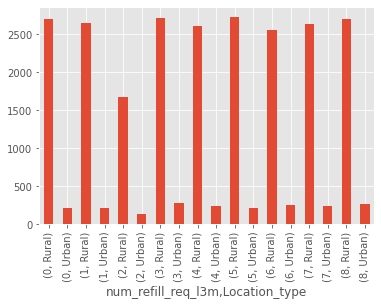

In [43]:
df.groupby(['num_refill_req_l3m', 'Location_type'])['govt_check_l3m'].count().plot(kind='bar')

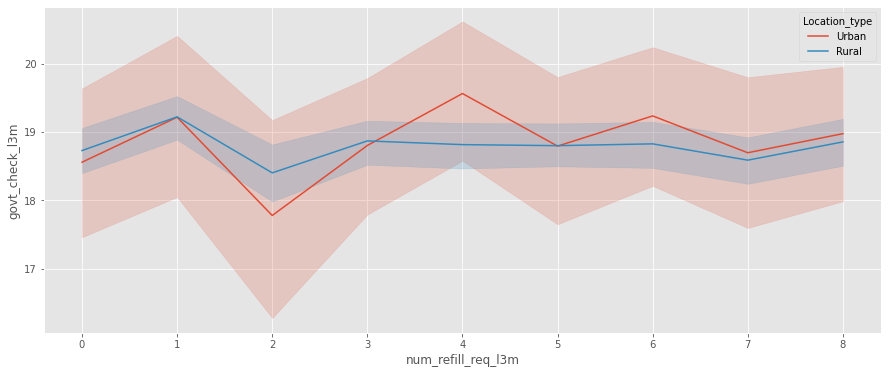

In [34]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='num_refill_req_l3m', y='govt_check_l3m', hue='Location_type')
plt.savefig('num_govt_lt.png')
plt.show()

<AxesSubplot:xlabel='govt_check_l3m', ylabel='product_wg_ton'>

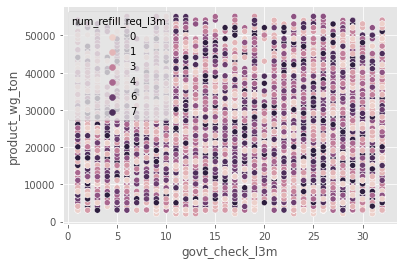

In [10]:
sns.scatterplot(data=df, x='govt_check_l3m', y='product_wg_ton', hue='num_refill_req_l3m')

In [11]:
import shap

In [ ]:
shap.dependence_plot()

In [3]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df[['num_refill_req_l3m', 'product_wg_ton']], df['govt_check_l3m'], test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [35]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

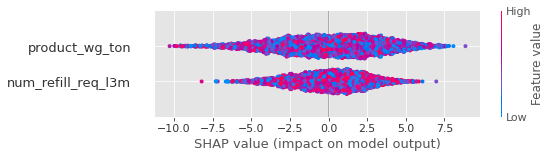

In [36]:
shap.summary_plot(shap_values, X_test)

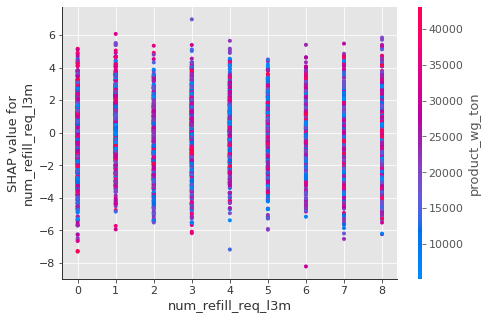

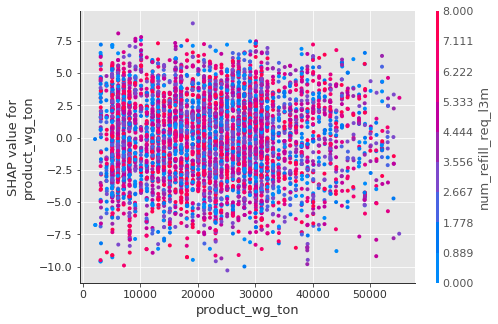

In [39]:
for i in X_train.columns:
    shap.dependence_plot(i, shap_values, X_test)

In [6]:
X = df[['num_refill_req_l3m', 'product_wg_ton']]
y = df['govt_check_l3m']
result = sm.OLS(y, X).fit()

In [7]:
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:         govt_check_l3m   R-squared (uncentered):                   0.707
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                          3.017e+04
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                        0.00
Time:                        12:10:05   Log-Likelihood:                         -95876.
No. Observations:               25000   AIC:                                  1.918e+05
Df Residuals:                   24998   BIC:                                  1.918e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [5]:
import statsmodels.api as sm 

In [53]:
new_df = df[['product_wg_ton', 'dist_from_hub', 'num_refill_req_l3m', 'Competitor_in_mkt', 'retail_shop_num', 'distributor_num', 'govt_check_l3m', 'workers_num']].dropna(axis=0)
X = new_df[['product_wg_ton', 'num_refill_req_l3m', 'Competitor_in_mkt', 'retail_shop_num', 'distributor_num', 'govt_check_l3m', 'workers_num']]
#X = sm.add_constant(X)
y = new_df['dist_from_hub']
result = sm.OLS(y, X).fit()

In [54]:
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:          dist_from_hub   R-squared (uncentered):                   0.858
Model:                            OLS   Adj. R-squared (uncentered):              0.858
Method:                 Least Squares   F-statistic:                          2.074e+04
Date:                Tue, 28 Mar 2023   Prob (F-statistic):                        0.00
Time:                        21:19:11   Log-Likelihood:                     -1.3465e+05
No. Observations:               24010   AIC:                                  2.693e+05
Df Residuals:                   24003   BIC:                                  2.694e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

<AxesSubplot:xlabel='distributor_num', ylabel='dist_from_hub'>

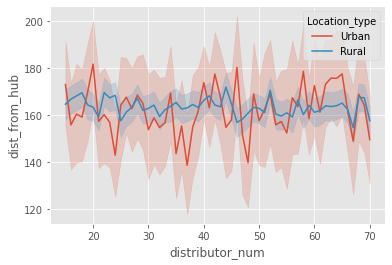

In [69]:
sns.lineplot(data=df, x='distributor_num', y='dist_from_hub', hue='Location_type')

<AxesSubplot:xlabel='retail_shop_num', ylabel='dist_from_hub'>

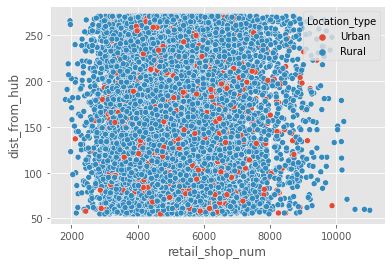

In [78]:
sns.scatterplot(data=df, x='retail_shop_num', y='dist_from_hub', hue='Location_type')

<AxesSubplot:xlabel='Competitor_in_mkt', ylabel='dist_from_hub'>

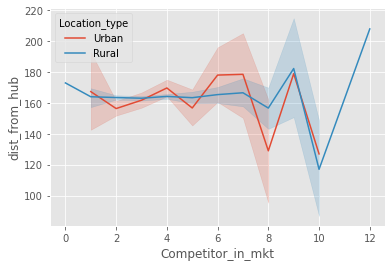

In [71]:
sns.lineplot(data=df, x='Competitor_in_mkt', y='dist_from_hub', hue='Location_type')

<AxesSubplot:xlabel='product_wg_ton', ylabel='dist_from_hub'>

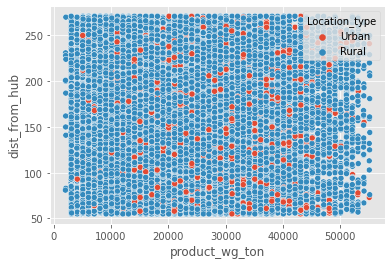

In [77]:
sns.scatterplot(data=df, x='product_wg_ton', y='dist_from_hub', hue='Location_type')

<AxesSubplot:xlabel='workers_num', ylabel='dist_from_hub'>

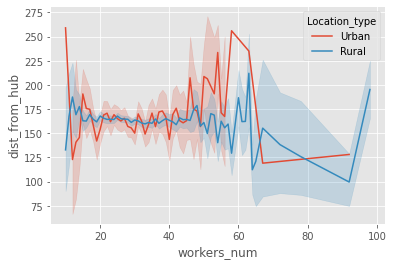

In [76]:
sns.lineplot(data=df, x='workers_num', y='dist_from_hub', hue='Location_type')

<AxesSubplot:xlabel='distributor_num', ylabel='dist_from_hub'>

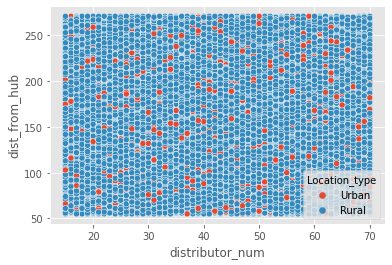

In [79]:
sns.scatterplot(data=df, x='distributor_num', y='dist_from_hub', hue='Location_type')

<AxesSubplot:xlabel='govt_check_l3m', ylabel='dist_from_hub'>

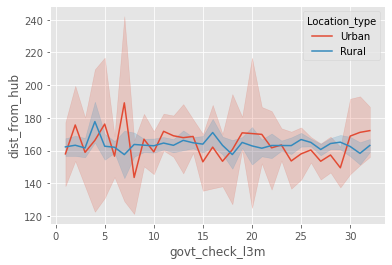

In [80]:
sns.lineplot(data=df, x='govt_check_l3m', y='dist_from_hub', hue='Location_type')

<AxesSubplot:xlabel='workers_num', ylabel='dist_from_hub'>

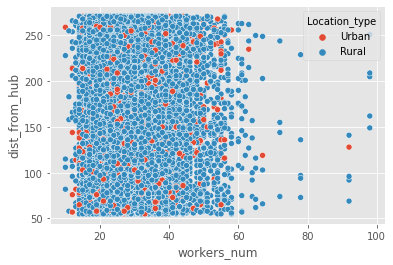

In [81]:
sns.scatterplot(data=df, x='workers_num', y='dist_from_hub', hue='Location_type')

In [82]:
df[['workers_num', 'dist_from_hub']].corr()

workers_num  dist_from_hub
workers_num       1.000000      -0.018565
dist_from_hub    -0.018565       1.000000

In [ ]:
distributor_num
govt_check_l3m
workers_num

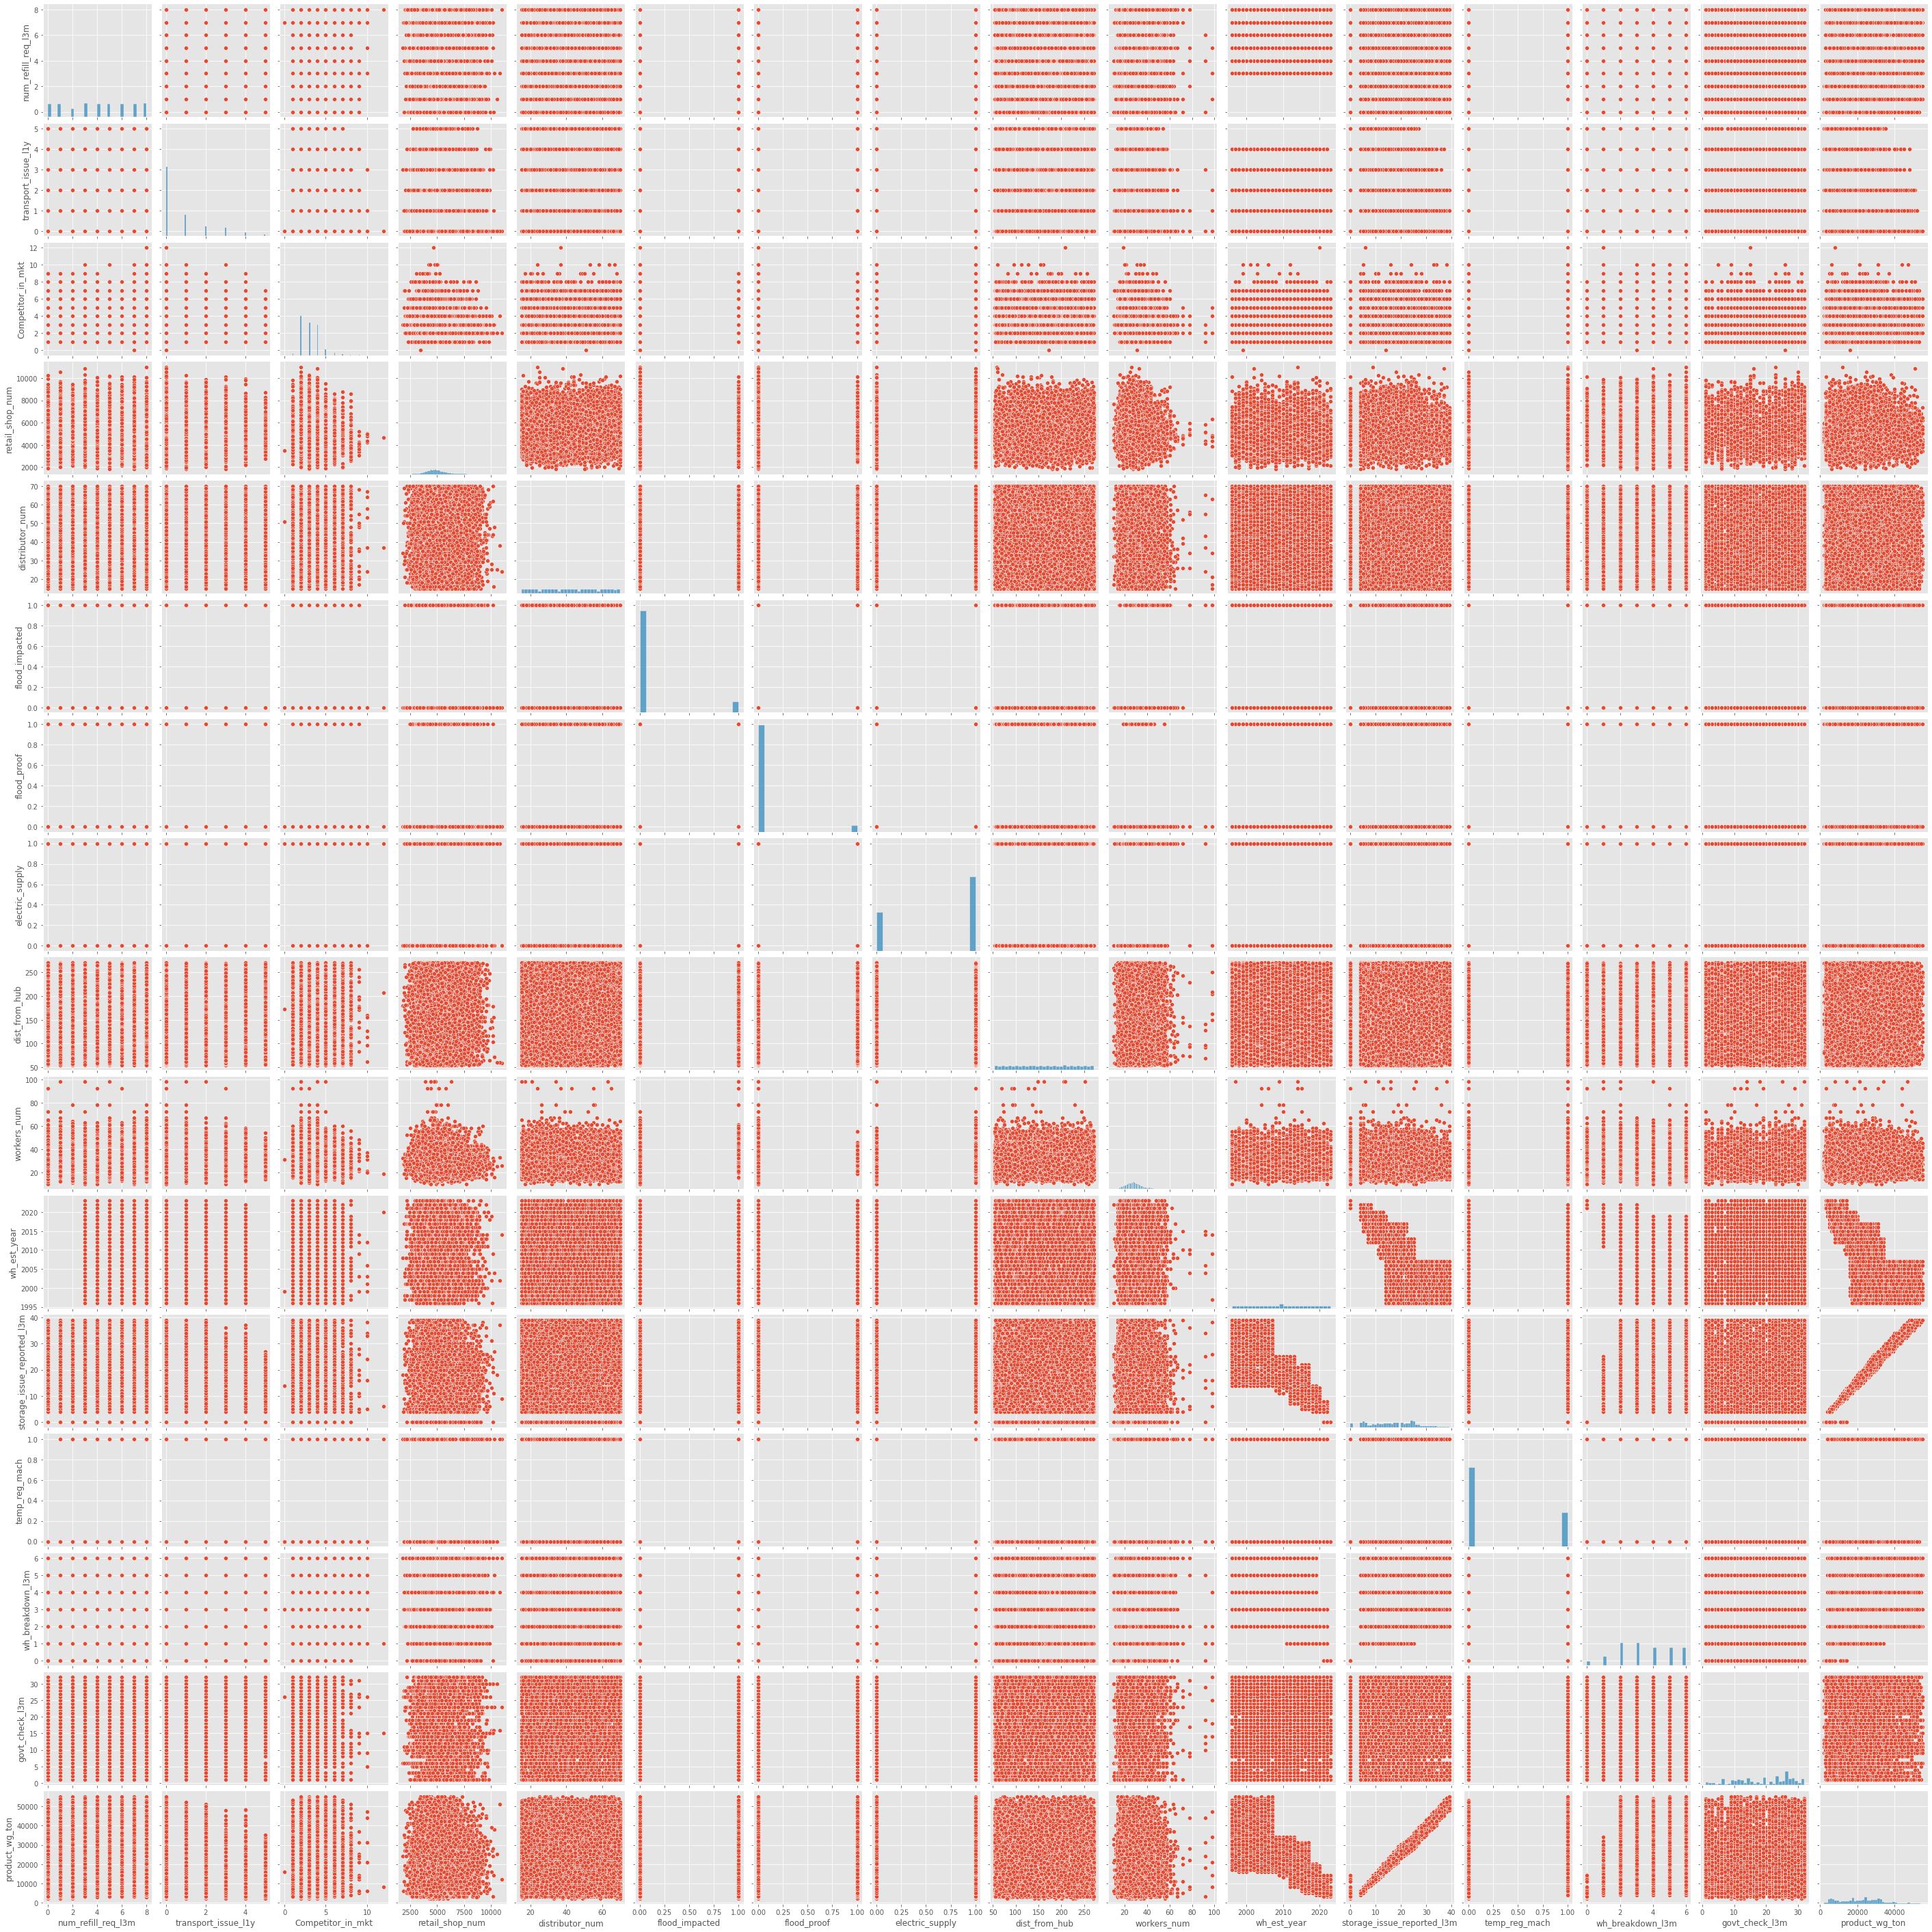

In [30]:
sns.pairplot(df)

In [40]:
df.head()

Ware_house_ID WH_Manager_ID Location_type WH_capacity_size   zone  \
0     WH_100000     EID_50000         Urban            Small   West   
1     WH_100001     EID_50001         Rural            Large  North   
2     WH_100002     EID_50002         Rural              Mid  South   
3     WH_100003     EID_50003         Rural              Mid  North   
4     WH_100004     EID_50004         Rural            Large  North   

  WH_regional_zone  num_refill_req_l3m  transport_issue_l1y  \
0           Zone 6                   3                    1   
1           Zone 5                   0                    0   
2           Zone 2                   1                    0   
3           Zone 3                   7                    4   
4           Zone 5                   3                    1   

   Competitor_in_mkt  retail_shop_num  wh_owner_type  distributor_num  \
0                  2             4651         Rented               24   
1                  4             6217  Company Owned               47   
2                  4             4306  Company Owned               64   
3                  2             6000         Rented               50   
4                  2             4740  Company Owned               42   

   flood_impacted  flood_proof  electric_supply  dist_from_hub  workers_num  \
0               0            1                1             91         29.0   
1               0            0                1            210         31.0   
2               0            0                0            161         37.0   
3               0            0                0            103         21.0   
4               1            0                1            112         25.0   

   wh_est_year  storage_issue_reported_l3m  temp_reg_mach  \
0          NaN                          13              0   
1          NaN                           4              0   
2          NaN                          17              0   
3          NaN                          17              1   
4       2009.0                          18              0   

  approved_wh_govt_certificate  wh_breakdown_l3m  govt_check_l3m  \
0                            A                 5              15   
1                            A                 3              17   
2                            A                 6              22   
3                           A+                 3              27   
4                            C                 6              24   

   product_wg_ton  
0           17115  
1            5074  
2           23137  
3           22115  
4           24071

In [41]:
df['Location_type'].value_counts()

Rural    22957
Urban     2043
Name: Location_type, dtype: int64

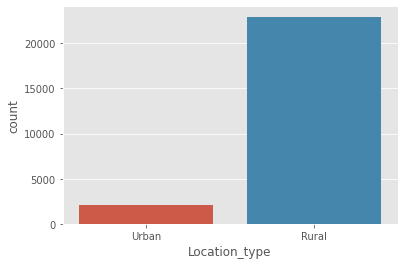

In [43]:
sns.countplot(data=df, x='Location_type')
plt.savefig('location_type_countplot.png')

<AxesSubplot:xlabel='product_wg_ton', ylabel='Count'>

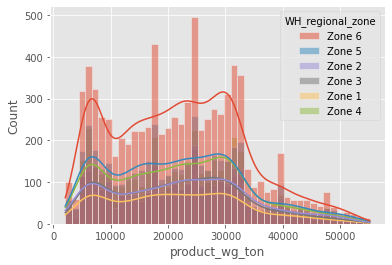

In [46]:
sns.histplot(data=df, x='product_wg_ton', hue='WH_regional_zone', kde=True)

In [53]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['product_wg_ton'].count().sort_values(ascending=False)

Location_type  zone   WH_regional_zone
Rural          North  Zone 6              4126
               West   Zone 6              2219
                      Zone 4              1792
               North  Zone 5              1761
               West   Zone 5              1369
               South  Zone 2              1347
                      Zone 6              1258
               North  Zone 4              1072
               South  Zone 5              1018
               North  Zone 3               872
               West   Zone 3               846
               South  Zone 3               814
                      Zone 4               810
               North  Zone 1               786
                      Zone 2               783
               South  Zone 1               634
               West   Zone 2               604
                      Zone 1               451
Urban          North  Zone 6               393
               West   Zone 6               179
                     

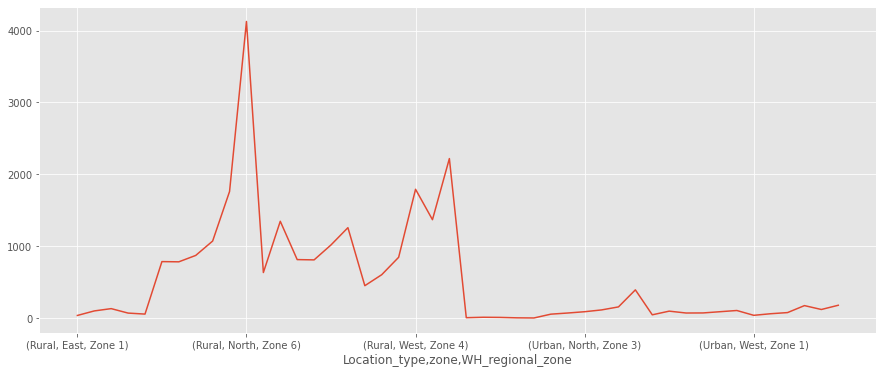

In [51]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['product_wg_ton'].count().plot(figsize=(15, 6))
plt.savefig('lt_zone_prod.png')

In [61]:
df.groupby('num_refill_req_l3m')['Competitor_in_mkt'].value_counts()

num_refill_req_l3m  Competitor_in_mkt
0                   2                    965
                    3                    864
                    4                    774
                    5                    157
                    6                     66
                                        ... 
8                   7                     26
                    8                     12
                    9                      2
                    10                     2
                    12                     1
Name: Competitor_in_mkt, Length: 85, dtype: int64

<AxesSubplot:xlabel='num_refill_req_l3m', ylabel='Competitor_in_mkt'>

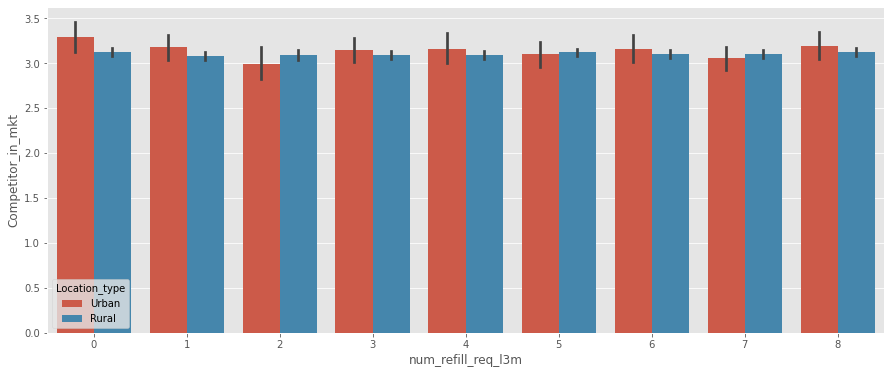

In [67]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='num_refill_req_l3m', y='Competitor_in_mkt', hue='Location_type')

In [105]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['retail_shop_num'].mean().sort_values(ascending=False)

Location_type  zone   WH_regional_zone
Urban          East   Zone 6              6370.000000
                      Zone 4              5533.700000
               South  Zone 2              5283.752577
Rural          South  Zone 1              5219.812303
Urban          South  Zone 1              5215.173913
Rural          East   Zone 6              5207.875000
               North  Zone 1              5197.264631
               East   Zone 3              5189.200000
Urban          South  Zone 6              5180.811321
               West   Zone 1              5167.461538
               North  Zone 1              5139.872727
                      Zone 3              5137.213483
Rural          South  Zone 6              5133.124801
Urban          North  Zone 2              5131.732394
Rural          West   Zone 1              5126.518847
Urban          West   Zone 4              5124.683908
Rural          North  Zone 4              5117.700560
Urban          East   Zone 3              5

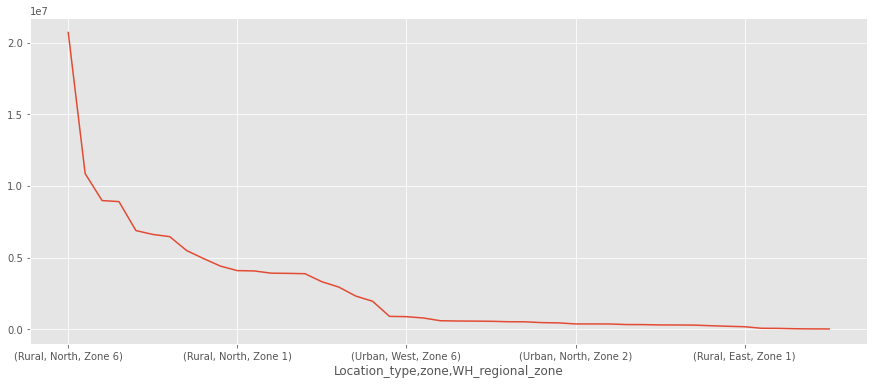

In [103]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['retail_shop_num'].sum().sort_values(ascending=False).plot(figsize=(15, 6))
plt.savefig('lt_zone_wh_retail_1.png')

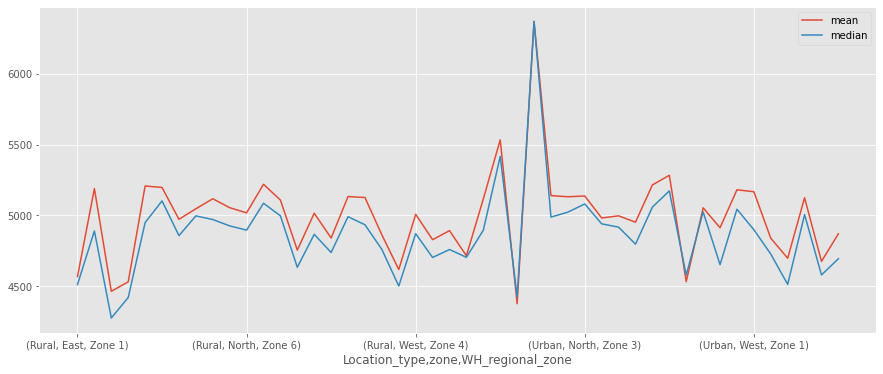

In [100]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['retail_shop_num'].agg(['mean', 'median']).plot(figsize=(15, 6))
plt.savefig('lt_zone_wh_retail.png')

<AxesSubplot:xlabel='retail_shop_num', ylabel='Count'>

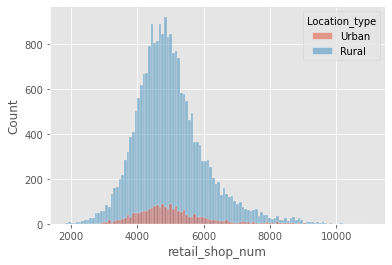

In [71]:
sns.histplot(data=df, x='retail_shop_num', hue='Location_type')

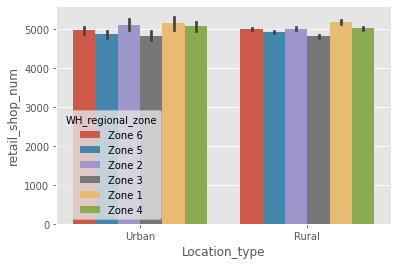

In [98]:
sns.barplot(data=df, x='Location_type', y='retail_shop_num', hue='WH_regional_zone')
plt.savefig('lt_retail_1.png')

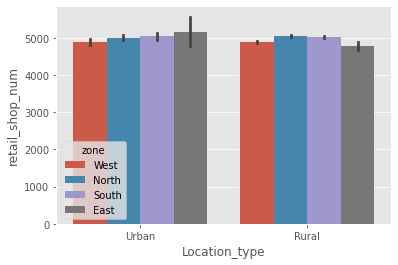

In [99]:
sns.barplot(data=df, x='Location_type', y='retail_shop_num', hue='zone')
plt.savefig('lt_retail.png')

In [84]:
df['wh_owner_type'].value_counts()

Company Owned    13578
Rented           11422
Name: wh_owner_type, dtype: int64

In [85]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone'])['wh_owner_type'].value_counts()

Location_type  zone  WH_regional_zone  wh_owner_type
Rural          East  Zone 1            Company Owned    21
                                       Rented           16
                     Zone 3            Company Owned    51
                                       Rented           49
                     Zone 4            Company Owned    76
                                                        ..
Urban          West  Zone 4            Rented           78
                     Zone 5            Company Owned    63
                                       Rented           57
                     Zone 6            Company Owned    98
                                       Rented           81
Name: wh_owner_type, Length: 91, dtype: int64

In [107]:
pd.crosstab(index=df['Location_type'], columns=df['wh_owner_type'], values=df['retail_shop_num'], aggfunc=['mean', 'sum'])

mean                        sum          
wh_owner_type Company Owned       Rented Company Owned    Rented
Location_type                                                   
Rural           4976.594231  4997.067195      62107896  52354273
Urban           4974.720401  4992.991534       5462243   4718377

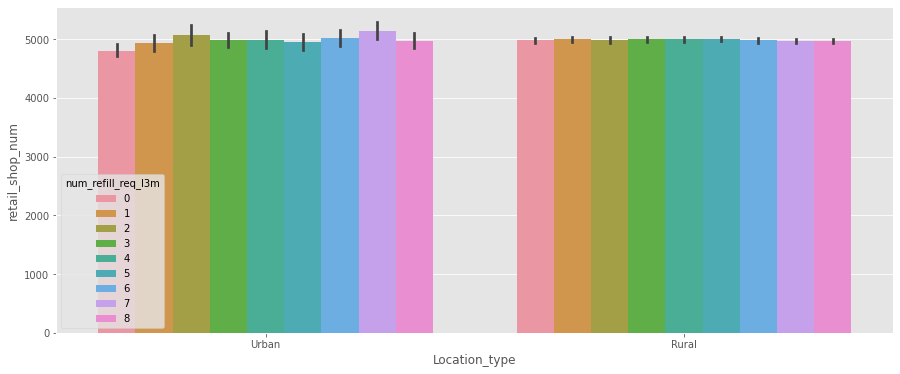

In [108]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, x='Location_type', y='retail_shop_num', hue='num_refill_req_l3m')
plt.show()

<AxesSubplot:xlabel='workers_num', ylabel='count'>

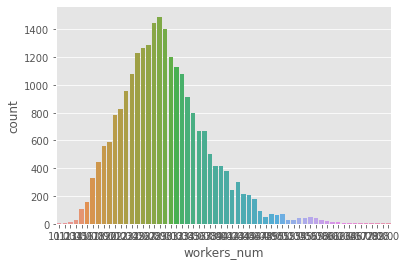

In [109]:
sns.countplot(data=df, x='workers_num')

<AxesSubplot:xlabel='Location_type', ylabel='workers_num'>

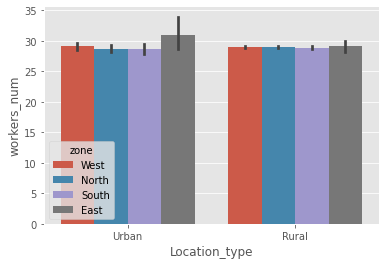

In [111]:
sns.barplot(data=df, x='Location_type', y='workers_num', hue='zone')

<AxesSubplot:xlabel='WH_capacity_size', ylabel='workers_num'>

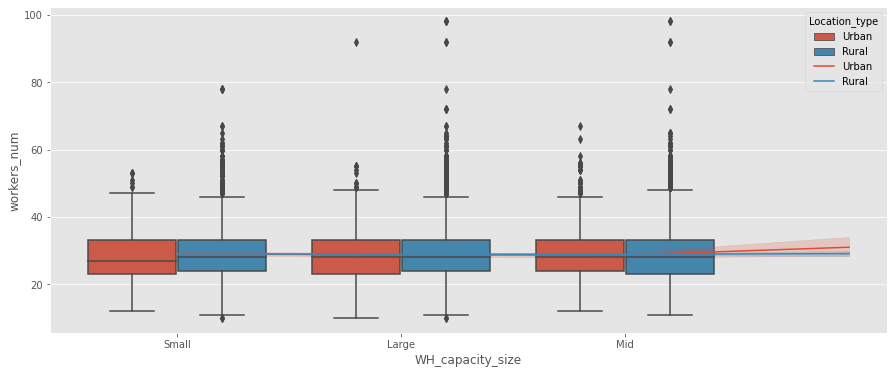

In [116]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='WH_capacity_size', y='workers_num', hue='Location_type')
sns.lineplot(data=df, x='zone', y='workers_num', hue='Location_type')

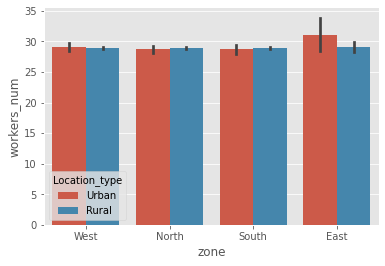

In [4]:
sns.barplot(data=df, x='zone', y='workers_num', hue='Location_type')
plt.savefig('zone_workers_num.png')

In [118]:
df.head()

Ware_house_ID WH_Manager_ID Location_type WH_capacity_size   zone  \
0     WH_100000     EID_50000         Urban            Small   West   
1     WH_100001     EID_50001         Rural            Large  North   
2     WH_100002     EID_50002         Rural              Mid  South   
3     WH_100003     EID_50003         Rural              Mid  North   
4     WH_100004     EID_50004         Rural            Large  North   

  WH_regional_zone  num_refill_req_l3m  transport_issue_l1y  \
0           Zone 6                   3                    1   
1           Zone 5                   0                    0   
2           Zone 2                   1                    0   
3           Zone 3                   7                    4   
4           Zone 5                   3                    1   

   Competitor_in_mkt  retail_shop_num  wh_owner_type  distributor_num  \
0                  2             4651         Rented               24   
1                  4             6217  Company Owned               47   
2                  4             4306  Company Owned               64   
3                  2             6000         Rented               50   
4                  2             4740  Company Owned               42   

   flood_impacted  flood_proof  electric_supply  dist_from_hub  workers_num  \
0               0            1                1             91         29.0   
1               0            0                1            210         31.0   
2               0            0                0            161         37.0   
3               0            0                0            103         21.0   
4               1            0                1            112         25.0   

   wh_est_year  storage_issue_reported_l3m  temp_reg_mach  \
0          NaN                          13              0   
1          NaN                           4              0   
2          NaN                          17              0   
3          NaN                          17              1   
4       2009.0                          18              0   

  approved_wh_govt_certificate  wh_breakdown_l3m  govt_check_l3m  \
0                            A                 5              15   
1                            A                 3              17   
2                            A                 6              22   
3                           A+                 3              27   
4                            C                 6              24   

   product_wg_ton  
0           17115  
1            5074  
2           23137  
3           22115  
4           24071

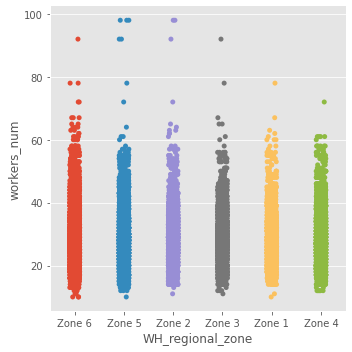

In [122]:
sns.catplot(data=df, x='WH_regional_zone', y='workers_num')

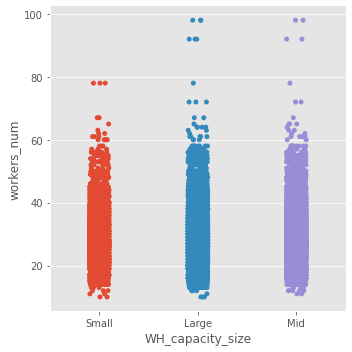

In [123]:
sns.catplot(data=df, x='WH_capacity_size', y='workers_num')

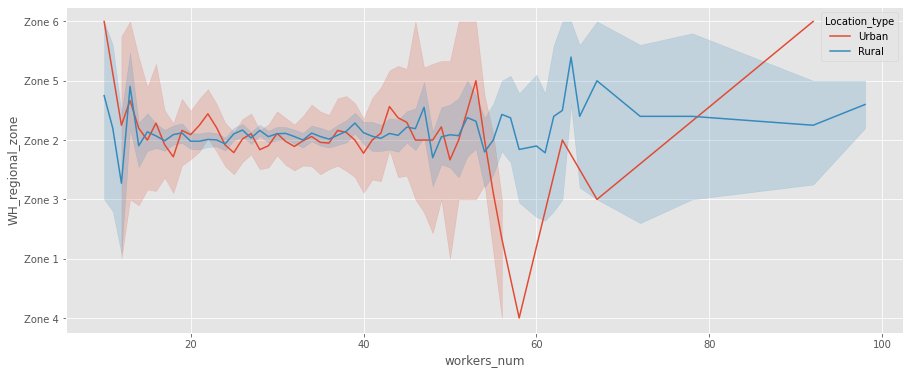

In [120]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='workers_num', y='WH_regional_zone', hue='Location_type')
plt.show()

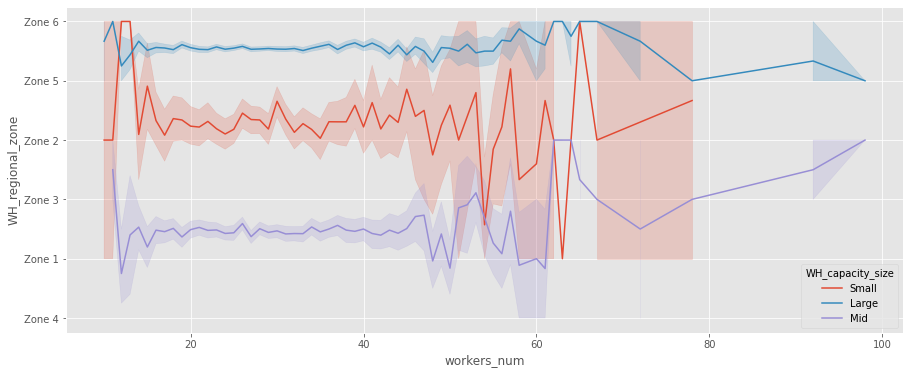

In [121]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='workers_num', y='WH_regional_zone', hue='WH_capacity_size')
plt.show()

<AxesSubplot:xlabel='approved_wh_govt_certificate', ylabel='count'>

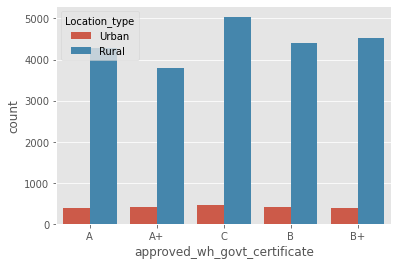

In [6]:
sns.countplot(data=df, x='approved_wh_govt_certificate', hue='Location_type')

<AxesSubplot:xlabel='WH_capacity_size', ylabel='count'>

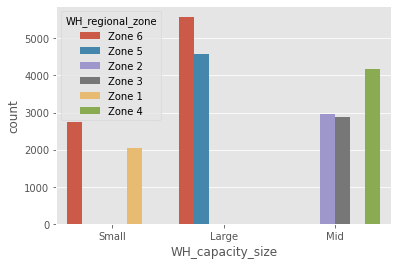

In [10]:
sns.countplot(data=df, x='WH_capacity_size', hue='WH_regional_zone')

<AxesSubplot:xlabel='WH_capacity_size', ylabel='count'>

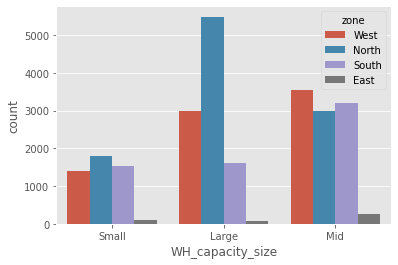

In [11]:
sns.countplot(data=df, x='WH_capacity_size', hue='zone')

In [12]:
df

Ware_house_ID WH_Manager_ID Location_type WH_capacity_size   zone  \
0         WH_100000     EID_50000         Urban            Small   West   
1         WH_100001     EID_50001         Rural            Large  North   
2         WH_100002     EID_50002         Rural              Mid  South   
3         WH_100003     EID_50003         Rural              Mid  North   
4         WH_100004     EID_50004         Rural            Large  North   
...             ...           ...           ...              ...    ...   
24995     WH_124995     EID_74995         Rural            Small  North   
24996     WH_124996     EID_74996         Rural              Mid   West   
24997     WH_124997     EID_74997         Urban            Large  South   
24998     WH_124998     EID_74998         Rural            Small  North   
24999     WH_124999     EID_74999         Rural              Mid   West   

      WH_regional_zone  num_refill_req_l3m  transport_issue_l1y  \
0               Zone 6                   3                    1   
1               Zone 5                   0                    0   
2               Zone 2                   1                    0   
3               Zone 3                   7                    4   
4               Zone 5                   3                    1   
...                ...                 ...                  ...   
24995           Zone 1                   3                    0   
24996           Zone 2                   6                    0   
24997           Zone 5                   7                    0   
24998           Zone 1                   1                    0   
24999           Zone 4                   8                    2   

       Competitor_in_mkt  retail_shop_num  wh_owner_type  distributor_num  \
0                      2             4651         Rented               24   
1                      4             6217  Company Owned               47   
2                      4             4306  Company Owned               64   
3                      2             6000         Rented               50   
4                      2             4740  Company Owned               42   
...                  ...              ...            ...              ...   
24995                  4             5390         Rented               19   
24996                  4             4490  Company Owned               57   
24997                  2             5403         Rented               31   
24998                  2            10562         Rented               25   
24999                  4             5664  Company Owned               21   

       flood_impacted  flood_proof  electric_supply  dist_from_hub  \
0                   0            1                1             91   
1                   0            0                1            210   
2                   0            0                0            161   
3                   0            0                0            103   
4                   1            0                1            112   
...               ...          ...              ...            ...   
24995               0            0                1            142   
24996               0            0                1            130   
24997               1            0                1            147   
24998               0            0                1             60   
24999               0            1                1            239   

       workers_num  wh_est_year  storage_issue_reported_l3m  temp_reg_mach  \
0             29.0          NaN                          13              0   
1             31.0          NaN                           4              0   
2             37.0          NaN                          17              0   
3             21.0          NaN                          17              1   
4             25.0       2009.0                          18              0   
...            ...          ...                         ...       

<AxesSubplot:xlabel='WH_capacity_size', ylabel='workers_num'>

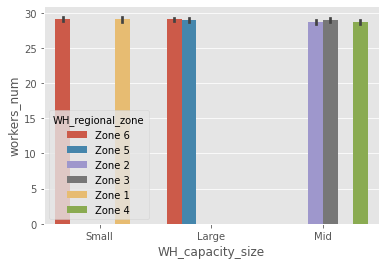

In [29]:
sns.barplot(data=df, x='WH_capacity_size', y='workers_num', hue='WH_regional_zone')

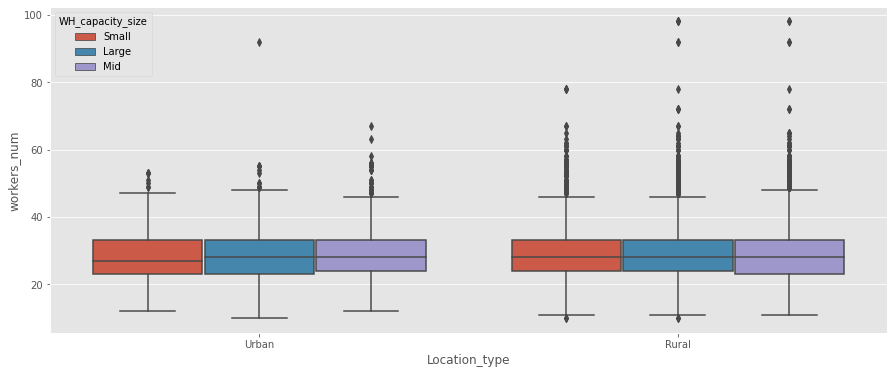

In [32]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='Location_type', y='workers_num', hue='WH_capacity_size')
plt.savefig('lt_workers_cs.png')
plt.show()

<AxesSubplot:xlabel='Location_type', ylabel='workers_num'>

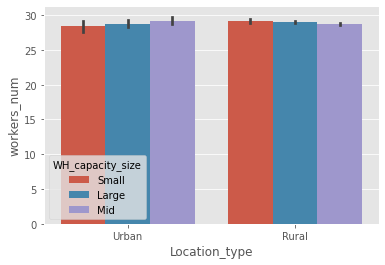

In [24]:
sns.barplot(data=df, x='Location_type', y='workers_num', hue='WH_capacity_size')

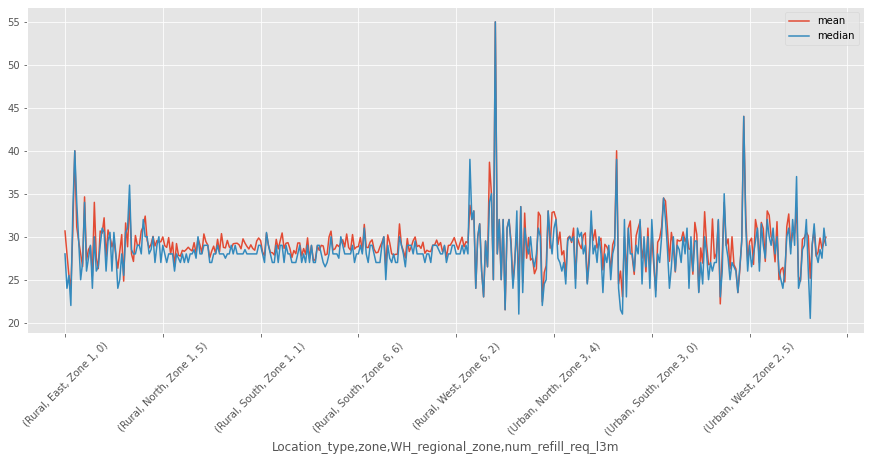

In [20]:
df.groupby(['Location_type', 'zone', 'WH_regional_zone', 'num_refill_req_l3m'])['workers_num'].agg(['mean', 'median']).plot(figsize=(15, 6))
plt.xticks(rotation=45)
plt.show()

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [40]:
new_df = df.copy()

In [41]:
cat_cols = [col for col in new_df.columns if new_df[col].dtypes == 'object']
cat_cols

['Ware_house_ID',
 'WH_Manager_ID',
 'Location_type',
 'WH_capacity_size',
 'zone',
 'WH_regional_zone',
 'wh_owner_type',
 'approved_wh_govt_certificate']

In [42]:
from sklearn.preprocessing import LabelEncoder

In [43]:
for col in cat_cols:
    encoder = LabelEncoder()
    new_df.loc[:, col] = encoder.fit_transform(new_df[col])

In [45]:
new_df.fillna(0, axis=1, inplace=True)

In [46]:
pd.Series([variance_inflation_factor(new_df.values, i) for i in range(new_df.shape[1])], index=new_df.columns)

C:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Ware_house_ID                          inf
WH_Manager_ID                          inf
Location_type                     1.097677
WH_capacity_size                  2.791369
zone                              5.493082
WH_regional_zone                  5.953512
num_refill_req_l3m                5.478380
transport_issue_l1y               1.674381
Competitor_in_mkt                 7.985718
retail_shop_num                  18.191407
wh_owner_type                     1.939443
distributor_num                   7.409976
flood_impacted                    1.157158
flood_proof                       1.084662
electric_supply                   3.298896
dist_from_hub                     7.270896
workers_num                       9.430675
wh_est_year                       3.668712
storage_issue_reported_l3m      198.705365
temp_reg_mach                     1.680802
approved_wh_govt_certificate      3.279170
wh_breakdown_l3m                  6.304754
govt_check_l3m                    5.767650
product_wg_

<AxesSubplot:xlabel='Competitor_in_mkt,retail_shop_num'>

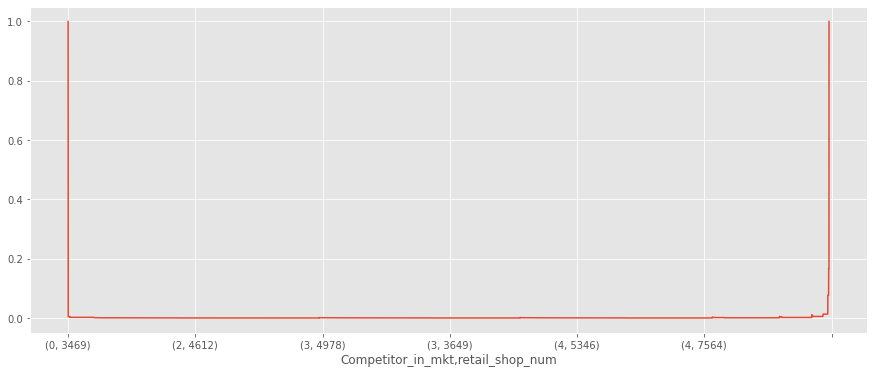

In [49]:
df.groupby('Competitor_in_mkt')['retail_shop_num'].value_counts(normalize=True).plot(figsize=(15, 6))

In [51]:
df.groupby('Competitor_in_mkt')[['retail_shop_num', 'num_refill_req_l3m']].agg(['mean', 'median', 'count'])

retail_shop_num               num_refill_req_l3m         \
                             mean  median count               mean median   
Competitor_in_mkt                                                           
0                     3469.000000  3469.0     1           7.000000    7.0   
1                     5308.745370  5290.5   432           4.011574    4.0   
2                     5179.720152  5069.0  8669           4.087207    4.0   
3                     4952.613194  4821.5  7094           4.103045    4.0   
4                     4848.221228  4731.0  6708           4.079308    4.0   
5                     4717.414229  4557.0  1265           4.041107    4.0   
6                     4606.274725  4445.0   546           4.146520    4.0   
7                     4661.962963  4436.0   189           4.153439    4.0   
8                     4448.552632  4326.0    76           4.223684    4.0   
9                     4037.076923  4037.0    13           4.230769    4.0   
10                    4727.000000  4853.0     6           6.333333    7.0   
12                    4642.000000  4642.0     1           8.000000    8.0   

                         
                  count  
Competitor_in_mkt        
0                     1  
1                   432  
2                  8669  
3                  7094  
4                  6708  
5                  1265  
6                   546  
7                   189  
8                    76  
9                    13  
10                    6  
12                    1

<AxesSubplot:xlabel='num_refill_req_l3m,Competitor_in_mkt'>

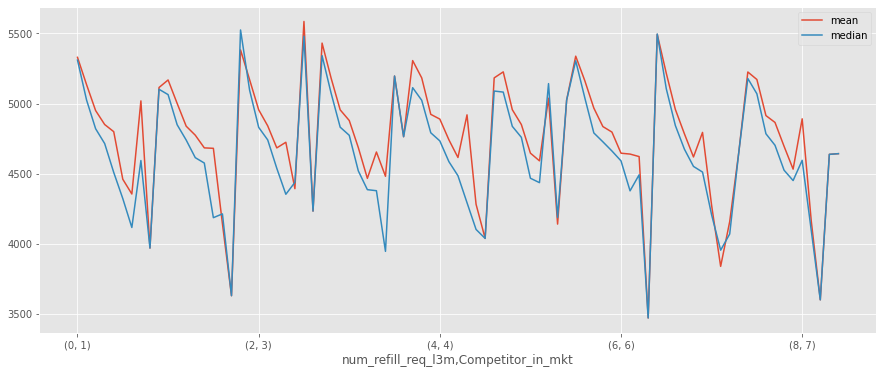

In [54]:
df.groupby(['num_refill_req_l3m', 'Competitor_in_mkt'])['retail_shop_num'].agg(['mean', 'median']).plot(figsize=(15, 6))

In [79]:
df.groupby('Competitor_in_mkt')['retail_shop_num'].agg(['mean', 'median', 'count'])

mean  median  count
Competitor_in_mkt                            
0                  3469.000000  3469.0      1
1                  5308.745370  5290.5    432
2                  5179.720152  5069.0   8669
3                  4952.613194  4821.5   7094
4                  4848.221228  4731.0   6708
5                  4717.414229  4557.0   1265
6                  4606.274725  4445.0    546
7                  4661.962963  4436.0    189
8                  4448.552632  4326.0     76
9                  4037.076923  4037.0     13
10                 4727.000000  4853.0      6
12                 4642.000000  4642.0      1

<AxesSubplot:xlabel='product_wg_ton', ylabel='Count'>

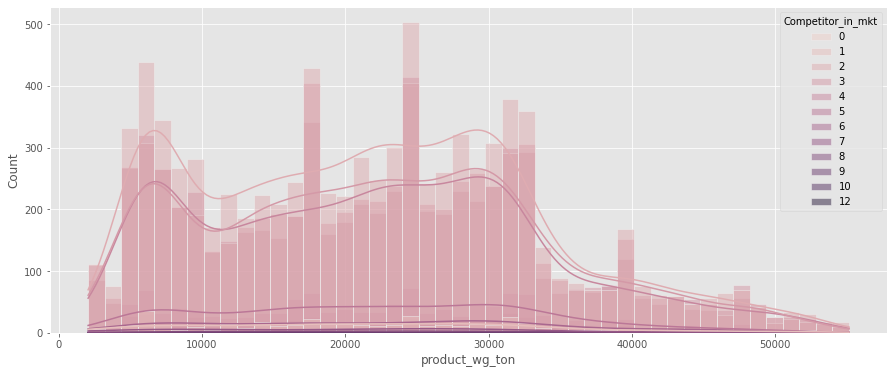

In [76]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='product_wg_ton', hue='Competitor_in_mkt', kde=True)

<AxesSubplot:xlabel='retail_shop_num', ylabel='Count'>

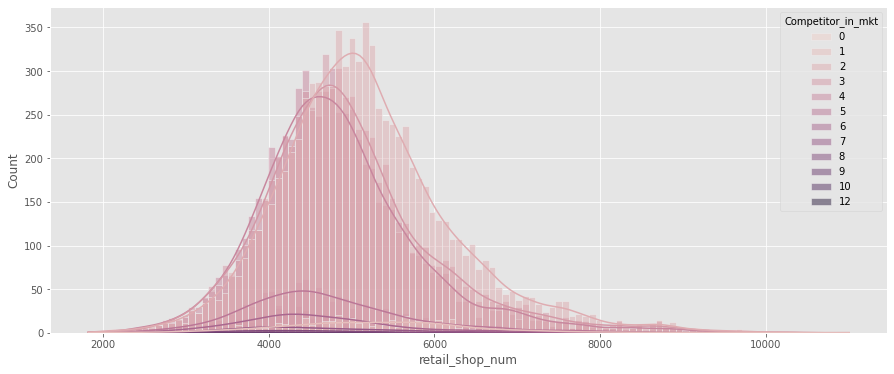

In [56]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='retail_shop_num', hue='Competitor_in_mkt', kde=True)

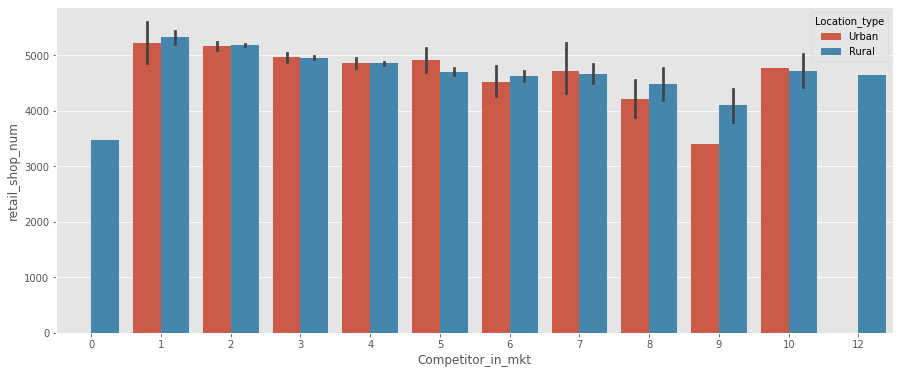

In [80]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, y='retail_shop_num', x='Competitor_in_mkt', hue='Location_type')
plt.savefig('retail_comp_lt.png')

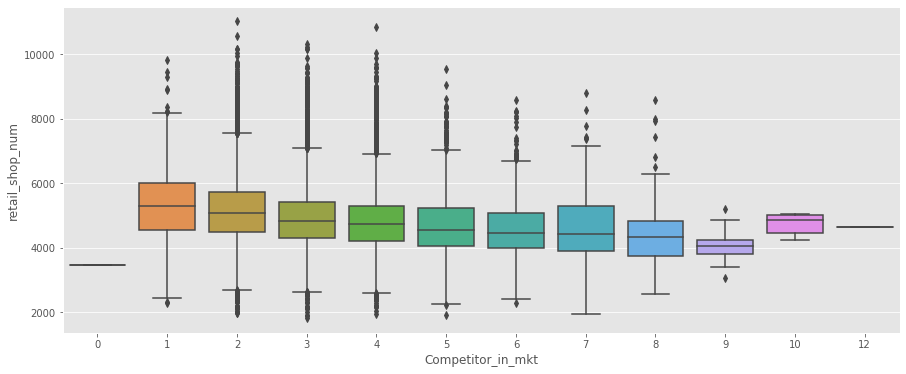

In [81]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, y='retail_shop_num', x='Competitor_in_mkt')
plt.savefig('retail_comp_lt_1.png')

<AxesSubplot:xlabel='distributor_num', ylabel='Count'>

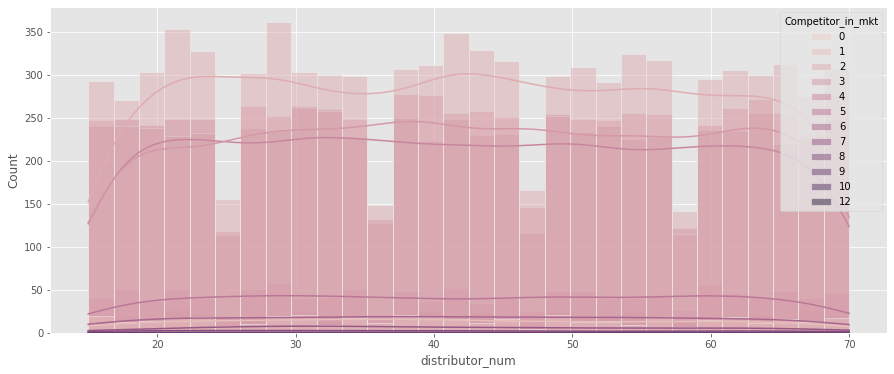

In [58]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='distributor_num', hue='Competitor_in_mkt', kde=True)

<AxesSubplot:xlabel='Competitor_in_mkt', ylabel='distributor_num'>

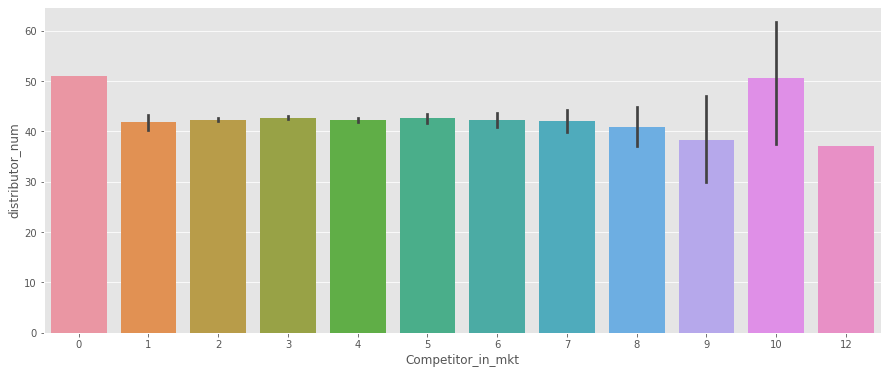

In [59]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df, y='distributor_num', x='Competitor_in_mkt')

<AxesSubplot:xlabel='Competitor_in_mkt', ylabel='distributor_num'>

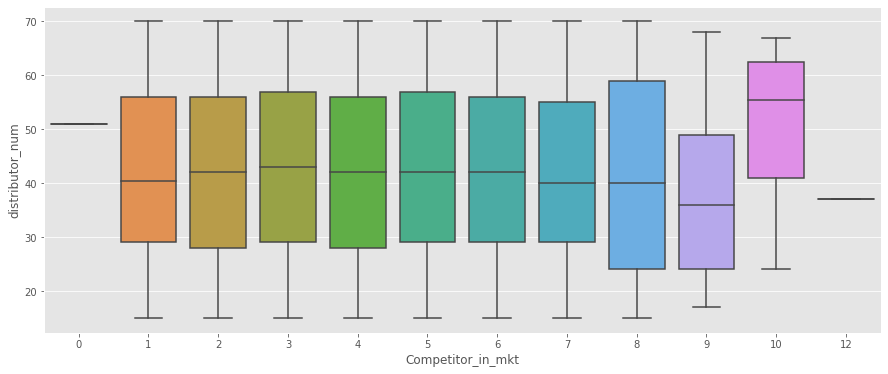

In [62]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, y='distributor_num', x='Competitor_in_mkt')

<AxesSubplot:xlabel='Competitor_in_mkt', ylabel='retail_shop_num'>

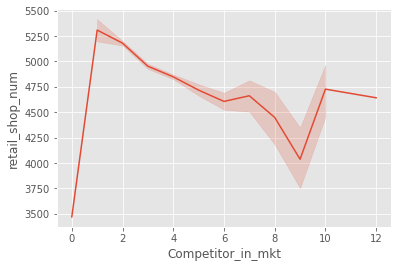

In [96]:
sns.lineplot(data=df, x='Competitor_in_mkt', y='retail_shop_num')

<AxesSubplot:xlabel='product_wg_ton', ylabel='retail_shop_num'>

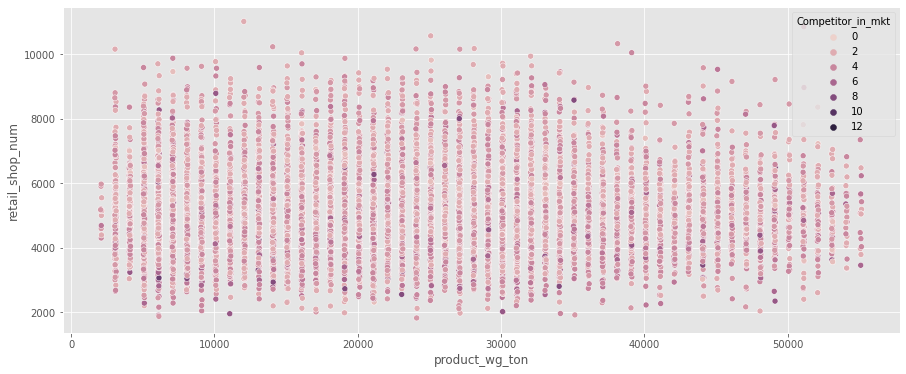

In [94]:
plt.figure(figsize=(15, 6))
sns.scatterplot(data=df, x='product_wg_ton', y='retail_shop_num', hue='Competitor_in_mkt', estimator=[0.25, 0.75])

In [91]:
df[['Competitor_in_mkt', 'retail_shop_num', 'product_wg_ton']].corr()

Competitor_in_mkt  retail_shop_num  product_wg_ton
Competitor_in_mkt           1.000000        -0.156943        0.008884
retail_shop_num            -0.156943         1.000000       -0.006615
product_wg_ton              0.008884        -0.006615        1.000000

In [82]:
X = df[['storage_issue_reported_l3m', 'distributor_num', 'product_wg_ton', 'retail_shop_num']]
y = df['Competitor_in_mkt']

In [84]:
result = sm.OLS(y, X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:      Competitor_in_mkt   R-squared (uncentered):                   0.842
Model:                            OLS   Adj. R-squared (uncentered):              0.842
Method:                 Least Squares   F-statistic:                          3.335e+04
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                        0.00
Time:                        20:16:58   Log-Likelihood:                         -42299.
No. Observations:               25000   AIC:                                  8.461e+04
Df Residuals:                   24996   BIC:                                  8.464e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [68]:
mu_ = df[['storage_issue_reported_l3m', 'distributor_num', 'Competitor_in_mkt', 'distributor_num',
    'retail_shop_num', 'product_wg_ton']].copy()

In [72]:
mu_.dtypes

storage_issue_reported_l3m    int64
distributor_num               int64
Competitor_in_mkt             int64
distributor_num               int64
retail_shop_num               int64
product_wg_ton                int64
dtype: object

In [69]:
sns.pairplot(mu_)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
storage_issue_reported_l3m      product